In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import random
from itertools import combinations

import tensorflow as tf
from PIL import Image
import torch

from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

import torchvision
from torchvision.transforms import v2

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load data

In [ ]:
img_paths = []
styles = []
builders = []

count = 0

base = '/xxx/xxx' # Fill in the root path of the dataset
for dir in os.listdir(base):
  if(dir == '17270'): continue
  # fstimg = sorted(os.listdir(base + dir), key=lambda filename: filename.split("."))[0]
  allimgs = os.listdir(base + dir)
  allimgs.remove('design_info.txt')
  # print(allimgs)

  f = open(base + dir + '/' + 'design_info.txt', "r")
  info = f.read()

  if(info.find('設計風格') == -1): continue

  style = info.split('設計風格:')[1]
  style = style.split('房屋類型:')[0]
  if(len(style) > 10):
    style = style.split('房屋坪數:')[0]

  style = style.replace('\n', '')

  if(info.find('圖片提供') == -1): continue
  builder = info.split('圖片提供:')[1]
  builder = builder.split('\n')[1].split('空間格局:')[0]
  print("builder:", builder)

  for allimg in allimgs:
    img_paths.append(base + dir + '/' + allimg)
    styles.append(style)
    builders.append(builder)

    # print("style:", style, "path:", img_paths)

    print("i:", count)
    count += 1

串流輸出內容已截斷至最後 5000 行。
i: 995
i: 996
i: 997
i: 998
i: 999
i: 1000
i: 1001
i: 1002
i: 1003
i: 1004
i: 1005
i: 1006
i: 1007
i: 1008
i: 1009
i: 1010
i: 1011
i: 1012
i: 1013
builder: 尚毅室內設計工程坊
i: 1014
i: 1015
i: 1016
i: 1017
i: 1018
i: 1019
i: 1020
i: 1021
i: 1022
i: 1023
i: 1024
i: 1025
i: 1026
i: 1027
i: 1028
builder: 采品室內設計
i: 1029
i: 1030
i: 1031
i: 1032
i: 1033
i: 1034
i: 1035
i: 1036
i: 1037
i: 1038
i: 1039
i: 1040
i: 1041
i: 1042
i: 1043
i: 1044
i: 1045
i: 1046
i: 1047
i: 1048
i: 1049
i: 1050
i: 1051
i: 1052
i: 1053
i: 1054
i: 1055
i: 1056
i: 1057
i: 1058
i: 1059
i: 1060
i: 1061
i: 1062
i: 1063
i: 1064
builder: 寬野室內設計
i: 1065
i: 1066
i: 1067
i: 1068
i: 1069
i: 1070
i: 1071
i: 1072
i: 1073
i: 1074
i: 1075
i: 1076
i: 1077
i: 1078
i: 1079
i: 1080
i: 1081
i: 1082
i: 1083
i: 1084
i: 1085
i: 1086
i: 1087
i: 1088
i: 1089
i: 1090
i: 1091
i: 1092
i: 1093
i: 1094
i: 1095
i: 1096
builder: 橙碩室內設計
i: 1097
i: 1098
i: 1099
i: 1100
i: 1101
i: 1102
i: 1103
i: 1104
i: 1105
i: 1106
i: 1107
i: 1108
i: 11

In [ ]:
len(img_paths), len(styles), len(builders)

(4945, 4945, 4945)

In [ ]:
# data = {'img_path': img_paths, 'style': styles}
# df = pd.DataFrame(data)
# df.to_csv('img_style.csv', index=False)

# Read data

In [ ]:
df = pd.DataFrame([img_paths, styles, builders])
df = df.transpose()
df.columns = ['img_path', 'style', 'builder']
df.head()

img_path style        builder
0  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   現代風     我思空間設計有限公司
1  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  休閒多元           澄易設計
2  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   輕奢風           九日設計
3  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   現代風       匠拓室內裝修設計
4  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   現代風  雋築空間設計＆睿謙室內裝修

In [ ]:
df['style'].value_counts()

style
現代風                                                    2202
混搭風                                                     696
北歐風                                                     529
美式風                                                     335
其他                                                      236
休閒多元                                                    157
工業風                                                     149
日式風                                                     127
新古典                                                     120
鄉村風                                                      83
日式禪風                                                     62
輕奢風                                                      53
奢華風                                                      40
簡約風                                                      35
東方風                                                      28
異國風                                                      27
無印風                               

In [ ]:
style_mapping = {
    "現代風": "modern",
    "混搭風": "eclectic",
    "北歐風": "Scandinavian",
    "美式風": "American",
    "其他": "other",
    "日式風": "Japanese",
    "休閒多元": "casual",
    "工業風": "industrial",
    "新古典": "neoclassical",
    "鄉村風": "country",
    "輕奢風": "light luxury",
    "日式禪風": "Japanese zen",
    "簡約風": "minimalist",
    "奢華風": "luxurious",
    "無印風": "Muji",
    "異國風": "exotic",
    "東方風": "oriental",
    "古典風": "classical",
    "前衛風": "avant-garde"
}


df['style'] = df['style'].map(style_mapping)

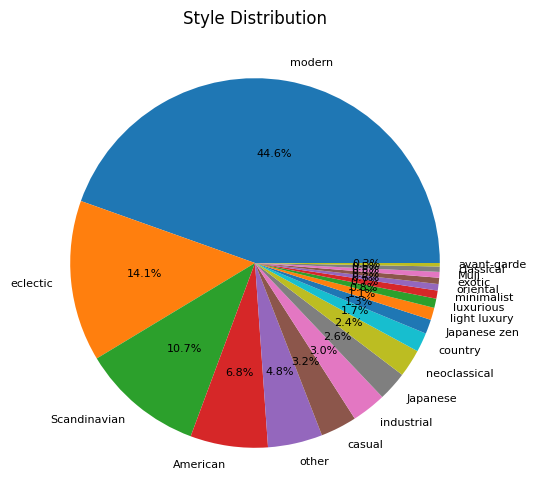

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(df['style'].value_counts(), labels=df['style'].value_counts().index, autopct="%1.1f%%", textprops={'fontsize': 8})
plt.title("Style Distribution")
plt.show()

In [ ]:
# prompt: output each style data count as csv sort  the value descending

df.groupby('style').size().sort_values(ascending=False).to_csv('style_count.csv')


In [ ]:
# prompt: count each style

style_count = df['style'].value_counts()
print(style_count[['modern', 'Scandinavian', 'American', 'industrial', 'Japanese']])


style
modern          2202
Scandinavian     529
American         335
industrial       149
Japanese         127
Name: count, dtype: int64


# Data preprocesing

In [ ]:
df.shape

(4945, 3)

In [ ]:
# 現代風
df_modern = df[df['style'] == 'modern']
df_modern = df_modern.sample(n=300)

# 北歐風
df_scand = df[df['style'] == 'Scandinavian']
df_scand = df_scand.sample(n=300)

# 美式風
df_american = df[df['style'] == 'American']
df_american = df_american.sample(n=300)

In [ ]:
df_others = df[df['style'].isin(['Japanese', 'industrial'])]

In [ ]:
new_df = pd.concat([df_modern, df_scand, df_american, df_others])
new_df['style'].value_counts()

style
modern          300
Scandinavian    300
American        300
industrial      149
Japanese        127
Name: count, dtype: int64

In [ ]:
style_to_number = dict(zip(new_df['style'].value_counts().index, range(len(new_df['style'].value_counts()))))
print(style_to_number)

class_num = max(style_to_number.values()) + 1
print('class_num:', class_num)

{'modern': 0, 'Scandinavian': 1, 'American': 2, 'industrial': 3, 'Japanese': 4}
class_num: 5


In [ ]:
new_df['style'] = new_df['style'].map(style_to_number)
new_df.head()

img_path  style builder
4436  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  寬野室內設計
4001  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0    優適設計
457   /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  緯邁空間規劃
2569  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0    恆合設計
2489  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  墐桐空間美學

In [ ]:
# new_df = new_df.reset_index(drop=True)

In [ ]:
new_df

img_path  style builder
4436  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  寬野室內設計
4001  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0    優適設計
457   /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  緯邁空間規劃
2569  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0    恆合設計
2489  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  墐桐空間美學
...                                                 ...    ...     ...
4891  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      4    御見設計
4892  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      4    御見設計
4893  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      4    御見設計
4894  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      4    御見設計
4895  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      4    御見設計

[1176 rows x 3 columns]

# Data loader

In [ ]:
new_df['style'].value_counts()

style
0    300
1    300
2    300
3    149
4    127
Name: count, dtype: int64

In [ ]:
balance_df = pd.DataFrame()
for style in new_df['style'].value_counts().index:
    style_df = new_df[new_df['style'] == style].sample(n=127)
    balance_df = pd.concat([balance_df, style_df])
balance_df['style'].value_counts()

style
0    127
1    127
2    127
3    127
4    127
Name: count, dtype: int64

In [ ]:
new_df.shape, balance_df.shape

((1176, 3), (635, 3))

In [ ]:
train_portion = 1 - (new_df.shape[0] * 0.2) / balance_df.shape[0]
train_portion

0.6296062992125984

In [ ]:
batch_size = 32

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, train):
        self.train = train

    def __len__(self):
        return len(self.train)

    def __getitem__(self, idx):
        img_path = self.train.iloc[idx, :]['img_path']
        image = torchvision.io.read_image(img_path)

        transforms = v2.Compose([
            # v2.CenterCrop((224, 224)),
            v2.Resize((224, 224)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image = transforms(image)
        label = self.train.iloc[idx, :]['style']
        # print("label:", label)
        return image, label


class ImageAugDataset(torch.utils.data.Dataset):
    def __init__(self, train):
        self.train = train

    def __len__(self):
        return len(self.train)

    def __getitem__(self, idx):
        img_path = self.train.iloc[idx, :]['img_path']
        image = torchvision.io.read_image(img_path)

        aug_transforms = v2.Compose([
            v2.CenterCrop((224, 224)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

            # v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05)),
            v2.RandomRotation(30, expand=False, center=(55, 5))
        ])
        image = aug_transforms(image)
        label = self.train.iloc[idx, :]['style']
        # print("label:", label)
        return image, label

# dataset = ImageDataset(train=new_df)
dataset = ImageDataset(train=balance_df)

train_size = int(train_portion * len(dataset)) # first sample balance from test
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
len(train_data)

399

In [ ]:
# 把 balance_df 沒有的重新加到 train_data

remaining_data = new_df[~new_df.index.isin(balance_df.index)]
remaining_dataset = ImageDataset(train=pd.DataFrame(remaining_data))
train_data = torch.utils.data.ConcatDataset([train_data, remaining_dataset])

In [ ]:
len(remaining_dataset)

541

In [ ]:
len(train_data), len(test_data)

(940, 236)

In [ ]:
len(train_data) / (len(train_data) + len(test_data))

0.7993197278911565

## Data augmentation

In [ ]:
# style counts in train_data
i = 0
style_counts = {}
for _, label in train_data:
    style = label.item()
    # print("style", style)
    if style not in style_counts:
        style_counts[style] = 0
    style_counts[style] += 1

    # print(style_counts)
    print(i)
    i += 1

print(style_counts)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
mod = new_df[new_df['style'] == 0]
sca = new_df[new_df['style'] == 1]
ame = new_df[new_df['style'] == 2]
ind = new_df[new_df['style'] == 3]
jap = new_df[new_df['style'] == 4]


_mod = mod.sample(n=262-254)
# _sca = sca.sample(n=300-200)
_ame = ame.sample(n=262-241)
_ind = ind.sample(n=262-100, replace=True)
_jap = jap.sample(n=262-83, replace=True)


aug_df = pd.concat([_mod, _ame, _ind, _jap])
aug_df['style'].value_counts()

style
4    179
3    162
2     21
0      8
Name: count, dtype: int64

In [ ]:
aug_train_data = ImageAugDataset(train=aug_df)
aug_train_data

In [ ]:
train_data = torch.utils.data.ConcatDataset([train_data, aug_train_data])

In [ ]:
len(train_data)

1310

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
len(train_data), len(test_data)

(1310, 236)

In [ ]:
len(train_data) / (len(train_data) + len(test_data))

0.8473479948253557

# Classification Model

## VGG16

[參考資料](https://medium.com/geekculture/boost-your-image-classification-model-with-pretrained-vgg-16-ec185f763104)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


	Epoch [1/30], Step [1/41], Loss: 1.6216
	Epoch [1/30], Step [2/41], Loss: 1.6481
	Epoch [1/30], Step [3/41], Loss: 1.6197
	Epoch [1/30], Step [4/41], Loss: 1.6030
	Epoch [1/30], Step [5/41], Loss: 1.6511
	Epoch [1/30], Step [6/41], Loss: 1.6377
	Epoch [1/30], Step [7/41], Loss: 1.5755
	Epoch [1/30], Step [8/41], Loss: 1.6113
	Epoch [1/30], Step [9/41], Loss: 1.6062
	Epoch [1/30], Step [10/41], Loss: 1.5843
	Epoch [1/30], Step [11/41], Loss: 1.6157
	Epoch [1/30], Step [12/41], Loss: 1.5613
	Epoch [1/30], Step [13/41], Loss: 1.5823
	Epoch [1/30], Step [14/41], Loss: 1.5671
	Epoch [1/30], Step [15/41], Loss: 1.6003
	Epoch [1/30], Step [16/41], Loss: 1.5606
	Epoch [1/30], Step [17/41], Loss: 1.5942
	Epoch [1/30], Step [18/41], Loss: 1.5818
	Epoch [1/30], Step [19/41], Loss: 1.5486
	Epoch [1/30], Step [20/41], Loss: 1.5843
	Epoch [1/30], Step [21/41], Loss: 1.5941
	Epoch [1/30], Step [22/41], Loss: 1.5297
	Epoch [1/30], Step [23/41], Loss: 1.5224
	Epoch [1/30], Step [24/41], Loss: 1.5427
	

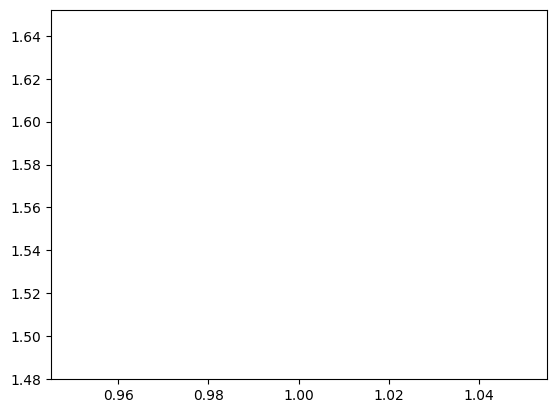

	Epoch [2/30], Step [1/41], Loss: 1.5005
	Epoch [2/30], Step [2/41], Loss: 1.4932
	Epoch [2/30], Step [3/41], Loss: 1.5172
	Epoch [2/30], Step [4/41], Loss: 1.4420
	Epoch [2/30], Step [5/41], Loss: 1.5212
	Epoch [2/30], Step [6/41], Loss: 1.5243
	Epoch [2/30], Step [7/41], Loss: 1.4921
	Epoch [2/30], Step [8/41], Loss: 1.4999
	Epoch [2/30], Step [9/41], Loss: 1.4811
	Epoch [2/30], Step [10/41], Loss: 1.4659
	Epoch [2/30], Step [11/41], Loss: 1.5152
	Epoch [2/30], Step [12/41], Loss: 1.4871
	Epoch [2/30], Step [13/41], Loss: 1.4408
	Epoch [2/30], Step [14/41], Loss: 1.4109
	Epoch [2/30], Step [15/41], Loss: 1.4442
	Epoch [2/30], Step [16/41], Loss: 1.5120
	Epoch [2/30], Step [17/41], Loss: 1.4388
	Epoch [2/30], Step [18/41], Loss: 1.4823
	Epoch [2/30], Step [19/41], Loss: 1.4816
	Epoch [2/30], Step [20/41], Loss: 1.4565
	Epoch [2/30], Step [21/41], Loss: 1.3994
	Epoch [2/30], Step [22/41], Loss: 1.4763
	Epoch [2/30], Step [23/41], Loss: 1.4166
	Epoch [2/30], Step [24/41], Loss: 1.4742
	

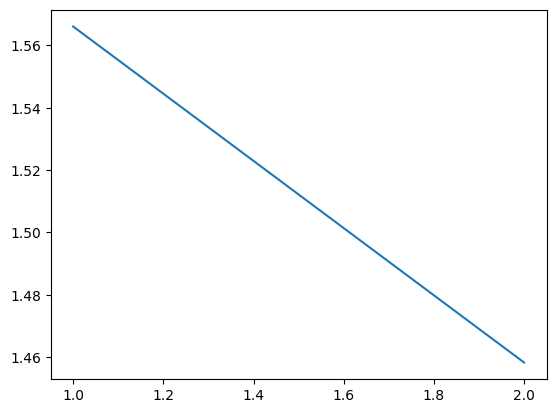

	Epoch [3/30], Step [1/41], Loss: 1.4606
	Epoch [3/30], Step [2/41], Loss: 1.3922
	Epoch [3/30], Step [3/41], Loss: 1.4356
	Epoch [3/30], Step [4/41], Loss: 1.4562
	Epoch [3/30], Step [5/41], Loss: 1.4333
	Epoch [3/30], Step [6/41], Loss: 1.4055
	Epoch [3/30], Step [7/41], Loss: 1.4191
	Epoch [3/30], Step [8/41], Loss: 1.3711
	Epoch [3/30], Step [9/41], Loss: 1.3348
	Epoch [3/30], Step [10/41], Loss: 1.3886
	Epoch [3/30], Step [11/41], Loss: 1.4096
	Epoch [3/30], Step [12/41], Loss: 1.4526
	Epoch [3/30], Step [13/41], Loss: 1.4051
	Epoch [3/30], Step [14/41], Loss: 1.3195
	Epoch [3/30], Step [15/41], Loss: 1.3133
	Epoch [3/30], Step [16/41], Loss: 1.3521
	Epoch [3/30], Step [17/41], Loss: 1.3738
	Epoch [3/30], Step [18/41], Loss: 1.3433
	Epoch [3/30], Step [19/41], Loss: 1.3666
	Epoch [3/30], Step [20/41], Loss: 1.3364
	Epoch [3/30], Step [21/41], Loss: 1.3920
	Epoch [3/30], Step [22/41], Loss: 1.3425
	Epoch [3/30], Step [23/41], Loss: 1.3285
	Epoch [3/30], Step [24/41], Loss: 1.3871
	

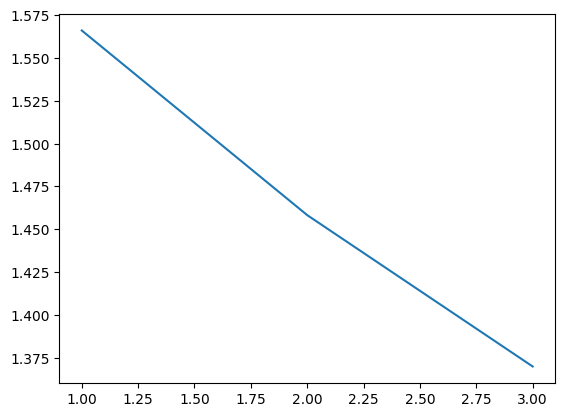

	Epoch [4/30], Step [1/41], Loss: 1.3008
	Epoch [4/30], Step [2/41], Loss: 1.3514
	Epoch [4/30], Step [3/41], Loss: 1.2572
	Epoch [4/30], Step [4/41], Loss: 1.3802
	Epoch [4/30], Step [5/41], Loss: 1.3634
	Epoch [4/30], Step [6/41], Loss: 1.2946
	Epoch [4/30], Step [7/41], Loss: 1.3766
	Epoch [4/30], Step [8/41], Loss: 1.2857
	Epoch [4/30], Step [9/41], Loss: 1.2593
	Epoch [4/30], Step [10/41], Loss: 1.3271
	Epoch [4/30], Step [11/41], Loss: 1.2888
	Epoch [4/30], Step [12/41], Loss: 1.3077
	Epoch [4/30], Step [13/41], Loss: 1.3852
	Epoch [4/30], Step [14/41], Loss: 1.2541
	Epoch [4/30], Step [15/41], Loss: 1.3950
	Epoch [4/30], Step [16/41], Loss: 1.2975
	Epoch [4/30], Step [17/41], Loss: 1.2870
	Epoch [4/30], Step [18/41], Loss: 1.3572
	Epoch [4/30], Step [19/41], Loss: 1.2302
	Epoch [4/30], Step [20/41], Loss: 1.2754
	Epoch [4/30], Step [21/41], Loss: 1.3770
	Epoch [4/30], Step [22/41], Loss: 1.3124
	Epoch [4/30], Step [23/41], Loss: 1.3057
	Epoch [4/30], Step [24/41], Loss: 1.2534
	

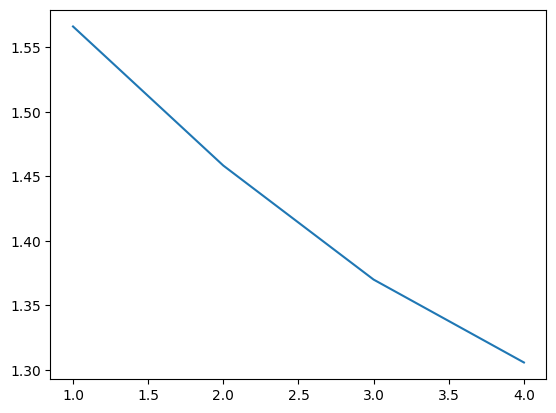

	Epoch [5/30], Step [1/41], Loss: 1.3202
	Epoch [5/30], Step [2/41], Loss: 1.3209
	Epoch [5/30], Step [3/41], Loss: 1.2932
	Epoch [5/30], Step [4/41], Loss: 1.3026
	Epoch [5/30], Step [5/41], Loss: 1.2773
	Epoch [5/30], Step [6/41], Loss: 1.2378
	Epoch [5/30], Step [7/41], Loss: 1.2385
	Epoch [5/30], Step [8/41], Loss: 1.3023
	Epoch [5/30], Step [9/41], Loss: 1.2519
	Epoch [5/30], Step [10/41], Loss: 1.2442
	Epoch [5/30], Step [11/41], Loss: 1.3353
	Epoch [5/30], Step [12/41], Loss: 1.2815
	Epoch [5/30], Step [13/41], Loss: 1.2386
	Epoch [5/30], Step [14/41], Loss: 1.2692
	Epoch [5/30], Step [15/41], Loss: 1.2996
	Epoch [5/30], Step [16/41], Loss: 1.2919
	Epoch [5/30], Step [17/41], Loss: 1.2833
	Epoch [5/30], Step [18/41], Loss: 1.2398
	Epoch [5/30], Step [19/41], Loss: 1.2575
	Epoch [5/30], Step [20/41], Loss: 1.2749
	Epoch [5/30], Step [21/41], Loss: 1.2431
	Epoch [5/30], Step [22/41], Loss: 1.1746
	Epoch [5/30], Step [23/41], Loss: 1.2463
	Epoch [5/30], Step [24/41], Loss: 1.2748
	

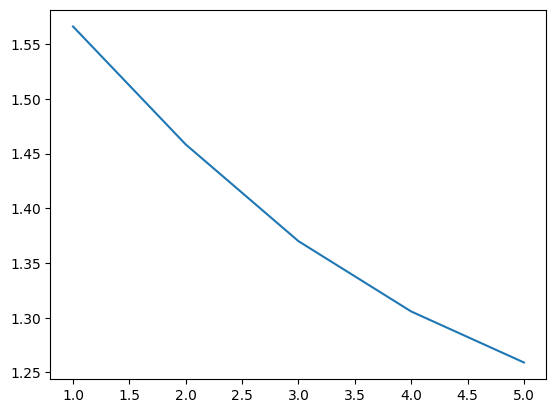

	Epoch [6/30], Step [1/41], Loss: 1.2686
	Epoch [6/30], Step [2/41], Loss: 1.2348
	Epoch [6/30], Step [3/41], Loss: 1.2236
	Epoch [6/30], Step [4/41], Loss: 1.2150
	Epoch [6/30], Step [5/41], Loss: 1.1820
	Epoch [6/30], Step [6/41], Loss: 1.1973
	Epoch [6/30], Step [7/41], Loss: 1.2105
	Epoch [6/30], Step [8/41], Loss: 1.2417
	Epoch [6/30], Step [9/41], Loss: 1.2023
	Epoch [6/30], Step [10/41], Loss: 1.2745
	Epoch [6/30], Step [11/41], Loss: 1.2333
	Epoch [6/30], Step [12/41], Loss: 1.2063
	Epoch [6/30], Step [13/41], Loss: 1.1911
	Epoch [6/30], Step [14/41], Loss: 1.1518
	Epoch [6/30], Step [15/41], Loss: 1.1366
	Epoch [6/30], Step [16/41], Loss: 1.2726
	Epoch [6/30], Step [17/41], Loss: 1.1927
	Epoch [6/30], Step [18/41], Loss: 1.1657
	Epoch [6/30], Step [19/41], Loss: 1.2848
	Epoch [6/30], Step [20/41], Loss: 1.2295
	Epoch [6/30], Step [21/41], Loss: 1.1865
	Epoch [6/30], Step [22/41], Loss: 1.2394
	Epoch [6/30], Step [23/41], Loss: 1.1933
	Epoch [6/30], Step [24/41], Loss: 1.2056
	

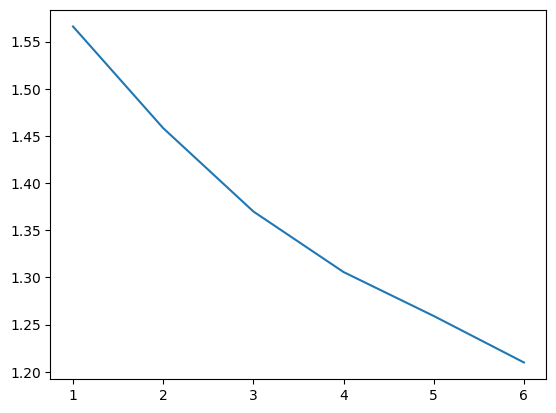

	Epoch [7/30], Step [1/41], Loss: 1.1871
	Epoch [7/30], Step [2/41], Loss: 1.1593
	Epoch [7/30], Step [3/41], Loss: 1.1170
	Epoch [7/30], Step [4/41], Loss: 1.1051
	Epoch [7/30], Step [5/41], Loss: 1.2115
	Epoch [7/30], Step [6/41], Loss: 1.1452
	Epoch [7/30], Step [7/41], Loss: 1.1235
	Epoch [7/30], Step [8/41], Loss: 1.1139
	Epoch [7/30], Step [9/41], Loss: 1.1275
	Epoch [7/30], Step [10/41], Loss: 1.1984
	Epoch [7/30], Step [11/41], Loss: 1.1889
	Epoch [7/30], Step [12/41], Loss: 1.1027
	Epoch [7/30], Step [13/41], Loss: 1.2572
	Epoch [7/30], Step [14/41], Loss: 1.1489
	Epoch [7/30], Step [15/41], Loss: 1.1836
	Epoch [7/30], Step [16/41], Loss: 1.2171
	Epoch [7/30], Step [17/41], Loss: 1.2056
	Epoch [7/30], Step [18/41], Loss: 1.1531
	Epoch [7/30], Step [19/41], Loss: 1.2081
	Epoch [7/30], Step [20/41], Loss: 1.1561
	Epoch [7/30], Step [21/41], Loss: 1.1699
	Epoch [7/30], Step [22/41], Loss: 1.2151
	Epoch [7/30], Step [23/41], Loss: 1.1332
	Epoch [7/30], Step [24/41], Loss: 1.1803
	

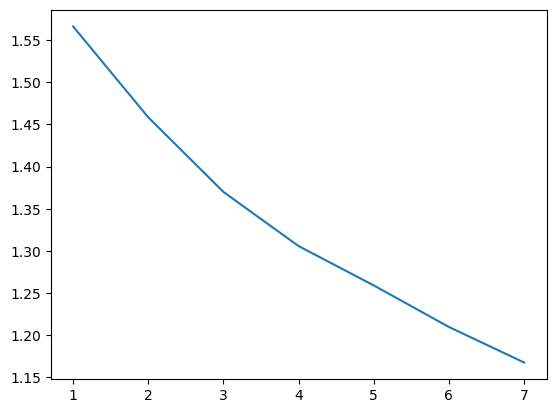

	Epoch [8/30], Step [1/41], Loss: 1.1347
	Epoch [8/30], Step [2/41], Loss: 1.0923
	Epoch [8/30], Step [3/41], Loss: 1.1227
	Epoch [8/30], Step [4/41], Loss: 1.1515
	Epoch [8/30], Step [5/41], Loss: 1.1754
	Epoch [8/30], Step [6/41], Loss: 1.1420
	Epoch [8/30], Step [7/41], Loss: 1.1286
	Epoch [8/30], Step [8/41], Loss: 1.0775
	Epoch [8/30], Step [9/41], Loss: 1.1007
	Epoch [8/30], Step [10/41], Loss: 1.1369
	Epoch [8/30], Step [11/41], Loss: 1.1194
	Epoch [8/30], Step [12/41], Loss: 1.1469
	Epoch [8/30], Step [13/41], Loss: 1.1295
	Epoch [8/30], Step [14/41], Loss: 1.1831
	Epoch [8/30], Step [15/41], Loss: 1.0977
	Epoch [8/30], Step [16/41], Loss: 1.0818
	Epoch [8/30], Step [17/41], Loss: 1.1833
	Epoch [8/30], Step [18/41], Loss: 1.0703
	Epoch [8/30], Step [19/41], Loss: 1.1185
	Epoch [8/30], Step [20/41], Loss: 1.1346
	Epoch [8/30], Step [21/41], Loss: 1.1748
	Epoch [8/30], Step [22/41], Loss: 1.1790
	Epoch [8/30], Step [23/41], Loss: 1.1189
	Epoch [8/30], Step [24/41], Loss: 1.0871
	

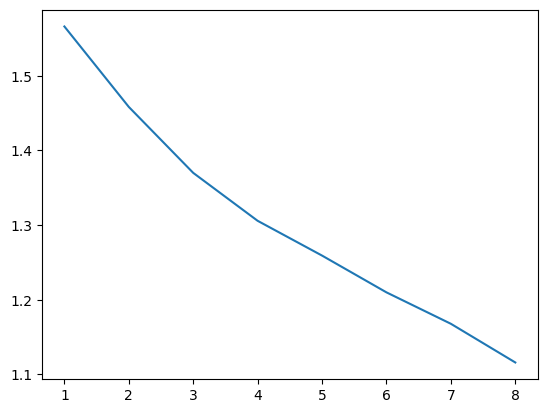

	Epoch [9/30], Step [1/41], Loss: 1.1345
	Epoch [9/30], Step [2/41], Loss: 1.0367
	Epoch [9/30], Step [3/41], Loss: 1.0606
	Epoch [9/30], Step [4/41], Loss: 1.0908
	Epoch [9/30], Step [5/41], Loss: 1.0686
	Epoch [9/30], Step [6/41], Loss: 1.1199
	Epoch [9/30], Step [7/41], Loss: 1.1453
	Epoch [9/30], Step [8/41], Loss: 1.0953
	Epoch [9/30], Step [9/41], Loss: 1.0390
	Epoch [9/30], Step [10/41], Loss: 1.0567
	Epoch [9/30], Step [11/41], Loss: 1.0378
	Epoch [9/30], Step [12/41], Loss: 1.1043
	Epoch [9/30], Step [13/41], Loss: 1.0758
	Epoch [9/30], Step [14/41], Loss: 1.1236
	Epoch [9/30], Step [15/41], Loss: 1.1019
	Epoch [9/30], Step [16/41], Loss: 1.0570
	Epoch [9/30], Step [17/41], Loss: 1.0583
	Epoch [9/30], Step [18/41], Loss: 1.0586
	Epoch [9/30], Step [19/41], Loss: 1.0673
	Epoch [9/30], Step [20/41], Loss: 1.1192
	Epoch [9/30], Step [21/41], Loss: 1.1693
	Epoch [9/30], Step [22/41], Loss: 1.1990
	Epoch [9/30], Step [23/41], Loss: 1.0427
	Epoch [9/30], Step [24/41], Loss: 1.0483
	

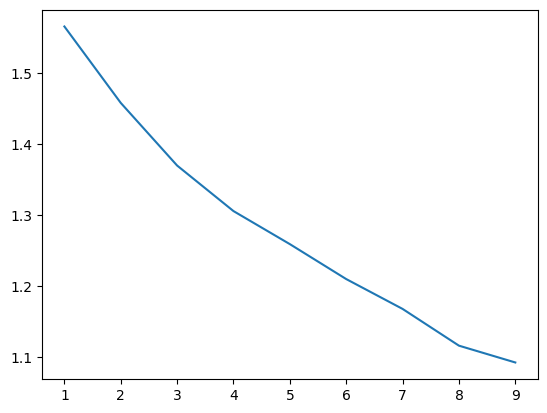

	Epoch [10/30], Step [1/41], Loss: 1.0837
	Epoch [10/30], Step [2/41], Loss: 1.0562
	Epoch [10/30], Step [3/41], Loss: 1.1048
	Epoch [10/30], Step [4/41], Loss: 1.0689
	Epoch [10/30], Step [5/41], Loss: 1.0437
	Epoch [10/30], Step [6/41], Loss: 1.1058
	Epoch [10/30], Step [7/41], Loss: 1.0338
	Epoch [10/30], Step [8/41], Loss: 1.0453
	Epoch [10/30], Step [9/41], Loss: 1.0688
	Epoch [10/30], Step [10/41], Loss: 1.0935
	Epoch [10/30], Step [11/41], Loss: 1.0153
	Epoch [10/30], Step [12/41], Loss: 1.0972
	Epoch [10/30], Step [13/41], Loss: 1.0647
	Epoch [10/30], Step [14/41], Loss: 1.1166
	Epoch [10/30], Step [15/41], Loss: 1.0775
	Epoch [10/30], Step [16/41], Loss: 1.0683
	Epoch [10/30], Step [17/41], Loss: 1.0013
	Epoch [10/30], Step [18/41], Loss: 1.0641
	Epoch [10/30], Step [19/41], Loss: 1.0600
	Epoch [10/30], Step [20/41], Loss: 1.0847
	Epoch [10/30], Step [21/41], Loss: 1.0153
	Epoch [10/30], Step [22/41], Loss: 1.0311
	Epoch [10/30], Step [23/41], Loss: 1.0623
	Epoch [10/30], Step

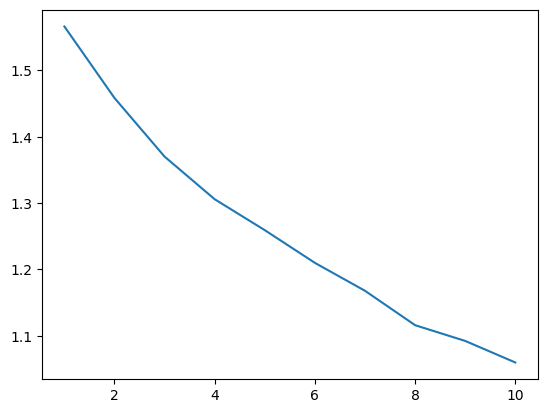

	Epoch [11/30], Step [1/41], Loss: 1.0305
	Epoch [11/30], Step [2/41], Loss: 1.0343
	Epoch [11/30], Step [3/41], Loss: 1.0241
	Epoch [11/30], Step [4/41], Loss: 1.0228
	Epoch [11/30], Step [5/41], Loss: 1.0090
	Epoch [11/30], Step [6/41], Loss: 1.0428
	Epoch [11/30], Step [7/41], Loss: 1.0313
	Epoch [11/30], Step [8/41], Loss: 1.0084
	Epoch [11/30], Step [9/41], Loss: 1.0192
	Epoch [11/30], Step [10/41], Loss: 1.0147
	Epoch [11/30], Step [11/41], Loss: 1.0664
	Epoch [11/30], Step [12/41], Loss: 1.0788
	Epoch [11/30], Step [13/41], Loss: 1.0595
	Epoch [11/30], Step [14/41], Loss: 0.9867
	Epoch [11/30], Step [15/41], Loss: 1.0095
	Epoch [11/30], Step [16/41], Loss: 1.0855
	Epoch [11/30], Step [17/41], Loss: 1.0745
	Epoch [11/30], Step [18/41], Loss: 0.9835
	Epoch [11/30], Step [19/41], Loss: 1.0535
	Epoch [11/30], Step [20/41], Loss: 1.0594
	Epoch [11/30], Step [21/41], Loss: 1.0016
	Epoch [11/30], Step [22/41], Loss: 1.0285
	Epoch [11/30], Step [23/41], Loss: 1.0797
	Epoch [11/30], Step

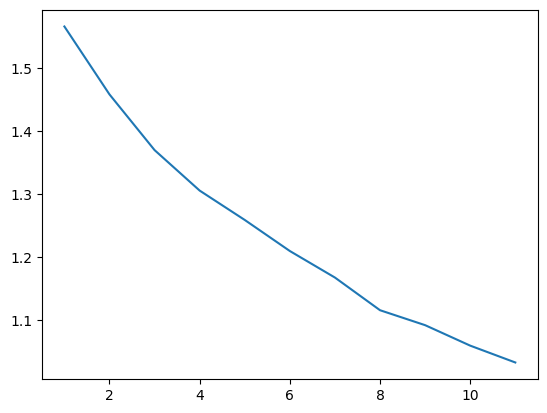

	Epoch [12/30], Step [1/41], Loss: 1.0047
	Epoch [12/30], Step [2/41], Loss: 1.0036
	Epoch [12/30], Step [3/41], Loss: 1.0011
	Epoch [12/30], Step [4/41], Loss: 0.9914
	Epoch [12/30], Step [5/41], Loss: 1.0123
	Epoch [12/30], Step [6/41], Loss: 0.9969
	Epoch [12/30], Step [7/41], Loss: 0.9781
	Epoch [12/30], Step [8/41], Loss: 0.9904
	Epoch [12/30], Step [9/41], Loss: 1.0417
	Epoch [12/30], Step [10/41], Loss: 0.9824
	Epoch [12/30], Step [11/41], Loss: 1.0063
	Epoch [12/30], Step [12/41], Loss: 1.0167
	Epoch [12/30], Step [13/41], Loss: 1.0225
	Epoch [12/30], Step [14/41], Loss: 0.9867
	Epoch [12/30], Step [15/41], Loss: 1.0488
	Epoch [12/30], Step [16/41], Loss: 0.9844
	Epoch [12/30], Step [17/41], Loss: 1.0603
	Epoch [12/30], Step [18/41], Loss: 0.9649
	Epoch [12/30], Step [19/41], Loss: 1.0167
	Epoch [12/30], Step [20/41], Loss: 1.0106
	Epoch [12/30], Step [21/41], Loss: 1.0376
	Epoch [12/30], Step [22/41], Loss: 1.0112
	Epoch [12/30], Step [23/41], Loss: 0.9996
	Epoch [12/30], Step

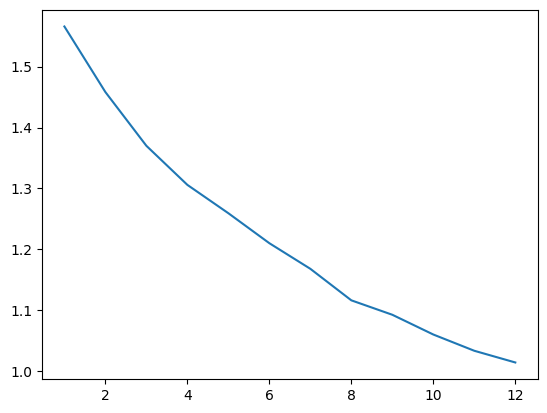

	Epoch [13/30], Step [1/41], Loss: 0.9766
	Epoch [13/30], Step [2/41], Loss: 0.9591
	Epoch [13/30], Step [3/41], Loss: 1.0340
	Epoch [13/30], Step [4/41], Loss: 1.0210
	Epoch [13/30], Step [5/41], Loss: 1.0443
	Epoch [13/30], Step [6/41], Loss: 1.0323
	Epoch [13/30], Step [7/41], Loss: 1.0347
	Epoch [13/30], Step [8/41], Loss: 0.9777
	Epoch [13/30], Step [9/41], Loss: 0.9663
	Epoch [13/30], Step [10/41], Loss: 0.9788
	Epoch [13/30], Step [11/41], Loss: 0.9898
	Epoch [13/30], Step [12/41], Loss: 1.0874
	Epoch [13/30], Step [13/41], Loss: 1.0816
	Epoch [13/30], Step [14/41], Loss: 1.0467
	Epoch [13/30], Step [15/41], Loss: 0.9781
	Epoch [13/30], Step [16/41], Loss: 0.9955
	Epoch [13/30], Step [17/41], Loss: 0.9901
	Epoch [13/30], Step [18/41], Loss: 0.9912
	Epoch [13/30], Step [19/41], Loss: 1.0237
	Epoch [13/30], Step [20/41], Loss: 1.0027
	Epoch [13/30], Step [21/41], Loss: 0.9683
	Epoch [13/30], Step [22/41], Loss: 0.9754
	Epoch [13/30], Step [23/41], Loss: 1.0022
	Epoch [13/30], Step

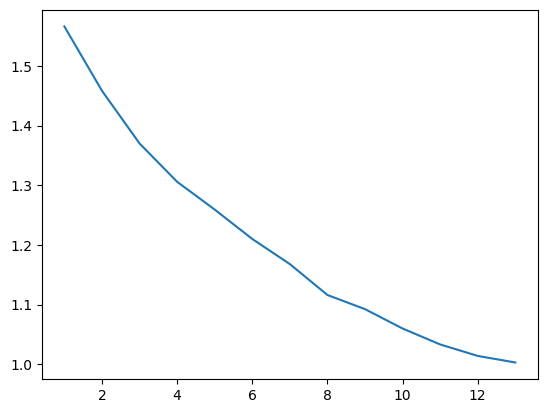

	Epoch [14/30], Step [1/41], Loss: 1.0237
	Epoch [14/30], Step [2/41], Loss: 0.9618
	Epoch [14/30], Step [3/41], Loss: 1.0033
	Epoch [14/30], Step [4/41], Loss: 0.9561
	Epoch [14/30], Step [5/41], Loss: 0.9633
	Epoch [14/30], Step [6/41], Loss: 0.9768
	Epoch [14/30], Step [7/41], Loss: 1.0260
	Epoch [14/30], Step [8/41], Loss: 0.9669
	Epoch [14/30], Step [9/41], Loss: 0.9911
	Epoch [14/30], Step [10/41], Loss: 1.0070
	Epoch [14/30], Step [11/41], Loss: 1.0085
	Epoch [14/30], Step [12/41], Loss: 0.9992
	Epoch [14/30], Step [13/41], Loss: 0.9542
	Epoch [14/30], Step [14/41], Loss: 0.9919
	Epoch [14/30], Step [15/41], Loss: 0.9500
	Epoch [14/30], Step [16/41], Loss: 0.9812
	Epoch [14/30], Step [17/41], Loss: 0.9611
	Epoch [14/30], Step [18/41], Loss: 1.0201
	Epoch [14/30], Step [19/41], Loss: 0.9594
	Epoch [14/30], Step [20/41], Loss: 0.9698
	Epoch [14/30], Step [21/41], Loss: 1.0103
	Epoch [14/30], Step [22/41], Loss: 1.0236
	Epoch [14/30], Step [23/41], Loss: 0.9994
	Epoch [14/30], Step

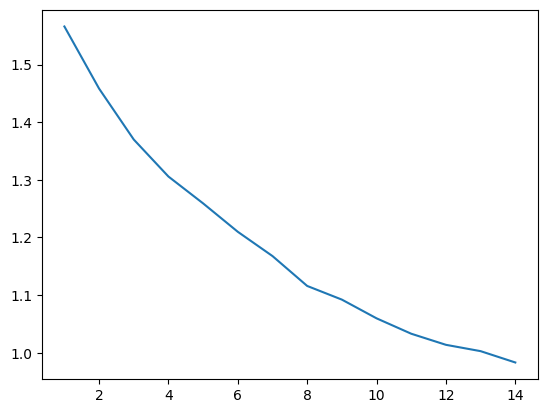

	Epoch [15/30], Step [1/41], Loss: 0.9576
	Epoch [15/30], Step [2/41], Loss: 0.9708
	Epoch [15/30], Step [3/41], Loss: 0.9654
	Epoch [15/30], Step [4/41], Loss: 1.0483
	Epoch [15/30], Step [5/41], Loss: 0.9698
	Epoch [15/30], Step [6/41], Loss: 0.9751
	Epoch [15/30], Step [7/41], Loss: 0.9759
	Epoch [15/30], Step [8/41], Loss: 0.9684
	Epoch [15/30], Step [9/41], Loss: 0.9409
	Epoch [15/30], Step [10/41], Loss: 0.9735
	Epoch [15/30], Step [11/41], Loss: 1.0059
	Epoch [15/30], Step [12/41], Loss: 0.9691
	Epoch [15/30], Step [13/41], Loss: 0.9825
	Epoch [15/30], Step [14/41], Loss: 0.9693
	Epoch [15/30], Step [15/41], Loss: 0.9585
	Epoch [15/30], Step [16/41], Loss: 1.0157
	Epoch [15/30], Step [17/41], Loss: 1.0486
	Epoch [15/30], Step [18/41], Loss: 0.9425
	Epoch [15/30], Step [19/41], Loss: 0.9866
	Epoch [15/30], Step [20/41], Loss: 0.9658
	Epoch [15/30], Step [21/41], Loss: 0.9873
	Epoch [15/30], Step [22/41], Loss: 0.9884
	Epoch [15/30], Step [23/41], Loss: 0.9989
	Epoch [15/30], Step

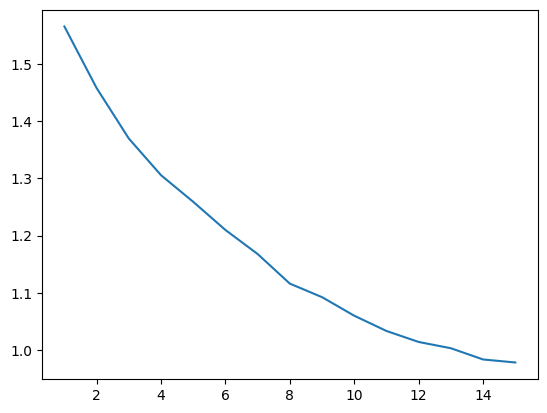

	Epoch [16/30], Step [1/41], Loss: 0.9477
	Epoch [16/30], Step [2/41], Loss: 0.9498
	Epoch [16/30], Step [3/41], Loss: 0.9654
	Epoch [16/30], Step [4/41], Loss: 1.0334
	Epoch [16/30], Step [5/41], Loss: 0.9811
	Epoch [16/30], Step [6/41], Loss: 0.9909
	Epoch [16/30], Step [7/41], Loss: 0.9411
	Epoch [16/30], Step [8/41], Loss: 0.9405
	Epoch [16/30], Step [9/41], Loss: 0.9672
	Epoch [16/30], Step [10/41], Loss: 1.0019
	Epoch [16/30], Step [11/41], Loss: 0.9517
	Epoch [16/30], Step [12/41], Loss: 0.9657
	Epoch [16/30], Step [13/41], Loss: 0.9823
	Epoch [16/30], Step [14/41], Loss: 1.0013
	Epoch [16/30], Step [15/41], Loss: 0.9377
	Epoch [16/30], Step [16/41], Loss: 0.9622
	Epoch [16/30], Step [17/41], Loss: 0.9261
	Epoch [16/30], Step [18/41], Loss: 0.9342
	Epoch [16/30], Step [19/41], Loss: 0.9511
	Epoch [16/30], Step [20/41], Loss: 0.9780
	Epoch [16/30], Step [21/41], Loss: 0.9566
	Epoch [16/30], Step [22/41], Loss: 0.9573
	Epoch [16/30], Step [23/41], Loss: 0.9395
	Epoch [16/30], Step

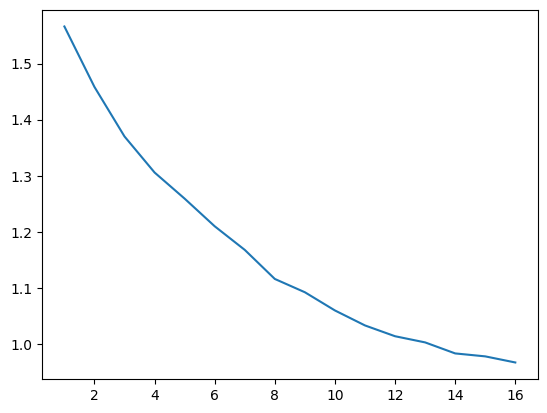

	Epoch [17/30], Step [1/41], Loss: 0.9885
	Epoch [17/30], Step [2/41], Loss: 0.9553
	Epoch [17/30], Step [3/41], Loss: 0.9361
	Epoch [17/30], Step [4/41], Loss: 0.9652
	Epoch [17/30], Step [5/41], Loss: 0.9922
	Epoch [17/30], Step [6/41], Loss: 0.9328
	Epoch [17/30], Step [7/41], Loss: 0.9781
	Epoch [17/30], Step [8/41], Loss: 0.9872
	Epoch [17/30], Step [9/41], Loss: 0.9520
	Epoch [17/30], Step [10/41], Loss: 0.9833
	Epoch [17/30], Step [11/41], Loss: 0.9567
	Epoch [17/30], Step [12/41], Loss: 0.9592
	Epoch [17/30], Step [13/41], Loss: 0.9397
	Epoch [17/30], Step [14/41], Loss: 0.9707
	Epoch [17/30], Step [15/41], Loss: 0.9836
	Epoch [17/30], Step [16/41], Loss: 0.9757
	Epoch [17/30], Step [17/41], Loss: 0.9458
	Epoch [17/30], Step [18/41], Loss: 0.9343
	Epoch [17/30], Step [19/41], Loss: 0.9701
	Epoch [17/30], Step [20/41], Loss: 0.9558
	Epoch [17/30], Step [21/41], Loss: 0.9353
	Epoch [17/30], Step [22/41], Loss: 0.9463
	Epoch [17/30], Step [23/41], Loss: 0.9543
	Epoch [17/30], Step

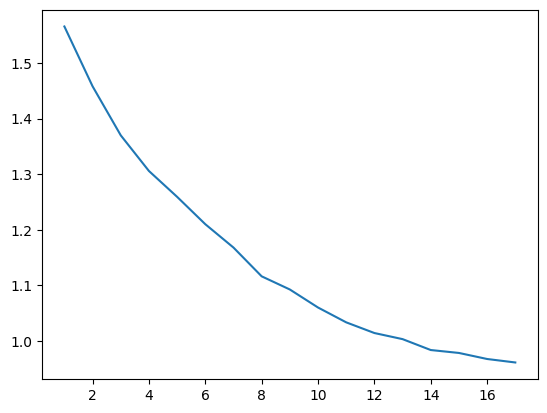

	Epoch [18/30], Step [1/41], Loss: 0.9741
	Epoch [18/30], Step [2/41], Loss: 0.9543
	Epoch [18/30], Step [3/41], Loss: 0.9543
	Epoch [18/30], Step [4/41], Loss: 0.9406
	Epoch [18/30], Step [5/41], Loss: 0.9393
	Epoch [18/30], Step [6/41], Loss: 0.9448
	Epoch [18/30], Step [7/41], Loss: 0.9564
	Epoch [18/30], Step [8/41], Loss: 0.9702
	Epoch [18/30], Step [9/41], Loss: 0.9351
	Epoch [18/30], Step [10/41], Loss: 0.9312
	Epoch [18/30], Step [11/41], Loss: 0.9417
	Epoch [18/30], Step [12/41], Loss: 0.9982
	Epoch [18/30], Step [13/41], Loss: 0.9479
	Epoch [18/30], Step [14/41], Loss: 0.9900
	Epoch [18/30], Step [15/41], Loss: 0.9337
	Epoch [18/30], Step [16/41], Loss: 0.9317
	Epoch [18/30], Step [17/41], Loss: 0.9482
	Epoch [18/30], Step [18/41], Loss: 0.9412
	Epoch [18/30], Step [19/41], Loss: 0.9346
	Epoch [18/30], Step [20/41], Loss: 0.9345
	Epoch [18/30], Step [21/41], Loss: 0.9620
	Epoch [18/30], Step [22/41], Loss: 0.9501
	Epoch [18/30], Step [23/41], Loss: 0.9389
	Epoch [18/30], Step

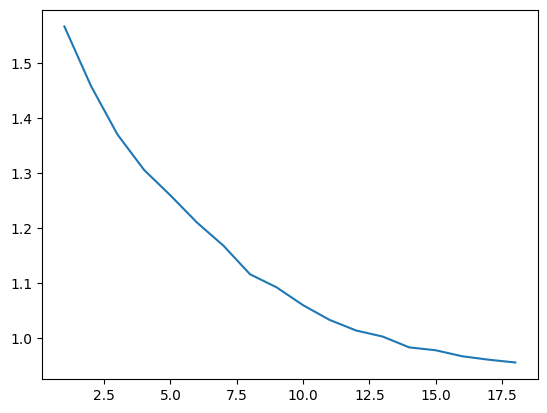

	Epoch [19/30], Step [1/41], Loss: 0.9710
	Epoch [19/30], Step [2/41], Loss: 0.9521
	Epoch [19/30], Step [3/41], Loss: 0.9433
	Epoch [19/30], Step [4/41], Loss: 0.9431
	Epoch [19/30], Step [5/41], Loss: 0.9470
	Epoch [19/30], Step [6/41], Loss: 0.9732
	Epoch [19/30], Step [7/41], Loss: 0.9454
	Epoch [19/30], Step [8/41], Loss: 0.9482
	Epoch [19/30], Step [9/41], Loss: 0.9336
	Epoch [19/30], Step [10/41], Loss: 0.9257
	Epoch [19/30], Step [11/41], Loss: 0.9257
	Epoch [19/30], Step [12/41], Loss: 0.9755
	Epoch [19/30], Step [13/41], Loss: 0.9591
	Epoch [19/30], Step [14/41], Loss: 0.9437
	Epoch [19/30], Step [15/41], Loss: 0.9865
	Epoch [19/30], Step [16/41], Loss: 0.9788
	Epoch [19/30], Step [17/41], Loss: 0.9792
	Epoch [19/30], Step [18/41], Loss: 0.9880
	Epoch [19/30], Step [19/41], Loss: 0.9269
	Epoch [19/30], Step [20/41], Loss: 0.9357
	Epoch [19/30], Step [21/41], Loss: 0.9409
	Epoch [19/30], Step [22/41], Loss: 0.9432
	Epoch [19/30], Step [23/41], Loss: 0.9817
	Epoch [19/30], Step

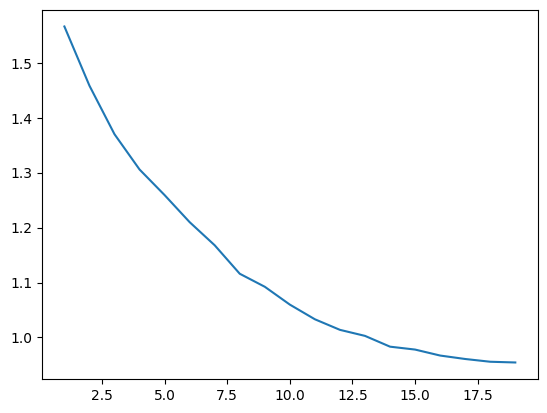

	Epoch [20/30], Step [1/41], Loss: 0.9502
	Epoch [20/30], Step [2/41], Loss: 0.9937
	Epoch [20/30], Step [3/41], Loss: 1.0050
	Epoch [20/30], Step [4/41], Loss: 0.9679
	Epoch [20/30], Step [5/41], Loss: 0.9286
	Epoch [20/30], Step [6/41], Loss: 0.9882
	Epoch [20/30], Step [7/41], Loss: 0.9321
	Epoch [20/30], Step [8/41], Loss: 0.9406
	Epoch [20/30], Step [9/41], Loss: 0.9903
	Epoch [20/30], Step [10/41], Loss: 0.9493
	Epoch [20/30], Step [11/41], Loss: 0.9596
	Epoch [20/30], Step [12/41], Loss: 0.9396
	Epoch [20/30], Step [13/41], Loss: 0.9629
	Epoch [20/30], Step [14/41], Loss: 0.9419
	Epoch [20/30], Step [15/41], Loss: 0.9452
	Epoch [20/30], Step [16/41], Loss: 0.9870
	Epoch [20/30], Step [17/41], Loss: 0.9453
	Epoch [20/30], Step [18/41], Loss: 0.9305
	Epoch [20/30], Step [19/41], Loss: 0.9543
	Epoch [20/30], Step [20/41], Loss: 0.9586
	Epoch [20/30], Step [21/41], Loss: 0.9709
	Epoch [20/30], Step [22/41], Loss: 0.9629
	Epoch [20/30], Step [23/41], Loss: 0.9618
	Epoch [20/30], Step

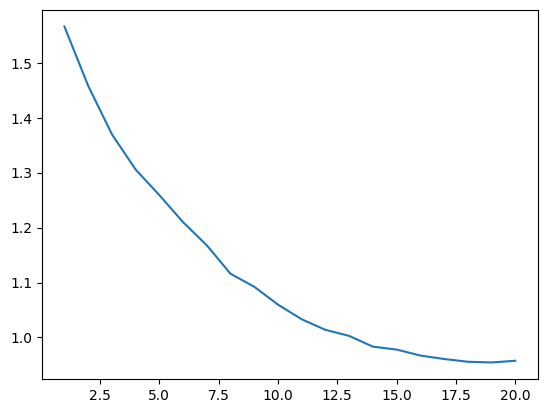

	Epoch [21/30], Step [1/41], Loss: 0.9744
	Epoch [21/30], Step [2/41], Loss: 0.9319
	Epoch [21/30], Step [3/41], Loss: 0.9586
	Epoch [21/30], Step [4/41], Loss: 0.9471
	Epoch [21/30], Step [5/41], Loss: 0.9633
	Epoch [21/30], Step [6/41], Loss: 0.9591
	Epoch [21/30], Step [7/41], Loss: 0.9576
	Epoch [21/30], Step [8/41], Loss: 0.9607
	Epoch [21/30], Step [9/41], Loss: 0.9289
	Epoch [21/30], Step [10/41], Loss: 0.9401
	Epoch [21/30], Step [11/41], Loss: 0.9332
	Epoch [21/30], Step [12/41], Loss: 0.9633
	Epoch [21/30], Step [13/41], Loss: 0.9281
	Epoch [21/30], Step [14/41], Loss: 0.9552
	Epoch [21/30], Step [15/41], Loss: 0.9241
	Epoch [21/30], Step [16/41], Loss: 0.9256
	Epoch [21/30], Step [17/41], Loss: 0.9227
	Epoch [21/30], Step [18/41], Loss: 0.9308
	Epoch [21/30], Step [19/41], Loss: 0.9495
	Epoch [21/30], Step [20/41], Loss: 0.9477
	Epoch [21/30], Step [21/41], Loss: 0.9294
	Epoch [21/30], Step [22/41], Loss: 0.9334
	Epoch [21/30], Step [23/41], Loss: 0.9576
	Epoch [21/30], Step

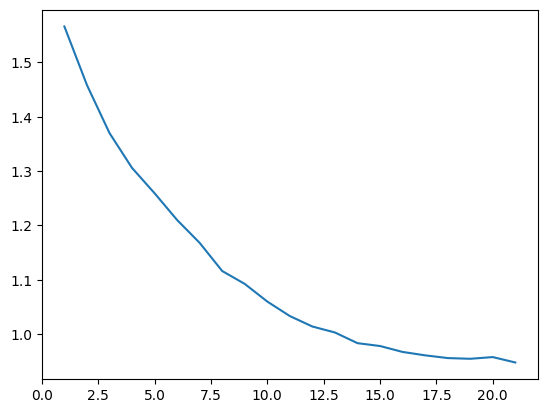

	Epoch [22/30], Step [1/41], Loss: 0.9340
	Epoch [22/30], Step [2/41], Loss: 0.9307
	Epoch [22/30], Step [3/41], Loss: 0.9454
	Epoch [22/30], Step [4/41], Loss: 0.9238
	Epoch [22/30], Step [5/41], Loss: 0.9956
	Epoch [22/30], Step [6/41], Loss: 0.9527
	Epoch [22/30], Step [7/41], Loss: 0.9324
	Epoch [22/30], Step [8/41], Loss: 1.0694
	Epoch [22/30], Step [9/41], Loss: 0.9403
	Epoch [22/30], Step [10/41], Loss: 0.9298
	Epoch [22/30], Step [11/41], Loss: 0.9409
	Epoch [22/30], Step [12/41], Loss: 0.9251
	Epoch [22/30], Step [13/41], Loss: 0.9253
	Epoch [22/30], Step [14/41], Loss: 0.9415
	Epoch [22/30], Step [15/41], Loss: 0.9645
	Epoch [22/30], Step [16/41], Loss: 0.9728
	Epoch [22/30], Step [17/41], Loss: 0.9313
	Epoch [22/30], Step [18/41], Loss: 0.9357
	Epoch [22/30], Step [19/41], Loss: 0.9485
	Epoch [22/30], Step [20/41], Loss: 0.9403
	Epoch [22/30], Step [21/41], Loss: 0.9328
	Epoch [22/30], Step [22/41], Loss: 0.9286
	Epoch [22/30], Step [23/41], Loss: 0.9493
	Epoch [22/30], Step

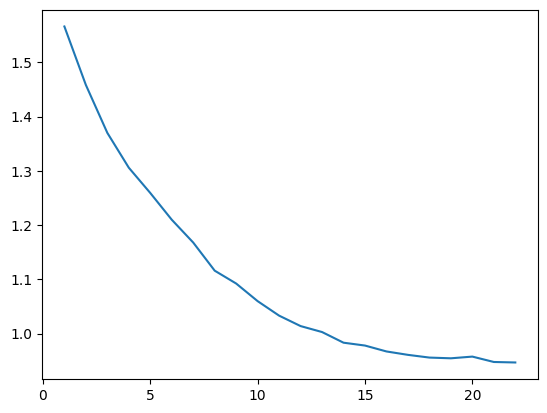

	Epoch [23/30], Step [1/41], Loss: 0.9311
	Epoch [23/30], Step [2/41], Loss: 0.9347
	Epoch [23/30], Step [3/41], Loss: 0.9653
	Epoch [23/30], Step [4/41], Loss: 0.9413
	Epoch [23/30], Step [5/41], Loss: 0.9964
	Epoch [23/30], Step [6/41], Loss: 0.9546
	Epoch [23/30], Step [7/41], Loss: 0.9417
	Epoch [23/30], Step [8/41], Loss: 0.9271
	Epoch [23/30], Step [9/41], Loss: 0.9578
	Epoch [23/30], Step [10/41], Loss: 0.9546
	Epoch [23/30], Step [11/41], Loss: 0.9168
	Epoch [23/30], Step [12/41], Loss: 0.9272
	Epoch [23/30], Step [13/41], Loss: 0.9292
	Epoch [23/30], Step [14/41], Loss: 0.9343
	Epoch [23/30], Step [15/41], Loss: 0.9581
	Epoch [23/30], Step [16/41], Loss: 0.9381
	Epoch [23/30], Step [17/41], Loss: 0.9381
	Epoch [23/30], Step [18/41], Loss: 0.9803
	Epoch [23/30], Step [19/41], Loss: 0.9158
	Epoch [23/30], Step [20/41], Loss: 0.9288
	Epoch [23/30], Step [21/41], Loss: 0.9314
	Epoch [23/30], Step [22/41], Loss: 0.9269
	Epoch [23/30], Step [23/41], Loss: 0.9597
	Epoch [23/30], Step

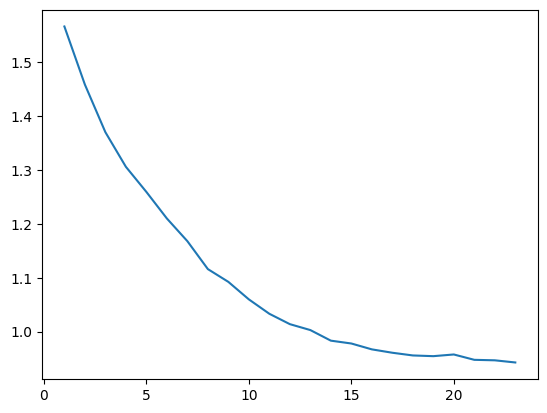

	Epoch [24/30], Step [1/41], Loss: 0.9848
	Epoch [24/30], Step [2/41], Loss: 0.9359
	Epoch [24/30], Step [3/41], Loss: 0.9243
	Epoch [24/30], Step [4/41], Loss: 0.9227
	Epoch [24/30], Step [5/41], Loss: 0.9594
	Epoch [24/30], Step [6/41], Loss: 0.9331
	Epoch [24/30], Step [7/41], Loss: 0.9617
	Epoch [24/30], Step [8/41], Loss: 0.9374
	Epoch [24/30], Step [9/41], Loss: 0.9544
	Epoch [24/30], Step [10/41], Loss: 0.9401
	Epoch [24/30], Step [11/41], Loss: 0.9285
	Epoch [24/30], Step [12/41], Loss: 0.9295
	Epoch [24/30], Step [13/41], Loss: 0.9274
	Epoch [24/30], Step [14/41], Loss: 0.9431
	Epoch [24/30], Step [15/41], Loss: 0.9563
	Epoch [24/30], Step [16/41], Loss: 0.9626
	Epoch [24/30], Step [17/41], Loss: 0.9776
	Epoch [24/30], Step [18/41], Loss: 0.9335
	Epoch [24/30], Step [19/41], Loss: 0.9362
	Epoch [24/30], Step [20/41], Loss: 0.9512
	Epoch [24/30], Step [21/41], Loss: 0.9513
	Epoch [24/30], Step [22/41], Loss: 0.9322
	Epoch [24/30], Step [23/41], Loss: 0.9265
	Epoch [24/30], Step

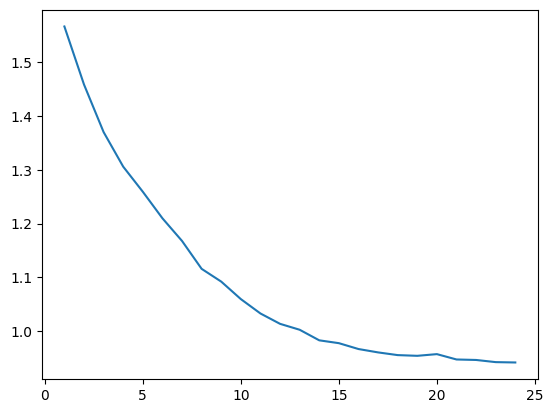

	Epoch [25/30], Step [1/41], Loss: 0.9599
	Epoch [25/30], Step [2/41], Loss: 0.9661
	Epoch [25/30], Step [3/41], Loss: 0.9248
	Epoch [25/30], Step [4/41], Loss: 0.9379
	Epoch [25/30], Step [5/41], Loss: 0.9380
	Epoch [25/30], Step [6/41], Loss: 0.9262
	Epoch [25/30], Step [7/41], Loss: 0.9479
	Epoch [25/30], Step [8/41], Loss: 0.9433
	Epoch [25/30], Step [9/41], Loss: 0.9389
	Epoch [25/30], Step [10/41], Loss: 0.9212
	Epoch [25/30], Step [11/41], Loss: 0.9370
	Epoch [25/30], Step [12/41], Loss: 0.9245
	Epoch [25/30], Step [13/41], Loss: 0.9284
	Epoch [25/30], Step [14/41], Loss: 0.9820
	Epoch [25/30], Step [15/41], Loss: 0.9614
	Epoch [25/30], Step [16/41], Loss: 0.9150
	Epoch [25/30], Step [17/41], Loss: 0.9298
	Epoch [25/30], Step [18/41], Loss: 0.9343
	Epoch [25/30], Step [19/41], Loss: 0.9285
	Epoch [25/30], Step [20/41], Loss: 0.9675
	Epoch [25/30], Step [21/41], Loss: 0.9160
	Epoch [25/30], Step [22/41], Loss: 0.9590
	Epoch [25/30], Step [23/41], Loss: 0.9678
	Epoch [25/30], Step

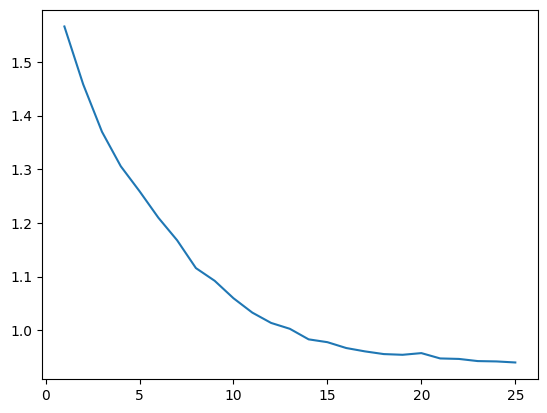

	Epoch [26/30], Step [1/41], Loss: 0.9280
	Epoch [26/30], Step [2/41], Loss: 0.9255
	Epoch [26/30], Step [3/41], Loss: 0.9297
	Epoch [26/30], Step [4/41], Loss: 0.9694
	Epoch [26/30], Step [5/41], Loss: 0.9356
	Epoch [26/30], Step [6/41], Loss: 0.9264
	Epoch [26/30], Step [7/41], Loss: 0.9191
	Epoch [26/30], Step [8/41], Loss: 0.9430
	Epoch [26/30], Step [9/41], Loss: 0.9239
	Epoch [26/30], Step [10/41], Loss: 0.9505
	Epoch [26/30], Step [11/41], Loss: 0.9257
	Epoch [26/30], Step [12/41], Loss: 0.9298
	Epoch [26/30], Step [13/41], Loss: 0.9534
	Epoch [26/30], Step [14/41], Loss: 0.9213
	Epoch [26/30], Step [15/41], Loss: 0.9648
	Epoch [26/30], Step [16/41], Loss: 0.9493
	Epoch [26/30], Step [17/41], Loss: 0.9549
	Epoch [26/30], Step [18/41], Loss: 0.9773
	Epoch [26/30], Step [19/41], Loss: 0.9876
	Epoch [26/30], Step [20/41], Loss: 0.9305
	Epoch [26/30], Step [21/41], Loss: 0.9425
	Epoch [26/30], Step [22/41], Loss: 0.9456
	Epoch [26/30], Step [23/41], Loss: 0.9214
	Epoch [26/30], Step

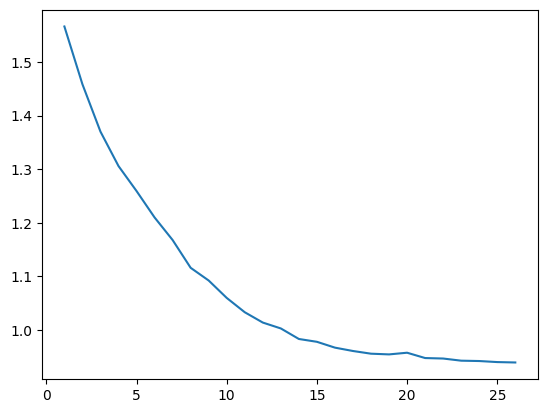

	Epoch [27/30], Step [1/41], Loss: 0.9306
	Epoch [27/30], Step [2/41], Loss: 0.9761
	Epoch [27/30], Step [3/41], Loss: 0.9246
	Epoch [27/30], Step [4/41], Loss: 0.9262
	Epoch [27/30], Step [5/41], Loss: 0.9218
	Epoch [27/30], Step [6/41], Loss: 0.9241
	Epoch [27/30], Step [7/41], Loss: 0.9166
	Epoch [27/30], Step [8/41], Loss: 0.9195
	Epoch [27/30], Step [9/41], Loss: 0.9137
	Epoch [27/30], Step [10/41], Loss: 0.9530
	Epoch [27/30], Step [11/41], Loss: 0.9466
	Epoch [27/30], Step [12/41], Loss: 0.9326
	Epoch [27/30], Step [13/41], Loss: 0.9454
	Epoch [27/30], Step [14/41], Loss: 0.9369
	Epoch [27/30], Step [15/41], Loss: 0.9377
	Epoch [27/30], Step [16/41], Loss: 0.9514
	Epoch [27/30], Step [17/41], Loss: 0.9233
	Epoch [27/30], Step [18/41], Loss: 0.9198
	Epoch [27/30], Step [19/41], Loss: 0.9479
	Epoch [27/30], Step [20/41], Loss: 0.9460
	Epoch [27/30], Step [21/41], Loss: 0.9277
	Epoch [27/30], Step [22/41], Loss: 0.9447
	Epoch [27/30], Step [23/41], Loss: 0.9341
	Epoch [27/30], Step

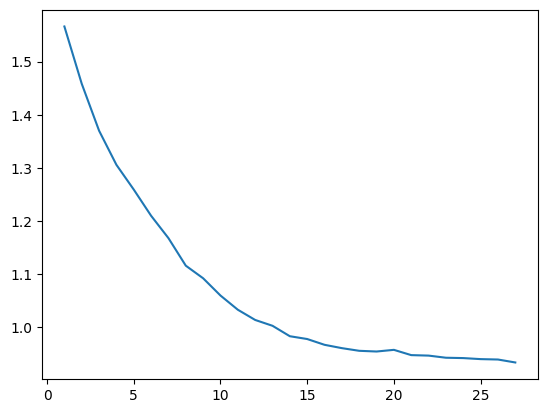

	Epoch [28/30], Step [1/41], Loss: 0.9256
	Epoch [28/30], Step [2/41], Loss: 0.9257
	Epoch [28/30], Step [3/41], Loss: 0.9257
	Epoch [28/30], Step [4/41], Loss: 0.9884
	Epoch [28/30], Step [5/41], Loss: 0.9152
	Epoch [28/30], Step [6/41], Loss: 0.9342
	Epoch [28/30], Step [7/41], Loss: 0.9227
	Epoch [28/30], Step [8/41], Loss: 0.9443
	Epoch [28/30], Step [9/41], Loss: 0.9188
	Epoch [28/30], Step [10/41], Loss: 0.9259
	Epoch [28/30], Step [11/41], Loss: 0.9230
	Epoch [28/30], Step [12/41], Loss: 0.9416
	Epoch [28/30], Step [13/41], Loss: 0.9244
	Epoch [28/30], Step [14/41], Loss: 0.9292
	Epoch [28/30], Step [15/41], Loss: 0.9540
	Epoch [28/30], Step [16/41], Loss: 0.9264
	Epoch [28/30], Step [17/41], Loss: 0.9487
	Epoch [28/30], Step [18/41], Loss: 0.9560
	Epoch [28/30], Step [19/41], Loss: 0.9184
	Epoch [28/30], Step [20/41], Loss: 0.9755
	Epoch [28/30], Step [21/41], Loss: 0.9870
	Epoch [28/30], Step [22/41], Loss: 0.9597
	Epoch [28/30], Step [23/41], Loss: 0.9415
	Epoch [28/30], Step

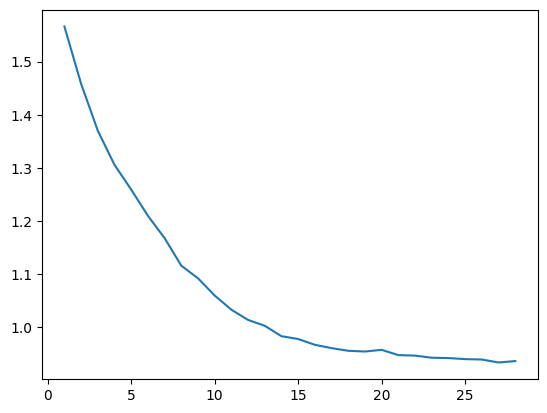

	Epoch [29/30], Step [1/41], Loss: 0.9253
	Epoch [29/30], Step [2/41], Loss: 0.9305
	Epoch [29/30], Step [3/41], Loss: 0.9206
	Epoch [29/30], Step [4/41], Loss: 0.9541
	Epoch [29/30], Step [5/41], Loss: 0.9148
	Epoch [29/30], Step [6/41], Loss: 0.9323
	Epoch [29/30], Step [7/41], Loss: 0.9204
	Epoch [29/30], Step [8/41], Loss: 0.9251
	Epoch [29/30], Step [9/41], Loss: 0.9377
	Epoch [29/30], Step [10/41], Loss: 0.9166
	Epoch [29/30], Step [11/41], Loss: 0.9258
	Epoch [29/30], Step [12/41], Loss: 0.9161
	Epoch [29/30], Step [13/41], Loss: 0.9259
	Epoch [29/30], Step [14/41], Loss: 0.9227
	Epoch [29/30], Step [15/41], Loss: 0.9251
	Epoch [29/30], Step [16/41], Loss: 0.9153
	Epoch [29/30], Step [17/41], Loss: 0.9444
	Epoch [29/30], Step [18/41], Loss: 0.9204
	Epoch [29/30], Step [19/41], Loss: 0.9252
	Epoch [29/30], Step [20/41], Loss: 1.0053
	Epoch [29/30], Step [21/41], Loss: 0.9171
	Epoch [29/30], Step [22/41], Loss: 0.9494
	Epoch [29/30], Step [23/41], Loss: 0.9228
	Epoch [29/30], Step

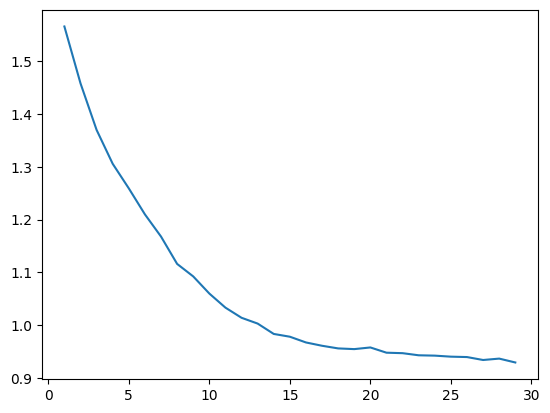

	Epoch [30/30], Step [1/41], Loss: 0.9178
	Epoch [30/30], Step [2/41], Loss: 0.9235
	Epoch [30/30], Step [3/41], Loss: 0.9162
	Epoch [30/30], Step [4/41], Loss: 0.9245
	Epoch [30/30], Step [5/41], Loss: 0.9545
	Epoch [30/30], Step [6/41], Loss: 0.9520
	Epoch [30/30], Step [7/41], Loss: 0.9516
	Epoch [30/30], Step [8/41], Loss: 0.9322
	Epoch [30/30], Step [9/41], Loss: 0.9688
	Epoch [30/30], Step [10/41], Loss: 0.9202
	Epoch [30/30], Step [11/41], Loss: 0.9234
	Epoch [30/30], Step [12/41], Loss: 0.9112
	Epoch [30/30], Step [13/41], Loss: 0.9124
	Epoch [30/30], Step [14/41], Loss: 0.9194
	Epoch [30/30], Step [15/41], Loss: 0.9212
	Epoch [30/30], Step [16/41], Loss: 0.9517
	Epoch [30/30], Step [17/41], Loss: 0.9261
	Epoch [30/30], Step [18/41], Loss: 0.9278
	Epoch [30/30], Step [19/41], Loss: 0.9184
	Epoch [30/30], Step [20/41], Loss: 0.9430
	Epoch [30/30], Step [21/41], Loss: 0.9254
	Epoch [30/30], Step [22/41], Loss: 0.9244
	Epoch [30/30], Step [23/41], Loss: 0.9186
	Epoch [30/30], Step

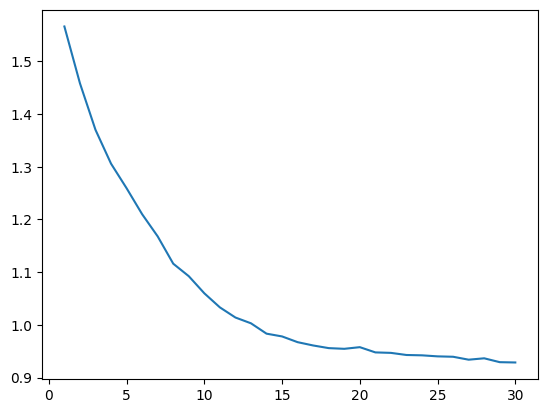

In [ ]:
class MyVGG16(nn.Module):
    def __init__(self, num_classes):
        super(MyVGG16, self).__init__()

        # Load pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)

        # Replace the classifier
        self.vgg16.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.vgg16(x)


model = MyVGG16(num_classes=class_num).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 30
loss_trajectory = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    i = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print('\tEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
              epoch + 1, num_epochs, i + 1, int(len(train_data) / batch_size) + 1, loss.item()))
        i += 1

    epoch_loss = running_loss / len(train_dataloader)
    loss_trajectory.append(epoch_loss)

    epoch_acc = 100 * correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    plt.plot([i + 1 for i in range(len(loss_trajectory))], loss_trajectory)
    plt.show()

# Save the trained model
torch.save(model.state_dict(), 'vgg16_custom.pth')

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # print("image shape:", images.shape)
        outputs = model(images)
        outputs = outputs.squeeze()
        _, predicted = torch.max(outputs.data, 1)

        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print("predicted: ", predicted)
        # print("label: ", labels)

print('Test Accuracy: {}%'.format((correct / total) * 100))

Test Accuracy: 71.1864406779661%


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))


Accuracy: 0.7119
Precision: 0.7433
Recall: 0.7119
F1 Score: 0.7204


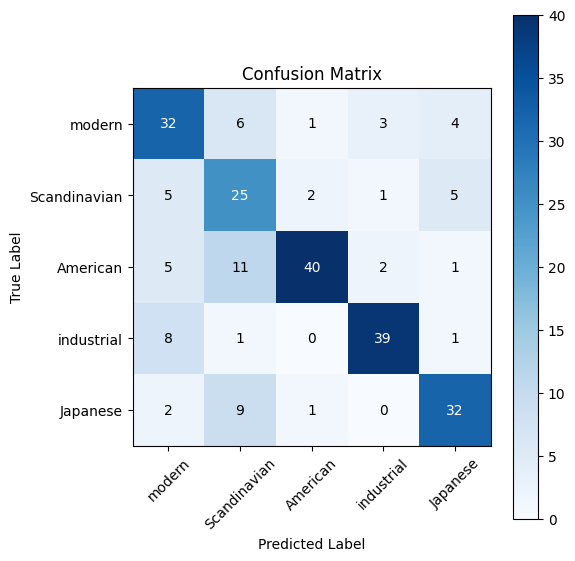

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(style_to_number)), list(style_to_number.keys()), rotation=45)
plt.yticks(np.arange(len(style_to_number)), list(style_to_number.keys()))

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-Score:", f1)

df_metrics = pd.DataFrame({
    "Class": style_to_number.keys(),
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Accuracy": class_accuracy,

})
print(df_metrics.to_string())


          Class  Precision    Recall  F1-Score  Accuracy
0        modern   0.615385  0.695652  0.653061  0.695652
1  Scandinavian   0.480769  0.657895  0.555556  0.657895
2      American   0.909091  0.677966  0.776699  0.677966
3    industrial   0.866667  0.795918  0.829787  0.795918
4      Japanese   0.744186  0.727273  0.735632  0.727273


In [ ]:
df_metrics = df_metrics.round(3)
df_metrics.to_csv('vgg16_metrics.csv', index=False)
torch.save(model.state_dict(), 'vgg16_custom.pth')


### Error analysis

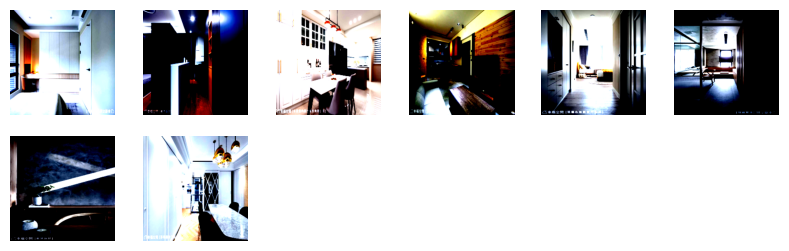

In [ ]:
# prompt: get the 9 pictures that classified as american but actually is scandinavian

import matplotlib.pyplot as plt
# Get the indices of misclassified images
misclassified_indices = []
for i in range(len(y_true)):
    if y_true[i] == 3 and y_pred[i] == 0:
        misclassified_indices.append(i)

# Get the paths of the misclassified images
misclassified_imgs = []
for index in misclassified_indices:
    misclassified_imgs.append(test_data[index][0])
    # print(test_data[index][0].shape)


fig = plt.figure(figsize=(10, 3))

for i in range(len(misclassified_imgs)):
    # Load the image
    # image = Image.open(misclassified_imgs[i].permute(1, 2, 0))

    # Display the image
    ax = fig.add_subplot(int(len(misclassified_imgs) / 6) + 1, 6, i + 1)
    ax.axis('off')
    ax.imshow(misclassified_imgs[i].permute(1, 2, 0))

    # plt.imshow(misclassified_imgs[i].permute(1, 2, 0))
    # plt.show()

plt.show()


## Self VGG16

In [ ]:
num_classes = 5

In [ ]:
class selfVGG16(nn.Module):
  def __init__(self):
    super(selfVGG16, self).__init__()
    self.conv_layers = nn.Sequential(
      # Block 1
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), # 64 * 256 * 256
      nn.ReLU(),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Block 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Block 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Block 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Block 5
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.fc1 = nn.Linear(512 * 7 * 7, 256)
    self.bn = nn.BatchNorm1d(256)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.5)

    self.fc2 = nn.Linear(256, 256)
    self.bn = nn.BatchNorm1d(256)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.5)

    self.fc3 = nn.Linear(256, class_num)
    self.softmax = nn.Softmax(dim=1)
    # self.fcs = nn.Sequential(
    #   nn.Linear(512 * 8 * 8, 4096),
    #   nn.ReLU(),
    #   nn.Dropout(p=0.5),
    #   nn.Linear(4096, 4096),
    #   nn.ReLU(),
    #   nn.Dropout(p=0.5),
    #   nn.Linear(4096, 12),
    # )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.dropout(x)

    x = self.fc2(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.dropout(x)

    # x = self.fc3(x)
    # x = self.softmax(x)
    return x

	Epoch [1/20], Step [1/41], Loss: 1.6036
Epoch [1/20], Loss: 1.6036
	Epoch [1/20], Step [2/41], Loss: 1.6017
	Epoch [1/20], Step [3/41], Loss: 1.5905
	Epoch [1/20], Step [4/41], Loss: 1.5825
	Epoch [1/20], Step [5/41], Loss: 1.5611
	Epoch [1/20], Step [6/41], Loss: 1.5641
	Epoch [1/20], Step [7/41], Loss: 1.5503
	Epoch [1/20], Step [8/41], Loss: 1.5777
	Epoch [1/20], Step [9/41], Loss: 1.5561
	Epoch [1/20], Step [10/41], Loss: 1.5920
	Epoch [1/20], Step [11/41], Loss: 1.5461
	Epoch [1/20], Step [12/41], Loss: 1.5803
	Epoch [1/20], Step [13/41], Loss: 1.5802
	Epoch [1/20], Step [14/41], Loss: 1.5865
	Epoch [1/20], Step [15/41], Loss: 1.5974
	Epoch [1/20], Step [16/41], Loss: 1.5624
	Epoch [1/20], Step [17/41], Loss: 1.5995
	Epoch [1/20], Step [18/41], Loss: 1.5496
	Epoch [1/20], Step [19/41], Loss: 1.5518
	Epoch [1/20], Step [20/41], Loss: 1.5865
	Epoch [1/20], Step [21/41], Loss: 1.5255
	Epoch [1/20], Step [22/41], Loss: 1.5647
	Epoch [1/20], Step [23/41], Loss: 1.5734
	Epoch [1/20], S

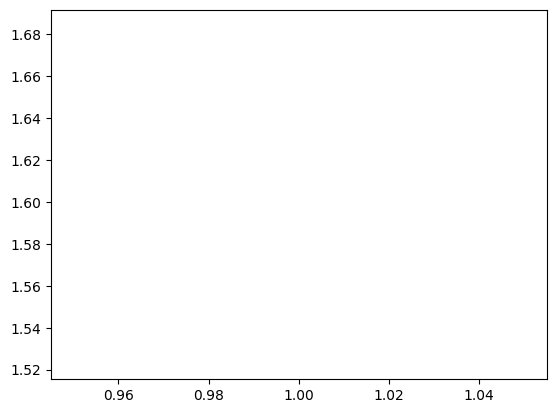

	Epoch [2/20], Step [1/41], Loss: 1.5195
Epoch [2/20], Loss: 1.5195
	Epoch [2/20], Step [2/41], Loss: 1.5363
	Epoch [2/20], Step [3/41], Loss: 1.4311
	Epoch [2/20], Step [4/41], Loss: 1.5296
	Epoch [2/20], Step [5/41], Loss: 1.4968
	Epoch [2/20], Step [6/41], Loss: 1.4784
	Epoch [2/20], Step [7/41], Loss: 1.4548
	Epoch [2/20], Step [8/41], Loss: 1.4878
	Epoch [2/20], Step [9/41], Loss: 1.4944
	Epoch [2/20], Step [10/41], Loss: 1.5469
	Epoch [2/20], Step [11/41], Loss: 1.4699
	Epoch [2/20], Step [12/41], Loss: 1.4673
	Epoch [2/20], Step [13/41], Loss: 1.5218
	Epoch [2/20], Step [14/41], Loss: 1.5771
	Epoch [2/20], Step [15/41], Loss: 1.4964
	Epoch [2/20], Step [16/41], Loss: 1.4526
	Epoch [2/20], Step [17/41], Loss: 1.5067
	Epoch [2/20], Step [18/41], Loss: 1.4825
	Epoch [2/20], Step [19/41], Loss: 1.5002
	Epoch [2/20], Step [20/41], Loss: 1.5086
	Epoch [2/20], Step [21/41], Loss: 1.5184
	Epoch [2/20], Step [22/41], Loss: 1.4997
	Epoch [2/20], Step [23/41], Loss: 1.4612
	Epoch [2/20], S

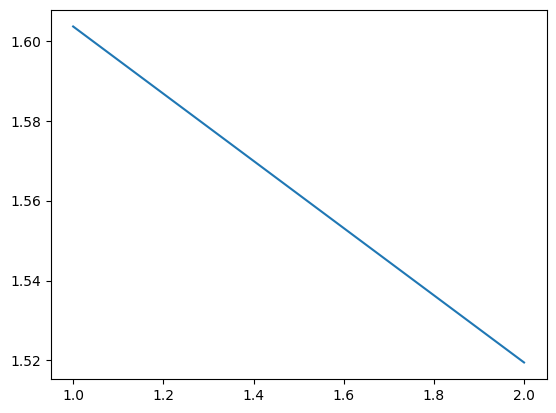

	Epoch [3/20], Step [1/41], Loss: 1.4911
Epoch [3/20], Loss: 1.4911
	Epoch [3/20], Step [2/41], Loss: 1.4295
	Epoch [3/20], Step [3/41], Loss: 1.4420
	Epoch [3/20], Step [4/41], Loss: 1.4579
	Epoch [3/20], Step [5/41], Loss: 1.5039
	Epoch [3/20], Step [6/41], Loss: 1.4994
	Epoch [3/20], Step [7/41], Loss: 1.4755
	Epoch [3/20], Step [8/41], Loss: 1.4230
	Epoch [3/20], Step [9/41], Loss: 1.4966
	Epoch [3/20], Step [10/41], Loss: 1.3994
	Epoch [3/20], Step [11/41], Loss: 1.4261
	Epoch [3/20], Step [12/41], Loss: 1.4482
	Epoch [3/20], Step [13/41], Loss: 1.5330
	Epoch [3/20], Step [14/41], Loss: 1.4594
	Epoch [3/20], Step [15/41], Loss: 1.5109
	Epoch [3/20], Step [16/41], Loss: 1.4663
	Epoch [3/20], Step [17/41], Loss: 1.4329
	Epoch [3/20], Step [18/41], Loss: 1.4470
	Epoch [3/20], Step [19/41], Loss: 1.5376
	Epoch [3/20], Step [20/41], Loss: 1.4632
	Epoch [3/20], Step [21/41], Loss: 1.4099
	Epoch [3/20], Step [22/41], Loss: 1.5056
	Epoch [3/20], Step [23/41], Loss: 1.4835
	Epoch [3/20], S

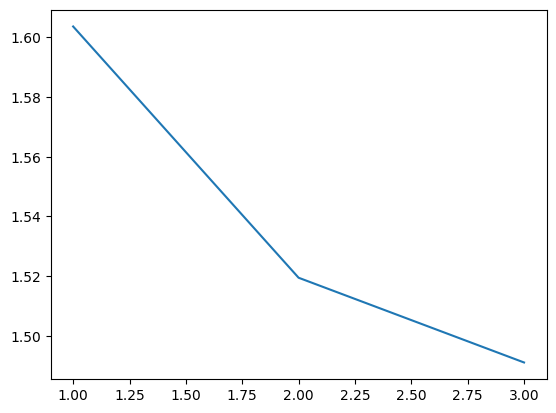

	Epoch [4/20], Step [1/41], Loss: 1.5146
Epoch [4/20], Loss: 1.5146
	Epoch [4/20], Step [2/41], Loss: 1.4909
	Epoch [4/20], Step [3/41], Loss: 1.4228
	Epoch [4/20], Step [4/41], Loss: 1.5051
	Epoch [4/20], Step [5/41], Loss: 1.4719
	Epoch [4/20], Step [6/41], Loss: 1.3926
	Epoch [4/20], Step [7/41], Loss: 1.4125
	Epoch [4/20], Step [8/41], Loss: 1.3667
	Epoch [4/20], Step [9/41], Loss: 1.4799
	Epoch [4/20], Step [10/41], Loss: 1.4703
	Epoch [4/20], Step [11/41], Loss: 1.4801
	Epoch [4/20], Step [12/41], Loss: 1.4573
	Epoch [4/20], Step [13/41], Loss: 1.5101
	Epoch [4/20], Step [14/41], Loss: 1.4540
	Epoch [4/20], Step [15/41], Loss: 1.4417
	Epoch [4/20], Step [16/41], Loss: 1.5114
	Epoch [4/20], Step [17/41], Loss: 1.5067
	Epoch [4/20], Step [18/41], Loss: 1.4595
	Epoch [4/20], Step [19/41], Loss: 1.3786
	Epoch [4/20], Step [20/41], Loss: 1.4961
	Epoch [4/20], Step [21/41], Loss: 1.4359
	Epoch [4/20], Step [22/41], Loss: 1.4160
	Epoch [4/20], Step [23/41], Loss: 1.5038
	Epoch [4/20], S

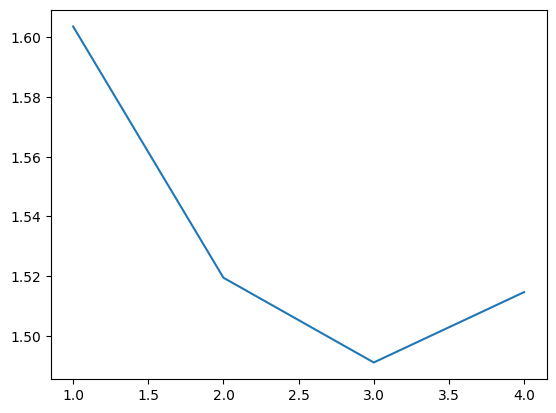

	Epoch [5/20], Step [1/41], Loss: 1.5015
Epoch [5/20], Loss: 1.5015
	Epoch [5/20], Step [2/41], Loss: 1.4540
	Epoch [5/20], Step [3/41], Loss: 1.4119
	Epoch [5/20], Step [4/41], Loss: 1.5166
	Epoch [5/20], Step [5/41], Loss: 1.3877
	Epoch [5/20], Step [6/41], Loss: 1.4680
	Epoch [5/20], Step [7/41], Loss: 1.4913
	Epoch [5/20], Step [8/41], Loss: 1.4201
	Epoch [5/20], Step [9/41], Loss: 1.4776
	Epoch [5/20], Step [10/41], Loss: 1.4542
	Epoch [5/20], Step [11/41], Loss: 1.4411
	Epoch [5/20], Step [12/41], Loss: 1.4937
	Epoch [5/20], Step [13/41], Loss: 1.3824
	Epoch [5/20], Step [14/41], Loss: 1.4003
	Epoch [5/20], Step [15/41], Loss: 1.4113
	Epoch [5/20], Step [16/41], Loss: 1.4697
	Epoch [5/20], Step [17/41], Loss: 1.4818
	Epoch [5/20], Step [18/41], Loss: 1.4876
	Epoch [5/20], Step [19/41], Loss: 1.5039
	Epoch [5/20], Step [20/41], Loss: 1.4437
	Epoch [5/20], Step [21/41], Loss: 1.3540
	Epoch [5/20], Step [22/41], Loss: 1.4499
	Epoch [5/20], Step [23/41], Loss: 1.4763
	Epoch [5/20], S

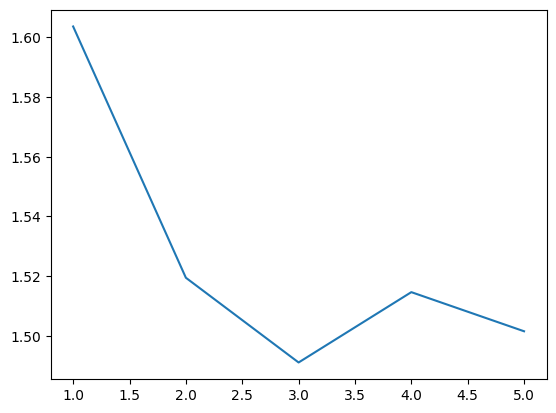

	Epoch [6/20], Step [1/41], Loss: 1.4053
Epoch [6/20], Loss: 1.4053
	Epoch [6/20], Step [2/41], Loss: 1.4469
	Epoch [6/20], Step [3/41], Loss: 1.4853
	Epoch [6/20], Step [4/41], Loss: 1.3879
	Epoch [6/20], Step [5/41], Loss: 1.4946
	Epoch [6/20], Step [6/41], Loss: 1.4177
	Epoch [6/20], Step [7/41], Loss: 1.4181
	Epoch [6/20], Step [8/41], Loss: 1.4232
	Epoch [6/20], Step [9/41], Loss: 1.4666
	Epoch [6/20], Step [10/41], Loss: 1.4057
	Epoch [6/20], Step [11/41], Loss: 1.4253
	Epoch [6/20], Step [12/41], Loss: 1.4280
	Epoch [6/20], Step [13/41], Loss: 1.3883
	Epoch [6/20], Step [14/41], Loss: 1.4956
	Epoch [6/20], Step [15/41], Loss: 1.4515
	Epoch [6/20], Step [16/41], Loss: 1.4848
	Epoch [6/20], Step [17/41], Loss: 1.4423
	Epoch [6/20], Step [18/41], Loss: 1.4403
	Epoch [6/20], Step [19/41], Loss: 1.4564
	Epoch [6/20], Step [20/41], Loss: 1.5202
	Epoch [6/20], Step [21/41], Loss: 1.4765
	Epoch [6/20], Step [22/41], Loss: 1.5178
	Epoch [6/20], Step [23/41], Loss: 1.4746
	Epoch [6/20], S

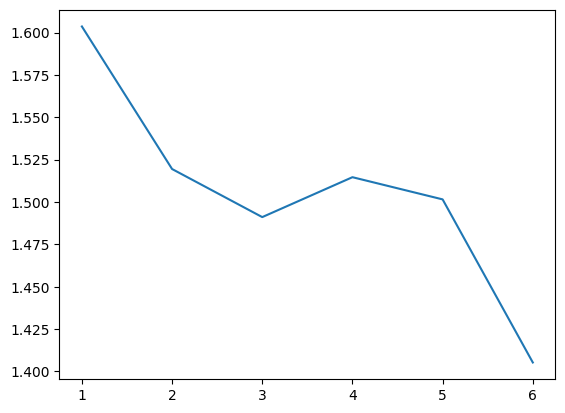

	Epoch [7/20], Step [1/41], Loss: 1.3865
Epoch [7/20], Loss: 1.3865
	Epoch [7/20], Step [2/41], Loss: 1.4412
	Epoch [7/20], Step [3/41], Loss: 1.4327
	Epoch [7/20], Step [4/41], Loss: 1.4651
	Epoch [7/20], Step [5/41], Loss: 1.5126
	Epoch [7/20], Step [6/41], Loss: 1.3498
	Epoch [7/20], Step [7/41], Loss: 1.4237
	Epoch [7/20], Step [8/41], Loss: 1.4947
	Epoch [7/20], Step [9/41], Loss: 1.4073
	Epoch [7/20], Step [10/41], Loss: 1.4199
	Epoch [7/20], Step [11/41], Loss: 1.4018
	Epoch [7/20], Step [12/41], Loss: 1.4416
	Epoch [7/20], Step [13/41], Loss: 1.4238
	Epoch [7/20], Step [14/41], Loss: 1.4740
	Epoch [7/20], Step [15/41], Loss: 1.4406
	Epoch [7/20], Step [16/41], Loss: 1.3780
	Epoch [7/20], Step [17/41], Loss: 1.4266
	Epoch [7/20], Step [18/41], Loss: 1.4488
	Epoch [7/20], Step [19/41], Loss: 1.4409
	Epoch [7/20], Step [20/41], Loss: 1.4315
	Epoch [7/20], Step [21/41], Loss: 1.4524
	Epoch [7/20], Step [22/41], Loss: 1.4101
	Epoch [7/20], Step [23/41], Loss: 1.4245
	Epoch [7/20], S

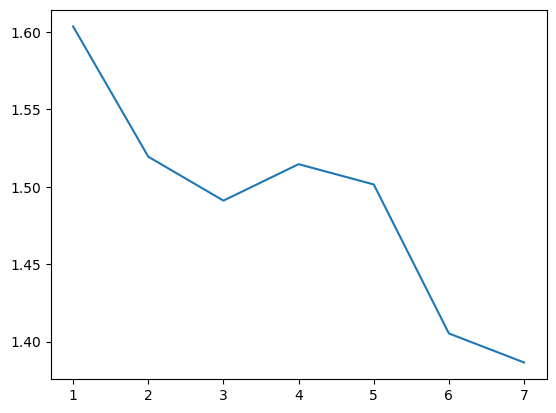

	Epoch [8/20], Step [1/41], Loss: 1.4060
Epoch [8/20], Loss: 1.4060
	Epoch [8/20], Step [2/41], Loss: 1.4591
	Epoch [8/20], Step [3/41], Loss: 1.4633
	Epoch [8/20], Step [4/41], Loss: 1.3816
	Epoch [8/20], Step [5/41], Loss: 1.4469
	Epoch [8/20], Step [6/41], Loss: 1.4374
	Epoch [8/20], Step [7/41], Loss: 1.5577
	Epoch [8/20], Step [8/41], Loss: 1.3877
	Epoch [8/20], Step [9/41], Loss: 1.4944
	Epoch [8/20], Step [10/41], Loss: 1.3909
	Epoch [8/20], Step [11/41], Loss: 1.3888
	Epoch [8/20], Step [12/41], Loss: 1.5271
	Epoch [8/20], Step [13/41], Loss: 1.5664
	Epoch [8/20], Step [14/41], Loss: 1.4509
	Epoch [8/20], Step [15/41], Loss: 1.4729
	Epoch [8/20], Step [16/41], Loss: 1.4023
	Epoch [8/20], Step [17/41], Loss: 1.4126
	Epoch [8/20], Step [18/41], Loss: 1.3709
	Epoch [8/20], Step [19/41], Loss: 1.3938
	Epoch [8/20], Step [20/41], Loss: 1.4358
	Epoch [8/20], Step [21/41], Loss: 1.4393
	Epoch [8/20], Step [22/41], Loss: 1.4421
	Epoch [8/20], Step [23/41], Loss: 1.4510
	Epoch [8/20], S

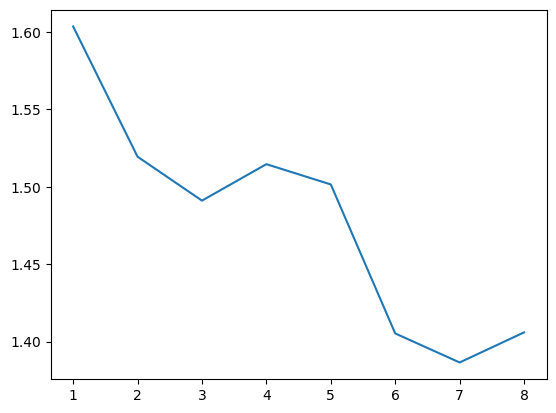

	Epoch [9/20], Step [1/41], Loss: 1.4780
Epoch [9/20], Loss: 1.4780
	Epoch [9/20], Step [2/41], Loss: 1.4004
	Epoch [9/20], Step [3/41], Loss: 1.4237
	Epoch [9/20], Step [4/41], Loss: 1.3998
	Epoch [9/20], Step [5/41], Loss: 1.4895
	Epoch [9/20], Step [6/41], Loss: 1.4784
	Epoch [9/20], Step [7/41], Loss: 1.3458
	Epoch [9/20], Step [8/41], Loss: 1.4223
	Epoch [9/20], Step [9/41], Loss: 1.4494
	Epoch [9/20], Step [10/41], Loss: 1.4510
	Epoch [9/20], Step [11/41], Loss: 1.4416
	Epoch [9/20], Step [12/41], Loss: 1.4081
	Epoch [9/20], Step [13/41], Loss: 1.4449
	Epoch [9/20], Step [14/41], Loss: 1.3672
	Epoch [9/20], Step [15/41], Loss: 1.4386
	Epoch [9/20], Step [16/41], Loss: 1.3688
	Epoch [9/20], Step [17/41], Loss: 1.3870
	Epoch [9/20], Step [18/41], Loss: 1.4258
	Epoch [9/20], Step [19/41], Loss: 1.2949
	Epoch [9/20], Step [20/41], Loss: 1.3975
	Epoch [9/20], Step [21/41], Loss: 1.3909
	Epoch [9/20], Step [22/41], Loss: 1.5012
	Epoch [9/20], Step [23/41], Loss: 1.3531
	Epoch [9/20], S

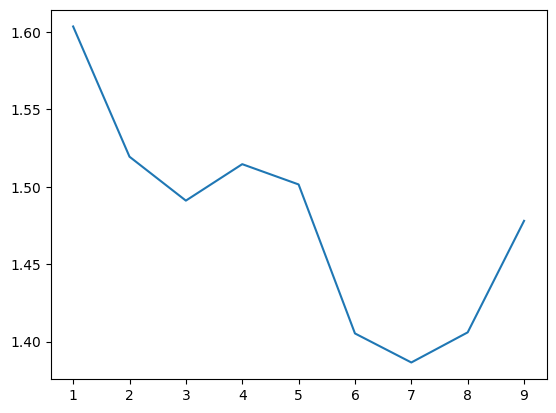

	Epoch [10/20], Step [1/41], Loss: 1.4948
Epoch [10/20], Loss: 1.4948
	Epoch [10/20], Step [2/41], Loss: 1.4977
	Epoch [10/20], Step [3/41], Loss: 1.4194
	Epoch [10/20], Step [4/41], Loss: 1.4163
	Epoch [10/20], Step [5/41], Loss: 1.3905
	Epoch [10/20], Step [6/41], Loss: 1.4985
	Epoch [10/20], Step [7/41], Loss: 1.4588
	Epoch [10/20], Step [8/41], Loss: 1.4523
	Epoch [10/20], Step [9/41], Loss: 1.4139
	Epoch [10/20], Step [10/41], Loss: 1.4630
	Epoch [10/20], Step [11/41], Loss: 1.3903
	Epoch [10/20], Step [12/41], Loss: 1.4093
	Epoch [10/20], Step [13/41], Loss: 1.4004
	Epoch [10/20], Step [14/41], Loss: 1.4517
	Epoch [10/20], Step [15/41], Loss: 1.4690
	Epoch [10/20], Step [16/41], Loss: 1.4363
	Epoch [10/20], Step [17/41], Loss: 1.4724
	Epoch [10/20], Step [18/41], Loss: 1.5097
	Epoch [10/20], Step [19/41], Loss: 1.4443
	Epoch [10/20], Step [20/41], Loss: 1.3141
	Epoch [10/20], Step [21/41], Loss: 1.4207
	Epoch [10/20], Step [22/41], Loss: 1.4218
	Epoch [10/20], Step [23/41], Loss:

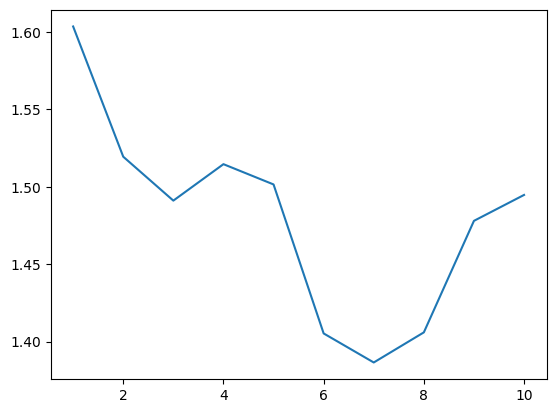

	Epoch [11/20], Step [1/41], Loss: 1.3983
Epoch [11/20], Loss: 1.3983
	Epoch [11/20], Step [2/41], Loss: 1.4379
	Epoch [11/20], Step [3/41], Loss: 1.4595
	Epoch [11/20], Step [4/41], Loss: 1.4404
	Epoch [11/20], Step [5/41], Loss: 1.4293
	Epoch [11/20], Step [6/41], Loss: 1.3620
	Epoch [11/20], Step [7/41], Loss: 1.4122
	Epoch [11/20], Step [8/41], Loss: 1.3905
	Epoch [11/20], Step [9/41], Loss: 1.4647
	Epoch [11/20], Step [10/41], Loss: 1.4452
	Epoch [11/20], Step [11/41], Loss: 1.3829
	Epoch [11/20], Step [12/41], Loss: 1.3982
	Epoch [11/20], Step [13/41], Loss: 1.4328
	Epoch [11/20], Step [14/41], Loss: 1.3408
	Epoch [11/20], Step [15/41], Loss: 1.4356
	Epoch [11/20], Step [16/41], Loss: 1.3788
	Epoch [11/20], Step [17/41], Loss: 1.3645
	Epoch [11/20], Step [18/41], Loss: 1.3876
	Epoch [11/20], Step [19/41], Loss: 1.5288
	Epoch [11/20], Step [20/41], Loss: 1.5251
	Epoch [11/20], Step [21/41], Loss: 1.3998
	Epoch [11/20], Step [22/41], Loss: 1.4157
	Epoch [11/20], Step [23/41], Loss:

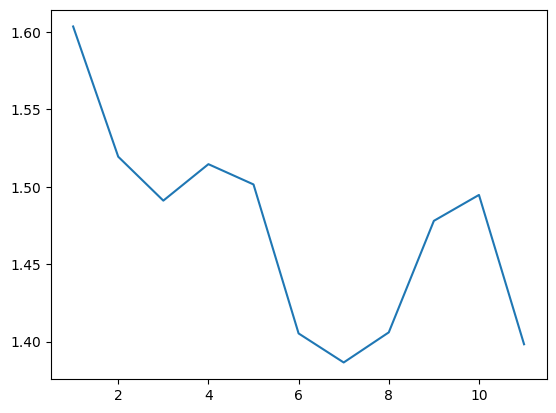

	Epoch [12/20], Step [1/41], Loss: 1.3860
Epoch [12/20], Loss: 1.3860
	Epoch [12/20], Step [2/41], Loss: 1.4033
	Epoch [12/20], Step [3/41], Loss: 1.3642
	Epoch [12/20], Step [4/41], Loss: 1.4312
	Epoch [12/20], Step [5/41], Loss: 1.3505
	Epoch [12/20], Step [6/41], Loss: 1.3822
	Epoch [12/20], Step [7/41], Loss: 1.4148
	Epoch [12/20], Step [8/41], Loss: 1.3799
	Epoch [12/20], Step [9/41], Loss: 1.3375
	Epoch [12/20], Step [10/41], Loss: 1.3958
	Epoch [12/20], Step [11/41], Loss: 1.4327
	Epoch [12/20], Step [12/41], Loss: 1.4446
	Epoch [12/20], Step [13/41], Loss: 1.3895
	Epoch [12/20], Step [14/41], Loss: 1.3651
	Epoch [12/20], Step [15/41], Loss: 1.2944
	Epoch [12/20], Step [16/41], Loss: 1.3954
	Epoch [12/20], Step [17/41], Loss: 1.3780
	Epoch [12/20], Step [18/41], Loss: 1.4593
	Epoch [12/20], Step [19/41], Loss: 1.4726
	Epoch [12/20], Step [20/41], Loss: 1.4787
	Epoch [12/20], Step [21/41], Loss: 1.5078
	Epoch [12/20], Step [22/41], Loss: 1.5094
	Epoch [12/20], Step [23/41], Loss:

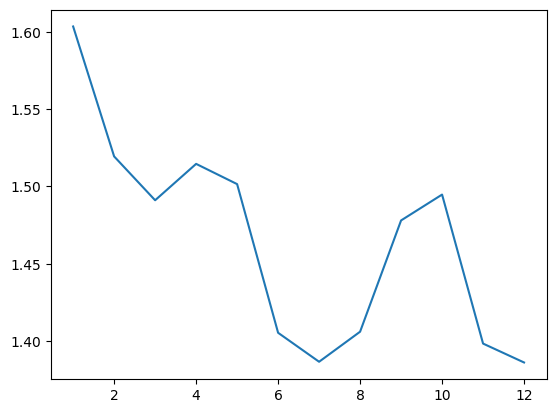

	Epoch [13/20], Step [1/41], Loss: 1.4058
Epoch [13/20], Loss: 1.4058
	Epoch [13/20], Step [2/41], Loss: 1.3703
	Epoch [13/20], Step [3/41], Loss: 1.4983
	Epoch [13/20], Step [4/41], Loss: 1.4352
	Epoch [13/20], Step [5/41], Loss: 1.4589
	Epoch [13/20], Step [6/41], Loss: 1.3949
	Epoch [13/20], Step [7/41], Loss: 1.4092
	Epoch [13/20], Step [8/41], Loss: 1.3461
	Epoch [13/20], Step [9/41], Loss: 1.4043
	Epoch [13/20], Step [10/41], Loss: 1.4698
	Epoch [13/20], Step [11/41], Loss: 1.3443
	Epoch [13/20], Step [12/41], Loss: 1.3860
	Epoch [13/20], Step [13/41], Loss: 1.4162
	Epoch [13/20], Step [14/41], Loss: 1.3701
	Epoch [13/20], Step [15/41], Loss: 1.4309
	Epoch [13/20], Step [16/41], Loss: 1.4233
	Epoch [13/20], Step [17/41], Loss: 1.4220
	Epoch [13/20], Step [18/41], Loss: 1.3763
	Epoch [13/20], Step [19/41], Loss: 1.3730
	Epoch [13/20], Step [20/41], Loss: 1.3630
	Epoch [13/20], Step [21/41], Loss: 1.3686
	Epoch [13/20], Step [22/41], Loss: 1.4283
	Epoch [13/20], Step [23/41], Loss:

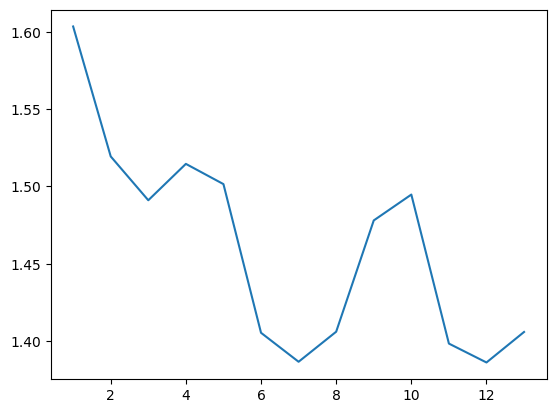

	Epoch [14/20], Step [1/41], Loss: 1.4240
Epoch [14/20], Loss: 1.4240
	Epoch [14/20], Step [2/41], Loss: 1.4153
	Epoch [14/20], Step [3/41], Loss: 1.4443
	Epoch [14/20], Step [4/41], Loss: 1.4572
	Epoch [14/20], Step [5/41], Loss: 1.4223
	Epoch [14/20], Step [6/41], Loss: 1.4607
	Epoch [14/20], Step [7/41], Loss: 1.3099
	Epoch [14/20], Step [8/41], Loss: 1.4651
	Epoch [14/20], Step [9/41], Loss: 1.4048
	Epoch [14/20], Step [10/41], Loss: 1.3938
	Epoch [14/20], Step [11/41], Loss: 1.3767
	Epoch [14/20], Step [12/41], Loss: 1.3555
	Epoch [14/20], Step [13/41], Loss: 1.4131
	Epoch [14/20], Step [14/41], Loss: 1.3814
	Epoch [14/20], Step [15/41], Loss: 1.4362
	Epoch [14/20], Step [16/41], Loss: 1.4062
	Epoch [14/20], Step [17/41], Loss: 1.4186
	Epoch [14/20], Step [18/41], Loss: 1.3514
	Epoch [14/20], Step [19/41], Loss: 1.4112
	Epoch [14/20], Step [20/41], Loss: 1.4802
	Epoch [14/20], Step [21/41], Loss: 1.4303
	Epoch [14/20], Step [22/41], Loss: 1.3879
	Epoch [14/20], Step [23/41], Loss:

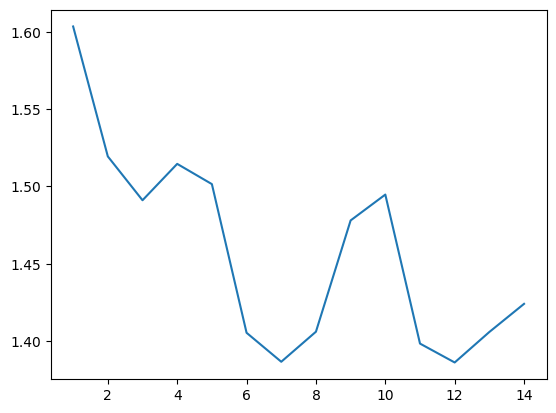

	Epoch [15/20], Step [1/41], Loss: 1.4072
Epoch [15/20], Loss: 1.4072
	Epoch [15/20], Step [2/41], Loss: 1.4315
	Epoch [15/20], Step [3/41], Loss: 1.3695
	Epoch [15/20], Step [4/41], Loss: 1.4058
	Epoch [15/20], Step [5/41], Loss: 1.4333
	Epoch [15/20], Step [6/41], Loss: 1.4491
	Epoch [15/20], Step [7/41], Loss: 1.2576
	Epoch [15/20], Step [8/41], Loss: 1.4071
	Epoch [15/20], Step [9/41], Loss: 1.2960
	Epoch [15/20], Step [10/41], Loss: 1.3901
	Epoch [15/20], Step [11/41], Loss: 1.4360
	Epoch [15/20], Step [12/41], Loss: 1.4235
	Epoch [15/20], Step [13/41], Loss: 1.3948
	Epoch [15/20], Step [14/41], Loss: 1.3483
	Epoch [15/20], Step [15/41], Loss: 1.3604
	Epoch [15/20], Step [16/41], Loss: 1.4604
	Epoch [15/20], Step [17/41], Loss: 1.3092
	Epoch [15/20], Step [18/41], Loss: 1.4581
	Epoch [15/20], Step [19/41], Loss: 1.3932
	Epoch [15/20], Step [20/41], Loss: 1.3746
	Epoch [15/20], Step [21/41], Loss: 1.3200
	Epoch [15/20], Step [22/41], Loss: 1.3286
	Epoch [15/20], Step [23/41], Loss:

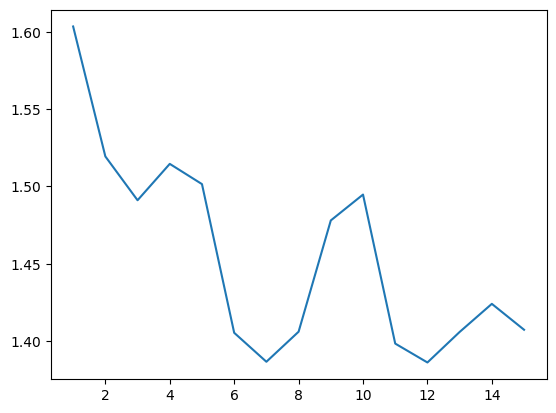

	Epoch [16/20], Step [1/41], Loss: 1.3355
Epoch [16/20], Loss: 1.3355
	Epoch [16/20], Step [2/41], Loss: 1.4920
	Epoch [16/20], Step [3/41], Loss: 1.4272
	Epoch [16/20], Step [4/41], Loss: 1.3750
	Epoch [16/20], Step [5/41], Loss: 1.4418
	Epoch [16/20], Step [6/41], Loss: 1.4715
	Epoch [16/20], Step [7/41], Loss: 1.4382
	Epoch [16/20], Step [8/41], Loss: 1.3373
	Epoch [16/20], Step [9/41], Loss: 1.4512
	Epoch [16/20], Step [10/41], Loss: 1.4394
	Epoch [16/20], Step [11/41], Loss: 1.4261
	Epoch [16/20], Step [12/41], Loss: 1.3700
	Epoch [16/20], Step [13/41], Loss: 1.4088
	Epoch [16/20], Step [14/41], Loss: 1.3094
	Epoch [16/20], Step [15/41], Loss: 1.3823
	Epoch [16/20], Step [16/41], Loss: 1.3858
	Epoch [16/20], Step [17/41], Loss: 1.3823
	Epoch [16/20], Step [18/41], Loss: 1.3755
	Epoch [16/20], Step [19/41], Loss: 1.4055
	Epoch [16/20], Step [20/41], Loss: 1.4040
	Epoch [16/20], Step [21/41], Loss: 1.3464
	Epoch [16/20], Step [22/41], Loss: 1.3061
	Epoch [16/20], Step [23/41], Loss:

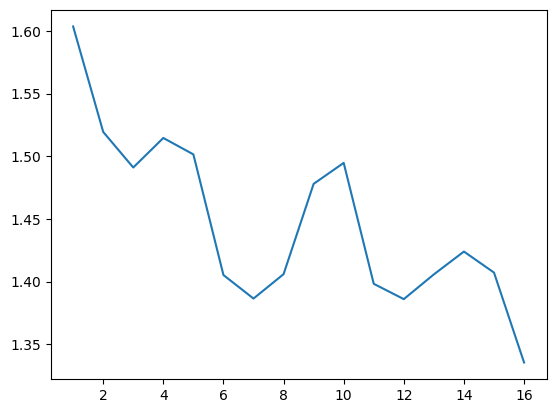

	Epoch [17/20], Step [1/41], Loss: 1.4026
Epoch [17/20], Loss: 1.4026
	Epoch [17/20], Step [2/41], Loss: 1.3659
	Epoch [17/20], Step [3/41], Loss: 1.3828
	Epoch [17/20], Step [4/41], Loss: 1.4836
	Epoch [17/20], Step [5/41], Loss: 1.3627
	Epoch [17/20], Step [6/41], Loss: 1.3922
	Epoch [17/20], Step [7/41], Loss: 1.4562
	Epoch [17/20], Step [8/41], Loss: 1.4057
	Epoch [17/20], Step [9/41], Loss: 1.4000
	Epoch [17/20], Step [10/41], Loss: 1.2897
	Epoch [17/20], Step [11/41], Loss: 1.3879
	Epoch [17/20], Step [12/41], Loss: 1.4460
	Epoch [17/20], Step [13/41], Loss: 1.5053
	Epoch [17/20], Step [14/41], Loss: 1.4081
	Epoch [17/20], Step [15/41], Loss: 1.4815
	Epoch [17/20], Step [16/41], Loss: 1.3949
	Epoch [17/20], Step [17/41], Loss: 1.3163
	Epoch [17/20], Step [18/41], Loss: 1.2522
	Epoch [17/20], Step [19/41], Loss: 1.3357
	Epoch [17/20], Step [20/41], Loss: 1.4578
	Epoch [17/20], Step [21/41], Loss: 1.3456
	Epoch [17/20], Step [22/41], Loss: 1.3302
	Epoch [17/20], Step [23/41], Loss:

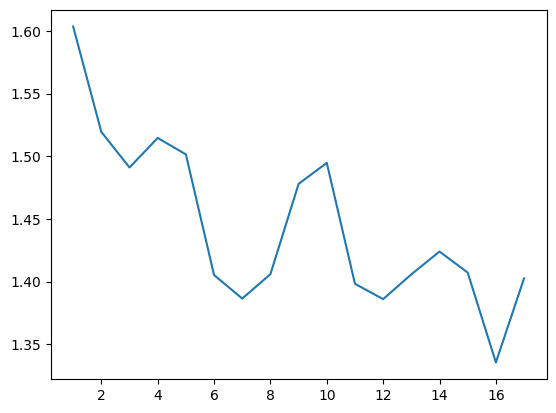

	Epoch [18/20], Step [1/41], Loss: 1.3374
Epoch [18/20], Loss: 1.3374
	Epoch [18/20], Step [2/41], Loss: 1.3539
	Epoch [18/20], Step [3/41], Loss: 1.3929
	Epoch [18/20], Step [4/41], Loss: 1.4340
	Epoch [18/20], Step [5/41], Loss: 1.3800
	Epoch [18/20], Step [6/41], Loss: 1.3403
	Epoch [18/20], Step [7/41], Loss: 1.3622
	Epoch [18/20], Step [8/41], Loss: 1.3710
	Epoch [18/20], Step [9/41], Loss: 1.3858
	Epoch [18/20], Step [10/41], Loss: 1.3334
	Epoch [18/20], Step [11/41], Loss: 1.4988
	Epoch [18/20], Step [12/41], Loss: 1.3609
	Epoch [18/20], Step [13/41], Loss: 1.4016
	Epoch [18/20], Step [14/41], Loss: 1.4134
	Epoch [18/20], Step [15/41], Loss: 1.3856
	Epoch [18/20], Step [16/41], Loss: 1.4618
	Epoch [18/20], Step [17/41], Loss: 1.4172
	Epoch [18/20], Step [18/41], Loss: 1.4130
	Epoch [18/20], Step [19/41], Loss: 1.2411
	Epoch [18/20], Step [20/41], Loss: 1.4410
	Epoch [18/20], Step [21/41], Loss: 1.3902
	Epoch [18/20], Step [22/41], Loss: 1.3534
	Epoch [18/20], Step [23/41], Loss:

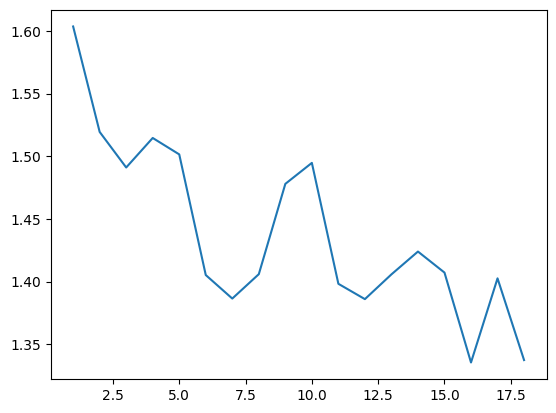

	Epoch [19/20], Step [1/41], Loss: 1.3339
Epoch [19/20], Loss: 1.3339
	Epoch [19/20], Step [2/41], Loss: 1.4123
	Epoch [19/20], Step [3/41], Loss: 1.3839
	Epoch [19/20], Step [4/41], Loss: 1.3485
	Epoch [19/20], Step [5/41], Loss: 1.3464
	Epoch [19/20], Step [6/41], Loss: 1.3177
	Epoch [19/20], Step [7/41], Loss: 1.4182
	Epoch [19/20], Step [8/41], Loss: 1.3563
	Epoch [19/20], Step [9/41], Loss: 1.4260
	Epoch [19/20], Step [10/41], Loss: 1.3711
	Epoch [19/20], Step [11/41], Loss: 1.3772
	Epoch [19/20], Step [12/41], Loss: 1.3938
	Epoch [19/20], Step [13/41], Loss: 1.4483
	Epoch [19/20], Step [14/41], Loss: 1.4000
	Epoch [19/20], Step [15/41], Loss: 1.3700
	Epoch [19/20], Step [16/41], Loss: 1.3944
	Epoch [19/20], Step [17/41], Loss: 1.4160
	Epoch [19/20], Step [18/41], Loss: 1.3960
	Epoch [19/20], Step [19/41], Loss: 1.3686
	Epoch [19/20], Step [20/41], Loss: 1.4202
	Epoch [19/20], Step [21/41], Loss: 1.3947
	Epoch [19/20], Step [22/41], Loss: 1.2608
	Epoch [19/20], Step [23/41], Loss:

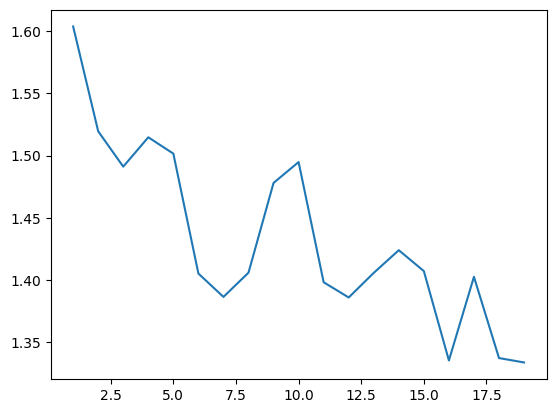

	Epoch [20/20], Step [1/41], Loss: 1.4106
Epoch [20/20], Loss: 1.4106
	Epoch [20/20], Step [2/41], Loss: 1.3359
	Epoch [20/20], Step [3/41], Loss: 1.3140
	Epoch [20/20], Step [4/41], Loss: 1.3749
	Epoch [20/20], Step [5/41], Loss: 1.4601
	Epoch [20/20], Step [6/41], Loss: 1.4139
	Epoch [20/20], Step [7/41], Loss: 1.4397
	Epoch [20/20], Step [8/41], Loss: 1.5643
	Epoch [20/20], Step [9/41], Loss: 1.3641
	Epoch [20/20], Step [10/41], Loss: 1.3652
	Epoch [20/20], Step [11/41], Loss: 1.4645
	Epoch [20/20], Step [12/41], Loss: 1.3883
	Epoch [20/20], Step [13/41], Loss: 1.3425
	Epoch [20/20], Step [14/41], Loss: 1.3937
	Epoch [20/20], Step [15/41], Loss: 1.4328
	Epoch [20/20], Step [16/41], Loss: 1.2710
	Epoch [20/20], Step [17/41], Loss: 1.4165
	Epoch [20/20], Step [18/41], Loss: 1.4654
	Epoch [20/20], Step [19/41], Loss: 1.3684
	Epoch [20/20], Step [20/41], Loss: 1.4009
	Epoch [20/20], Step [21/41], Loss: 1.3715
	Epoch [20/20], Step [22/41], Loss: 1.3049
	Epoch [20/20], Step [23/41], Loss:

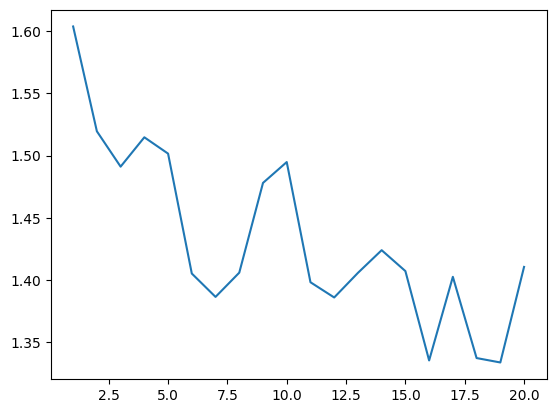

In [ ]:
model_vgg_unpretrained = selfVGG16().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg_unpretrained.parameters(), lr=0.00005)

epoch_size = 20

loss_trajectory = []
for epoch in range(epoch_size):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model_vgg_unpretrained(images)
        outputs = outputs.squeeze()
        # print("outputs:", outputs)
        # print("labels:", labels)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        print('\tEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
              epoch + 1, epoch_size, i + 1, int(len(train_data) / batch_size) + 1, loss.item()))
        if i == 0:
            print(f'Epoch [{epoch + 1}/{epoch_size}], Loss: {loss.item():.4f}')
            loss_trajectory.append(loss.item())

    plt.plot([i + 1 for i in range(len(loss_trajectory))], loss_trajectory)
    plt.show()

In [ ]:
correct = 0
total = 0

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_vgg_unpretrained(images)
        outputs = outputs.squeeze()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())
        print("predicted: ", predicted)
        print("label: ", labels)

print('Test Accuracy: {}%'.format((correct / total) * 100))


predicted:  tensor([2, 4, 4, 4, 3, 1, 3, 1, 1, 4, 4, 4, 3, 0, 0, 0, 2, 4, 4, 1, 3, 3, 0, 4,
        2, 2, 0, 0, 3, 4, 2, 3], device='cuda:0')
label:  tensor([2, 1, 0, 1, 2, 2, 3, 2, 0, 2, 1, 4, 3, 0, 2, 0, 4, 4, 4, 2, 3, 3, 3, 4,
        3, 2, 4, 0, 3, 4, 2, 3], device='cuda:0')
predicted:  tensor([0, 1, 4, 2, 3, 2, 4, 1, 3, 3, 1, 0, 2, 0, 1, 3, 2, 3, 1, 3, 0, 1, 3, 4,
        4, 2, 1, 1, 4, 4, 1, 4], device='cuda:0')
label:  tensor([0, 2, 4, 2, 3, 2, 4, 0, 3, 3, 1, 0, 4, 2, 0, 3, 2, 3, 2, 3, 3, 4, 3, 4,
        1, 4, 0, 2, 4, 1, 0, 1], device='cuda:0')
predicted:  tensor([1, 0, 2, 3, 4, 4, 3, 4, 3, 2, 0, 1, 3, 2, 3, 4, 2, 1, 1, 2, 4, 3, 0, 4,
        0, 3, 2, 2, 1, 4, 3, 0], device='cuda:0')
label:  tensor([0, 3, 0, 0, 0, 2, 3, 4, 3, 3, 2, 2, 3, 1, 3, 2, 4, 1, 2, 2, 2, 3, 0, 1,
        1, 4, 2, 3, 0, 0, 3, 3], device='cuda:0')
predicted:  tensor([4, 0, 1, 1, 4, 2, 2, 4, 4, 0, 4, 0, 1, 4, 3, 3, 4, 1, 3, 3, 3, 1, 1, 1,
        0, 4, 2, 4, 4, 1, 2, 4], device='cuda:0')
label:  tensor([4,

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))

Accuracy: 0.4492
Precision: 0.4615
Recall: 0.4492
F1 Score: 0.4458


## Basic CNN

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28x28

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14x14

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 7x7
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
SimpleCNN(num_classes=class_num)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier

	Epoch [1/30], Step [1/41], Loss: 1.6099
	Epoch [1/30], Step [2/41], Loss: 1.6150
	Epoch [1/30], Step [3/41], Loss: 1.6000
	Epoch [1/30], Step [4/41], Loss: 1.5853
	Epoch [1/30], Step [5/41], Loss: 1.6370
	Epoch [1/30], Step [6/41], Loss: 1.7091
	Epoch [1/30], Step [7/41], Loss: 1.5982
	Epoch [1/30], Step [8/41], Loss: 1.6033
	Epoch [1/30], Step [9/41], Loss: 1.6024
	Epoch [1/30], Step [10/41], Loss: 1.5773
	Epoch [1/30], Step [11/41], Loss: 1.5566
	Epoch [1/30], Step [12/41], Loss: 1.5481
	Epoch [1/30], Step [13/41], Loss: 1.6545
	Epoch [1/30], Step [14/41], Loss: 1.6255
	Epoch [1/30], Step [15/41], Loss: 1.5756
	Epoch [1/30], Step [16/41], Loss: 1.4815
	Epoch [1/30], Step [17/41], Loss: 1.6151
	Epoch [1/30], Step [18/41], Loss: 1.6149
	Epoch [1/30], Step [19/41], Loss: 1.5028
	Epoch [1/30], Step [20/41], Loss: 1.5473
	Epoch [1/30], Step [21/41], Loss: 1.4830
	Epoch [1/30], Step [22/41], Loss: 1.5380
	Epoch [1/30], Step [23/41], Loss: 1.5421
	Epoch [1/30], Step [24/41], Loss: 1.5672
	

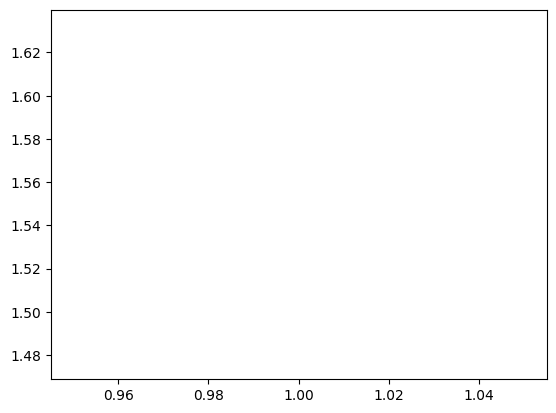

	Epoch [2/30], Step [1/41], Loss: 1.4787
	Epoch [2/30], Step [2/41], Loss: 1.5440
	Epoch [2/30], Step [3/41], Loss: 1.3752
	Epoch [2/30], Step [4/41], Loss: 1.4349
	Epoch [2/30], Step [5/41], Loss: 1.4813
	Epoch [2/30], Step [6/41], Loss: 1.4495
	Epoch [2/30], Step [7/41], Loss: 1.3827
	Epoch [2/30], Step [8/41], Loss: 1.4032
	Epoch [2/30], Step [9/41], Loss: 1.4935
	Epoch [2/30], Step [10/41], Loss: 1.3604
	Epoch [2/30], Step [11/41], Loss: 1.2882
	Epoch [2/30], Step [12/41], Loss: 1.1509
	Epoch [2/30], Step [13/41], Loss: 1.4981
	Epoch [2/30], Step [14/41], Loss: 1.8563
	Epoch [2/30], Step [15/41], Loss: 1.3177
	Epoch [2/30], Step [16/41], Loss: 1.3808
	Epoch [2/30], Step [17/41], Loss: 1.4310
	Epoch [2/30], Step [18/41], Loss: 1.5252
	Epoch [2/30], Step [19/41], Loss: 1.4218
	Epoch [2/30], Step [20/41], Loss: 1.4203
	Epoch [2/30], Step [21/41], Loss: 1.4810
	Epoch [2/30], Step [22/41], Loss: 1.5148
	Epoch [2/30], Step [23/41], Loss: 1.4859
	Epoch [2/30], Step [24/41], Loss: 1.4251
	

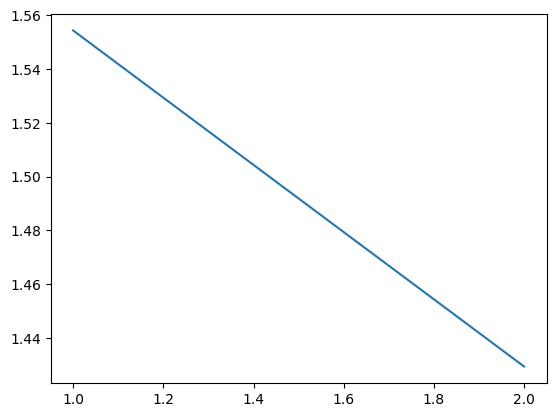

	Epoch [3/30], Step [1/41], Loss: 1.3653
	Epoch [3/30], Step [2/41], Loss: 1.0889
	Epoch [3/30], Step [3/41], Loss: 0.9390
	Epoch [3/30], Step [4/41], Loss: 1.3320
	Epoch [3/30], Step [5/41], Loss: 1.5161
	Epoch [3/30], Step [6/41], Loss: 1.5728
	Epoch [3/30], Step [7/41], Loss: 1.2184
	Epoch [3/30], Step [8/41], Loss: 1.2023
	Epoch [3/30], Step [9/41], Loss: 1.5116
	Epoch [3/30], Step [10/41], Loss: 1.1328
	Epoch [3/30], Step [11/41], Loss: 1.2309
	Epoch [3/30], Step [12/41], Loss: 1.4988
	Epoch [3/30], Step [13/41], Loss: 1.4293
	Epoch [3/30], Step [14/41], Loss: 1.2874
	Epoch [3/30], Step [15/41], Loss: 1.1105
	Epoch [3/30], Step [16/41], Loss: 1.2077
	Epoch [3/30], Step [17/41], Loss: 1.4203
	Epoch [3/30], Step [18/41], Loss: 1.2869
	Epoch [3/30], Step [19/41], Loss: 1.2830
	Epoch [3/30], Step [20/41], Loss: 1.4230
	Epoch [3/30], Step [21/41], Loss: 1.3758
	Epoch [3/30], Step [22/41], Loss: 1.4625
	Epoch [3/30], Step [23/41], Loss: 1.4794
	Epoch [3/30], Step [24/41], Loss: 1.3278
	

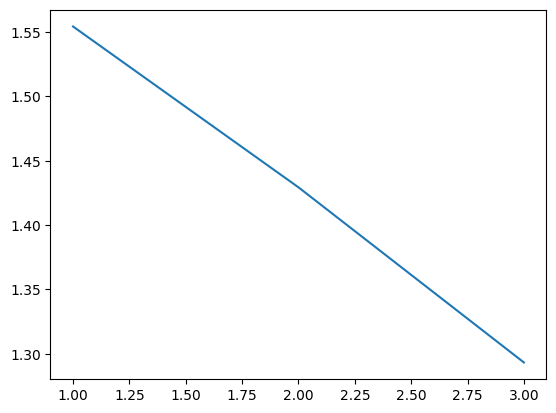

	Epoch [4/30], Step [1/41], Loss: 1.5401
	Epoch [4/30], Step [2/41], Loss: 1.3114
	Epoch [4/30], Step [3/41], Loss: 1.4282
	Epoch [4/30], Step [4/41], Loss: 1.2522
	Epoch [4/30], Step [5/41], Loss: 1.1775
	Epoch [4/30], Step [6/41], Loss: 1.2625
	Epoch [4/30], Step [7/41], Loss: 1.3909
	Epoch [4/30], Step [8/41], Loss: 1.3321
	Epoch [4/30], Step [9/41], Loss: 1.3322
	Epoch [4/30], Step [10/41], Loss: 1.2203
	Epoch [4/30], Step [11/41], Loss: 1.2609
	Epoch [4/30], Step [12/41], Loss: 1.2040
	Epoch [4/30], Step [13/41], Loss: 1.3180
	Epoch [4/30], Step [14/41], Loss: 1.4132
	Epoch [4/30], Step [15/41], Loss: 1.2373
	Epoch [4/30], Step [16/41], Loss: 1.3776
	Epoch [4/30], Step [17/41], Loss: 1.2247
	Epoch [4/30], Step [18/41], Loss: 1.2113
	Epoch [4/30], Step [19/41], Loss: 1.1734
	Epoch [4/30], Step [20/41], Loss: 1.3787
	Epoch [4/30], Step [21/41], Loss: 1.3411
	Epoch [4/30], Step [22/41], Loss: 1.5295
	Epoch [4/30], Step [23/41], Loss: 1.1831
	Epoch [4/30], Step [24/41], Loss: 1.4700
	

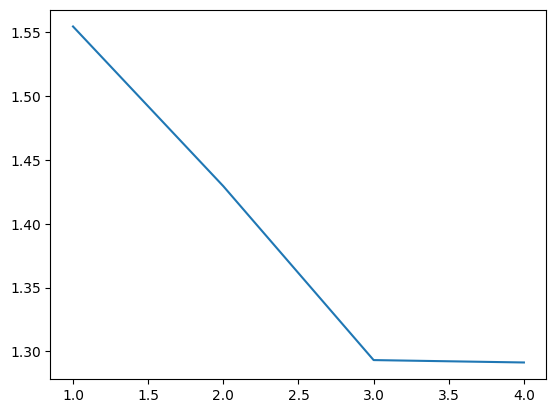

	Epoch [5/30], Step [1/41], Loss: 1.3757
	Epoch [5/30], Step [2/41], Loss: 1.4575
	Epoch [5/30], Step [3/41], Loss: 1.1683
	Epoch [5/30], Step [4/41], Loss: 1.3544
	Epoch [5/30], Step [5/41], Loss: 1.3398
	Epoch [5/30], Step [6/41], Loss: 1.1716
	Epoch [5/30], Step [7/41], Loss: 1.2349
	Epoch [5/30], Step [8/41], Loss: 1.2332
	Epoch [5/30], Step [9/41], Loss: 1.1856
	Epoch [5/30], Step [10/41], Loss: 1.2835
	Epoch [5/30], Step [11/41], Loss: 1.0161
	Epoch [5/30], Step [12/41], Loss: 1.2702
	Epoch [5/30], Step [13/41], Loss: 1.1277
	Epoch [5/30], Step [14/41], Loss: 1.4033
	Epoch [5/30], Step [15/41], Loss: 1.2747
	Epoch [5/30], Step [16/41], Loss: 1.2277
	Epoch [5/30], Step [17/41], Loss: 1.3511
	Epoch [5/30], Step [18/41], Loss: 1.1613
	Epoch [5/30], Step [19/41], Loss: 1.1917
	Epoch [5/30], Step [20/41], Loss: 1.3079
	Epoch [5/30], Step [21/41], Loss: 1.3116
	Epoch [5/30], Step [22/41], Loss: 1.4720
	Epoch [5/30], Step [23/41], Loss: 1.1481
	Epoch [5/30], Step [24/41], Loss: 1.2255
	

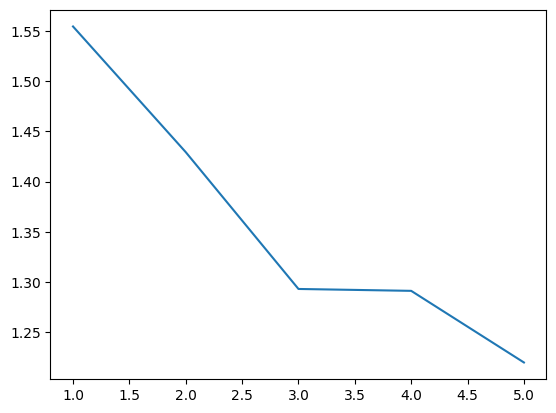

	Epoch [6/30], Step [1/41], Loss: 1.2836
	Epoch [6/30], Step [2/41], Loss: 1.0798
	Epoch [6/30], Step [3/41], Loss: 1.0180
	Epoch [6/30], Step [4/41], Loss: 1.3187
	Epoch [6/30], Step [5/41], Loss: 1.3175
	Epoch [6/30], Step [6/41], Loss: 1.0697
	Epoch [6/30], Step [7/41], Loss: 1.3594
	Epoch [6/30], Step [8/41], Loss: 1.3313
	Epoch [6/30], Step [9/41], Loss: 1.2048
	Epoch [6/30], Step [10/41], Loss: 1.1632
	Epoch [6/30], Step [11/41], Loss: 1.2068
	Epoch [6/30], Step [12/41], Loss: 1.0344
	Epoch [6/30], Step [13/41], Loss: 1.4457
	Epoch [6/30], Step [14/41], Loss: 1.0335
	Epoch [6/30], Step [15/41], Loss: 1.2848
	Epoch [6/30], Step [16/41], Loss: 1.0683
	Epoch [6/30], Step [17/41], Loss: 1.1118
	Epoch [6/30], Step [18/41], Loss: 1.5061
	Epoch [6/30], Step [19/41], Loss: 1.1093
	Epoch [6/30], Step [20/41], Loss: 1.2532
	Epoch [6/30], Step [21/41], Loss: 1.2032
	Epoch [6/30], Step [22/41], Loss: 0.9829
	Epoch [6/30], Step [23/41], Loss: 1.1294
	Epoch [6/30], Step [24/41], Loss: 1.0753
	

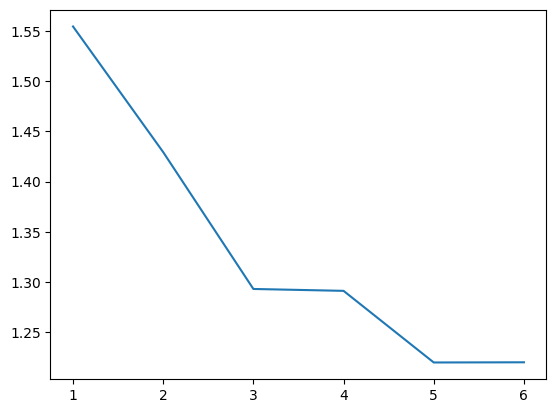

	Epoch [7/30], Step [1/41], Loss: 1.3427
	Epoch [7/30], Step [2/41], Loss: 1.3529
	Epoch [7/30], Step [3/41], Loss: 1.2264
	Epoch [7/30], Step [4/41], Loss: 1.1037
	Epoch [7/30], Step [5/41], Loss: 1.1842
	Epoch [7/30], Step [6/41], Loss: 1.1191
	Epoch [7/30], Step [7/41], Loss: 1.1121
	Epoch [7/30], Step [8/41], Loss: 1.2663
	Epoch [7/30], Step [9/41], Loss: 1.0265
	Epoch [7/30], Step [10/41], Loss: 1.3419
	Epoch [7/30], Step [11/41], Loss: 1.2755
	Epoch [7/30], Step [12/41], Loss: 0.9754
	Epoch [7/30], Step [13/41], Loss: 1.4148
	Epoch [7/30], Step [14/41], Loss: 1.1796
	Epoch [7/30], Step [15/41], Loss: 1.1676
	Epoch [7/30], Step [16/41], Loss: 1.1553
	Epoch [7/30], Step [17/41], Loss: 1.1657
	Epoch [7/30], Step [18/41], Loss: 1.3410
	Epoch [7/30], Step [19/41], Loss: 1.1333
	Epoch [7/30], Step [20/41], Loss: 0.9845
	Epoch [7/30], Step [21/41], Loss: 1.1211
	Epoch [7/30], Step [22/41], Loss: 1.0902
	Epoch [7/30], Step [23/41], Loss: 1.0722
	Epoch [7/30], Step [24/41], Loss: 1.3026
	

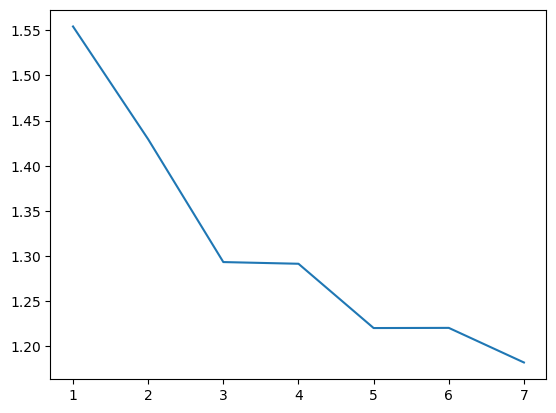

	Epoch [8/30], Step [1/41], Loss: 1.2243
	Epoch [8/30], Step [2/41], Loss: 0.9312
	Epoch [8/30], Step [3/41], Loss: 0.9461
	Epoch [8/30], Step [4/41], Loss: 1.1795
	Epoch [8/30], Step [5/41], Loss: 1.1530
	Epoch [8/30], Step [6/41], Loss: 1.3403
	Epoch [8/30], Step [7/41], Loss: 1.2421
	Epoch [8/30], Step [8/41], Loss: 1.0615
	Epoch [8/30], Step [9/41], Loss: 1.2307
	Epoch [8/30], Step [10/41], Loss: 1.0364
	Epoch [8/30], Step [11/41], Loss: 1.1783
	Epoch [8/30], Step [12/41], Loss: 0.7129
	Epoch [8/30], Step [13/41], Loss: 1.4658
	Epoch [8/30], Step [14/41], Loss: 1.1141
	Epoch [8/30], Step [15/41], Loss: 1.1022
	Epoch [8/30], Step [16/41], Loss: 1.0939
	Epoch [8/30], Step [17/41], Loss: 1.2694
	Epoch [8/30], Step [18/41], Loss: 1.1291
	Epoch [8/30], Step [19/41], Loss: 1.4461
	Epoch [8/30], Step [20/41], Loss: 1.0787
	Epoch [8/30], Step [21/41], Loss: 1.2329
	Epoch [8/30], Step [22/41], Loss: 1.2025
	Epoch [8/30], Step [23/41], Loss: 1.0167
	Epoch [8/30], Step [24/41], Loss: 1.1858
	

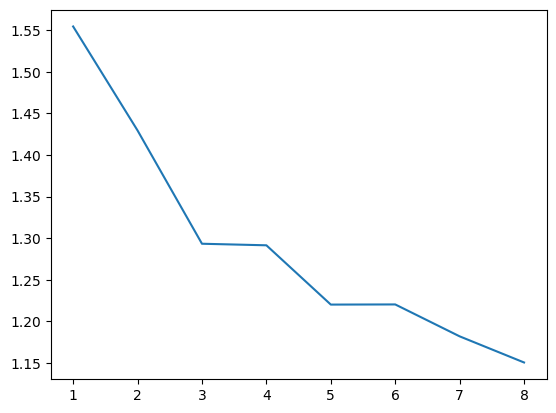

	Epoch [9/30], Step [1/41], Loss: 1.2484
	Epoch [9/30], Step [2/41], Loss: 1.1710
	Epoch [9/30], Step [3/41], Loss: 1.1219
	Epoch [9/30], Step [4/41], Loss: 1.0352
	Epoch [9/30], Step [5/41], Loss: 1.0332
	Epoch [9/30], Step [6/41], Loss: 1.1871
	Epoch [9/30], Step [7/41], Loss: 1.2091
	Epoch [9/30], Step [8/41], Loss: 1.2285
	Epoch [9/30], Step [9/41], Loss: 1.2383
	Epoch [9/30], Step [10/41], Loss: 1.0673
	Epoch [9/30], Step [11/41], Loss: 1.3322
	Epoch [9/30], Step [12/41], Loss: 0.8390
	Epoch [9/30], Step [13/41], Loss: 1.0183
	Epoch [9/30], Step [14/41], Loss: 1.3301
	Epoch [9/30], Step [15/41], Loss: 0.9170
	Epoch [9/30], Step [16/41], Loss: 1.0844
	Epoch [9/30], Step [17/41], Loss: 1.2686
	Epoch [9/30], Step [18/41], Loss: 1.0624
	Epoch [9/30], Step [19/41], Loss: 0.8641
	Epoch [9/30], Step [20/41], Loss: 1.2630
	Epoch [9/30], Step [21/41], Loss: 0.9182
	Epoch [9/30], Step [22/41], Loss: 0.9839
	Epoch [9/30], Step [23/41], Loss: 1.0571
	Epoch [9/30], Step [24/41], Loss: 1.0890
	

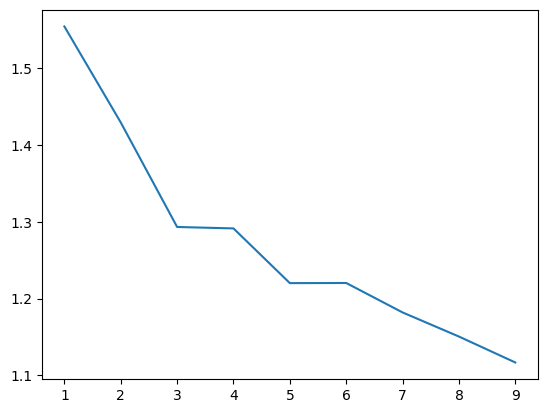

	Epoch [10/30], Step [1/41], Loss: 1.1314
	Epoch [10/30], Step [2/41], Loss: 1.1793
	Epoch [10/30], Step [3/41], Loss: 1.0469
	Epoch [10/30], Step [4/41], Loss: 0.9650
	Epoch [10/30], Step [5/41], Loss: 0.9982
	Epoch [10/30], Step [6/41], Loss: 1.1648
	Epoch [10/30], Step [7/41], Loss: 0.9076
	Epoch [10/30], Step [8/41], Loss: 1.3416
	Epoch [10/30], Step [9/41], Loss: 0.8912
	Epoch [10/30], Step [10/41], Loss: 1.2617
	Epoch [10/30], Step [11/41], Loss: 0.9543
	Epoch [10/30], Step [12/41], Loss: 1.3435
	Epoch [10/30], Step [13/41], Loss: 1.0614
	Epoch [10/30], Step [14/41], Loss: 1.1393
	Epoch [10/30], Step [15/41], Loss: 0.9710
	Epoch [10/30], Step [16/41], Loss: 1.1342
	Epoch [10/30], Step [17/41], Loss: 0.9649
	Epoch [10/30], Step [18/41], Loss: 1.1072
	Epoch [10/30], Step [19/41], Loss: 1.0710
	Epoch [10/30], Step [20/41], Loss: 1.1832
	Epoch [10/30], Step [21/41], Loss: 0.9338
	Epoch [10/30], Step [22/41], Loss: 1.1083
	Epoch [10/30], Step [23/41], Loss: 1.3261
	Epoch [10/30], Step

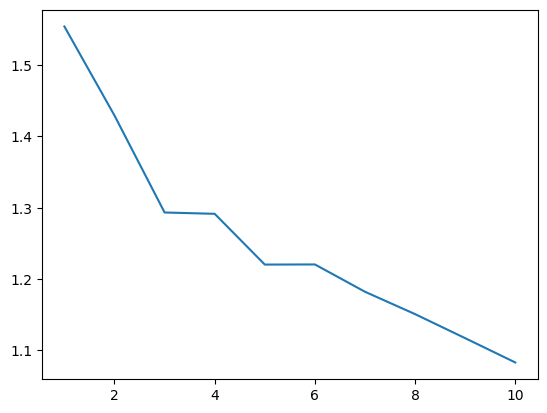

	Epoch [11/30], Step [1/41], Loss: 1.2575
	Epoch [11/30], Step [2/41], Loss: 1.1814
	Epoch [11/30], Step [3/41], Loss: 1.1585
	Epoch [11/30], Step [4/41], Loss: 1.0506
	Epoch [11/30], Step [5/41], Loss: 0.9446
	Epoch [11/30], Step [6/41], Loss: 1.0851
	Epoch [11/30], Step [7/41], Loss: 1.1202
	Epoch [11/30], Step [8/41], Loss: 1.0914
	Epoch [11/30], Step [9/41], Loss: 0.8486
	Epoch [11/30], Step [10/41], Loss: 0.7736
	Epoch [11/30], Step [11/41], Loss: 1.0495
	Epoch [11/30], Step [12/41], Loss: 1.0285
	Epoch [11/30], Step [13/41], Loss: 1.1043
	Epoch [11/30], Step [14/41], Loss: 0.9966
	Epoch [11/30], Step [15/41], Loss: 0.9418
	Epoch [11/30], Step [16/41], Loss: 0.9076
	Epoch [11/30], Step [17/41], Loss: 1.1407
	Epoch [11/30], Step [18/41], Loss: 0.8812
	Epoch [11/30], Step [19/41], Loss: 1.0935
	Epoch [11/30], Step [20/41], Loss: 1.0030
	Epoch [11/30], Step [21/41], Loss: 0.7625
	Epoch [11/30], Step [22/41], Loss: 0.9306
	Epoch [11/30], Step [23/41], Loss: 0.9127
	Epoch [11/30], Step

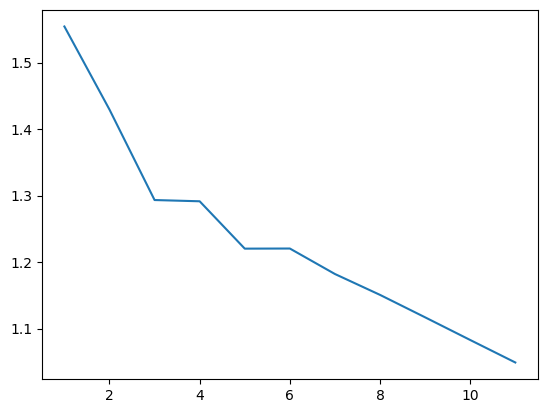

	Epoch [12/30], Step [1/41], Loss: 1.0861
	Epoch [12/30], Step [2/41], Loss: 0.9537
	Epoch [12/30], Step [3/41], Loss: 1.0869
	Epoch [12/30], Step [4/41], Loss: 1.0088
	Epoch [12/30], Step [5/41], Loss: 0.8173
	Epoch [12/30], Step [6/41], Loss: 0.9189
	Epoch [12/30], Step [7/41], Loss: 0.9417
	Epoch [12/30], Step [8/41], Loss: 1.1390
	Epoch [12/30], Step [9/41], Loss: 1.0386
	Epoch [12/30], Step [10/41], Loss: 0.9623
	Epoch [12/30], Step [11/41], Loss: 1.1261
	Epoch [12/30], Step [12/41], Loss: 1.1622
	Epoch [12/30], Step [13/41], Loss: 0.8984
	Epoch [12/30], Step [14/41], Loss: 1.1666
	Epoch [12/30], Step [15/41], Loss: 1.0565
	Epoch [12/30], Step [16/41], Loss: 1.1248
	Epoch [12/30], Step [17/41], Loss: 0.8810
	Epoch [12/30], Step [18/41], Loss: 1.0608
	Epoch [12/30], Step [19/41], Loss: 1.1806
	Epoch [12/30], Step [20/41], Loss: 0.9474
	Epoch [12/30], Step [21/41], Loss: 1.2306
	Epoch [12/30], Step [22/41], Loss: 1.1326
	Epoch [12/30], Step [23/41], Loss: 0.9532
	Epoch [12/30], Step

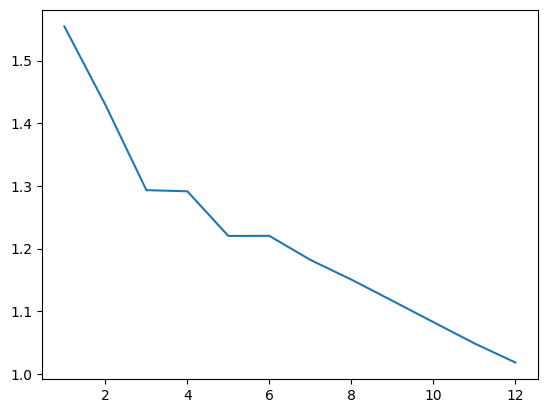

	Epoch [13/30], Step [1/41], Loss: 1.0536
	Epoch [13/30], Step [2/41], Loss: 1.0102
	Epoch [13/30], Step [3/41], Loss: 1.0332
	Epoch [13/30], Step [4/41], Loss: 0.9707
	Epoch [13/30], Step [5/41], Loss: 0.8507
	Epoch [13/30], Step [6/41], Loss: 0.9761
	Epoch [13/30], Step [7/41], Loss: 1.0677
	Epoch [13/30], Step [8/41], Loss: 0.9933
	Epoch [13/30], Step [9/41], Loss: 1.2348
	Epoch [13/30], Step [10/41], Loss: 1.0629
	Epoch [13/30], Step [11/41], Loss: 0.9679
	Epoch [13/30], Step [12/41], Loss: 1.0675
	Epoch [13/30], Step [13/41], Loss: 1.1971
	Epoch [13/30], Step [14/41], Loss: 1.0984
	Epoch [13/30], Step [15/41], Loss: 0.6226
	Epoch [13/30], Step [16/41], Loss: 0.7445
	Epoch [13/30], Step [17/41], Loss: 1.0809
	Epoch [13/30], Step [18/41], Loss: 0.6895
	Epoch [13/30], Step [19/41], Loss: 0.7326
	Epoch [13/30], Step [20/41], Loss: 0.9295
	Epoch [13/30], Step [21/41], Loss: 0.8520
	Epoch [13/30], Step [22/41], Loss: 1.1576
	Epoch [13/30], Step [23/41], Loss: 1.3062
	Epoch [13/30], Step

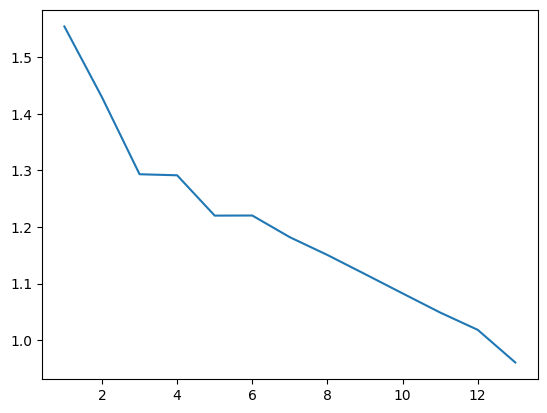

	Epoch [14/30], Step [1/41], Loss: 0.6671
	Epoch [14/30], Step [2/41], Loss: 1.2813
	Epoch [14/30], Step [3/41], Loss: 0.7362
	Epoch [14/30], Step [4/41], Loss: 0.8574
	Epoch [14/30], Step [5/41], Loss: 1.1648
	Epoch [14/30], Step [6/41], Loss: 0.8686
	Epoch [14/30], Step [7/41], Loss: 0.8222
	Epoch [14/30], Step [8/41], Loss: 0.8738
	Epoch [14/30], Step [9/41], Loss: 1.1432
	Epoch [14/30], Step [10/41], Loss: 0.7458
	Epoch [14/30], Step [11/41], Loss: 1.0724
	Epoch [14/30], Step [12/41], Loss: 1.0262
	Epoch [14/30], Step [13/41], Loss: 1.0789
	Epoch [14/30], Step [14/41], Loss: 0.6959
	Epoch [14/30], Step [15/41], Loss: 1.0003
	Epoch [14/30], Step [16/41], Loss: 0.8627
	Epoch [14/30], Step [17/41], Loss: 1.0100
	Epoch [14/30], Step [18/41], Loss: 0.9975
	Epoch [14/30], Step [19/41], Loss: 0.9096
	Epoch [14/30], Step [20/41], Loss: 1.0767
	Epoch [14/30], Step [21/41], Loss: 0.9769
	Epoch [14/30], Step [22/41], Loss: 0.8673
	Epoch [14/30], Step [23/41], Loss: 1.0487
	Epoch [14/30], Step

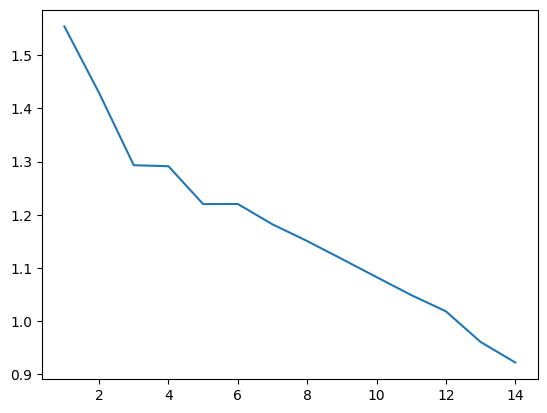

	Epoch [15/30], Step [1/41], Loss: 0.8160
	Epoch [15/30], Step [2/41], Loss: 0.8558
	Epoch [15/30], Step [3/41], Loss: 0.7870
	Epoch [15/30], Step [4/41], Loss: 0.8259
	Epoch [15/30], Step [5/41], Loss: 0.8105
	Epoch [15/30], Step [6/41], Loss: 0.8573
	Epoch [15/30], Step [7/41], Loss: 0.8197
	Epoch [15/30], Step [8/41], Loss: 0.9536
	Epoch [15/30], Step [9/41], Loss: 0.6337
	Epoch [15/30], Step [10/41], Loss: 0.6801
	Epoch [15/30], Step [11/41], Loss: 0.5123
	Epoch [15/30], Step [12/41], Loss: 0.8712
	Epoch [15/30], Step [13/41], Loss: 0.8934
	Epoch [15/30], Step [14/41], Loss: 1.0855
	Epoch [15/30], Step [15/41], Loss: 0.9048
	Epoch [15/30], Step [16/41], Loss: 0.9610
	Epoch [15/30], Step [17/41], Loss: 0.9084
	Epoch [15/30], Step [18/41], Loss: 0.8361
	Epoch [15/30], Step [19/41], Loss: 0.8802
	Epoch [15/30], Step [20/41], Loss: 0.6232
	Epoch [15/30], Step [21/41], Loss: 0.7030
	Epoch [15/30], Step [22/41], Loss: 1.3649
	Epoch [15/30], Step [23/41], Loss: 0.7969
	Epoch [15/30], Step

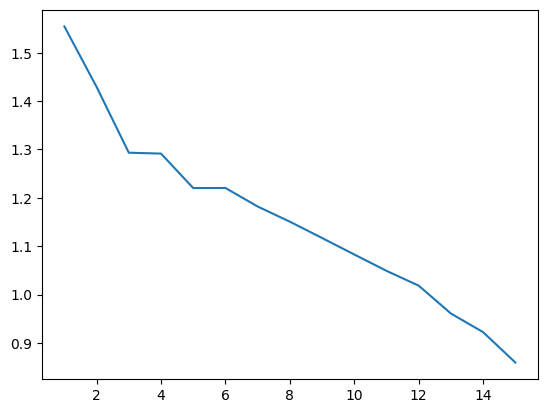

	Epoch [16/30], Step [1/41], Loss: 0.9704
	Epoch [16/30], Step [2/41], Loss: 0.8435
	Epoch [16/30], Step [3/41], Loss: 0.9191
	Epoch [16/30], Step [4/41], Loss: 0.7309
	Epoch [16/30], Step [5/41], Loss: 0.7771
	Epoch [16/30], Step [6/41], Loss: 0.6886
	Epoch [16/30], Step [7/41], Loss: 0.7138
	Epoch [16/30], Step [8/41], Loss: 0.9537
	Epoch [16/30], Step [9/41], Loss: 0.8431
	Epoch [16/30], Step [10/41], Loss: 0.9293
	Epoch [16/30], Step [11/41], Loss: 0.7634
	Epoch [16/30], Step [12/41], Loss: 0.5883
	Epoch [16/30], Step [13/41], Loss: 1.2004
	Epoch [16/30], Step [14/41], Loss: 0.8101
	Epoch [16/30], Step [15/41], Loss: 0.9930
	Epoch [16/30], Step [16/41], Loss: 0.5086
	Epoch [16/30], Step [17/41], Loss: 0.9831
	Epoch [16/30], Step [18/41], Loss: 0.9037
	Epoch [16/30], Step [19/41], Loss: 0.7914
	Epoch [16/30], Step [20/41], Loss: 0.6435
	Epoch [16/30], Step [21/41], Loss: 1.0148
	Epoch [16/30], Step [22/41], Loss: 0.9171
	Epoch [16/30], Step [23/41], Loss: 0.8080
	Epoch [16/30], Step

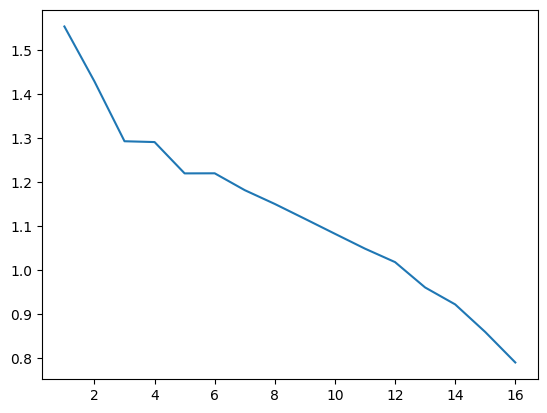

	Epoch [17/30], Step [1/41], Loss: 0.5635
	Epoch [17/30], Step [2/41], Loss: 0.5755
	Epoch [17/30], Step [3/41], Loss: 0.8798
	Epoch [17/30], Step [4/41], Loss: 0.8208
	Epoch [17/30], Step [5/41], Loss: 0.8108
	Epoch [17/30], Step [6/41], Loss: 0.4781
	Epoch [17/30], Step [7/41], Loss: 0.8523
	Epoch [17/30], Step [8/41], Loss: 0.6238
	Epoch [17/30], Step [9/41], Loss: 0.6350
	Epoch [17/30], Step [10/41], Loss: 0.8112
	Epoch [17/30], Step [11/41], Loss: 0.5107
	Epoch [17/30], Step [12/41], Loss: 0.6976
	Epoch [17/30], Step [13/41], Loss: 0.9053
	Epoch [17/30], Step [14/41], Loss: 0.9043
	Epoch [17/30], Step [15/41], Loss: 0.6979
	Epoch [17/30], Step [16/41], Loss: 0.6536
	Epoch [17/30], Step [17/41], Loss: 0.7008
	Epoch [17/30], Step [18/41], Loss: 0.7414
	Epoch [17/30], Step [19/41], Loss: 0.8987
	Epoch [17/30], Step [20/41], Loss: 0.6328
	Epoch [17/30], Step [21/41], Loss: 0.8457
	Epoch [17/30], Step [22/41], Loss: 0.5765
	Epoch [17/30], Step [23/41], Loss: 0.5342
	Epoch [17/30], Step

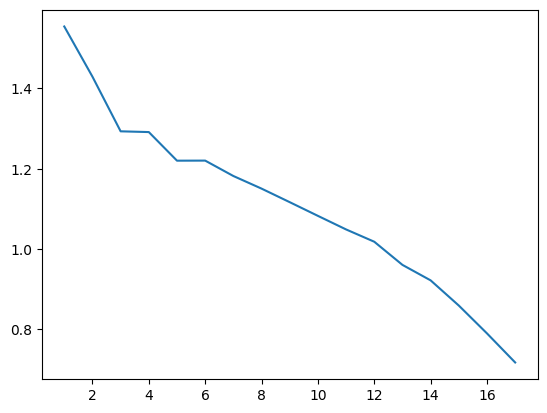

	Epoch [18/30], Step [1/41], Loss: 0.5688
	Epoch [18/30], Step [2/41], Loss: 0.7065
	Epoch [18/30], Step [3/41], Loss: 0.4176
	Epoch [18/30], Step [4/41], Loss: 0.6576
	Epoch [18/30], Step [5/41], Loss: 0.6409
	Epoch [18/30], Step [6/41], Loss: 0.4528
	Epoch [18/30], Step [7/41], Loss: 0.6105
	Epoch [18/30], Step [8/41], Loss: 0.4246
	Epoch [18/30], Step [9/41], Loss: 0.6170
	Epoch [18/30], Step [10/41], Loss: 0.5311
	Epoch [18/30], Step [11/41], Loss: 0.6757
	Epoch [18/30], Step [12/41], Loss: 0.5747
	Epoch [18/30], Step [13/41], Loss: 0.5367
	Epoch [18/30], Step [14/41], Loss: 0.6247
	Epoch [18/30], Step [15/41], Loss: 0.8419
	Epoch [18/30], Step [16/41], Loss: 0.5900
	Epoch [18/30], Step [17/41], Loss: 0.5206
	Epoch [18/30], Step [18/41], Loss: 0.5447
	Epoch [18/30], Step [19/41], Loss: 0.7304
	Epoch [18/30], Step [20/41], Loss: 0.6952
	Epoch [18/30], Step [21/41], Loss: 0.2667
	Epoch [18/30], Step [22/41], Loss: 0.7851
	Epoch [18/30], Step [23/41], Loss: 0.7402
	Epoch [18/30], Step

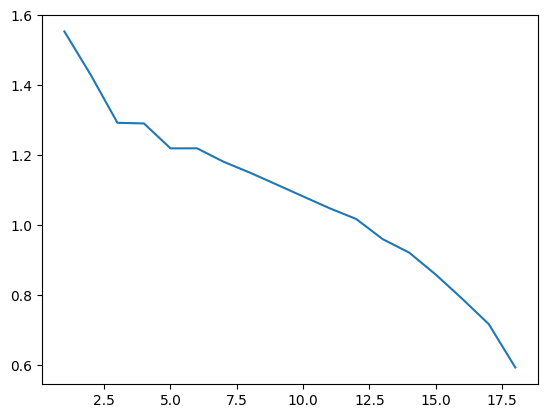

	Epoch [19/30], Step [1/41], Loss: 0.7691
	Epoch [19/30], Step [2/41], Loss: 0.4474
	Epoch [19/30], Step [3/41], Loss: 0.4468
	Epoch [19/30], Step [4/41], Loss: 0.3902
	Epoch [19/30], Step [5/41], Loss: 0.4012
	Epoch [19/30], Step [6/41], Loss: 0.2760
	Epoch [19/30], Step [7/41], Loss: 0.4415
	Epoch [19/30], Step [8/41], Loss: 0.6741
	Epoch [19/30], Step [9/41], Loss: 0.6030
	Epoch [19/30], Step [10/41], Loss: 0.4001
	Epoch [19/30], Step [11/41], Loss: 0.5239
	Epoch [19/30], Step [12/41], Loss: 0.5299
	Epoch [19/30], Step [13/41], Loss: 0.2034
	Epoch [19/30], Step [14/41], Loss: 0.4696
	Epoch [19/30], Step [15/41], Loss: 0.6511
	Epoch [19/30], Step [16/41], Loss: 0.3495
	Epoch [19/30], Step [17/41], Loss: 0.6387
	Epoch [19/30], Step [18/41], Loss: 0.6588
	Epoch [19/30], Step [19/41], Loss: 0.5211
	Epoch [19/30], Step [20/41], Loss: 0.5171
	Epoch [19/30], Step [21/41], Loss: 0.6027
	Epoch [19/30], Step [22/41], Loss: 0.4842
	Epoch [19/30], Step [23/41], Loss: 0.3934
	Epoch [19/30], Step

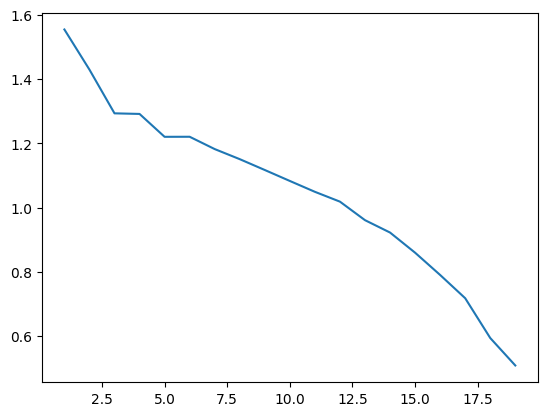

	Epoch [20/30], Step [1/41], Loss: 0.2745
	Epoch [20/30], Step [2/41], Loss: 0.6389
	Epoch [20/30], Step [3/41], Loss: 0.5850
	Epoch [20/30], Step [4/41], Loss: 0.3970
	Epoch [20/30], Step [5/41], Loss: 0.4121
	Epoch [20/30], Step [6/41], Loss: 0.4298
	Epoch [20/30], Step [7/41], Loss: 0.2684
	Epoch [20/30], Step [8/41], Loss: 0.3453
	Epoch [20/30], Step [9/41], Loss: 0.4700
	Epoch [20/30], Step [10/41], Loss: 0.3759
	Epoch [20/30], Step [11/41], Loss: 0.4833
	Epoch [20/30], Step [12/41], Loss: 0.2363
	Epoch [20/30], Step [13/41], Loss: 0.3657
	Epoch [20/30], Step [14/41], Loss: 0.3290
	Epoch [20/30], Step [15/41], Loss: 0.4636
	Epoch [20/30], Step [16/41], Loss: 0.5904
	Epoch [20/30], Step [17/41], Loss: 0.2893
	Epoch [20/30], Step [18/41], Loss: 0.3852
	Epoch [20/30], Step [19/41], Loss: 0.4461
	Epoch [20/30], Step [20/41], Loss: 0.3621
	Epoch [20/30], Step [21/41], Loss: 0.3865
	Epoch [20/30], Step [22/41], Loss: 0.6423
	Epoch [20/30], Step [23/41], Loss: 0.2505
	Epoch [20/30], Step

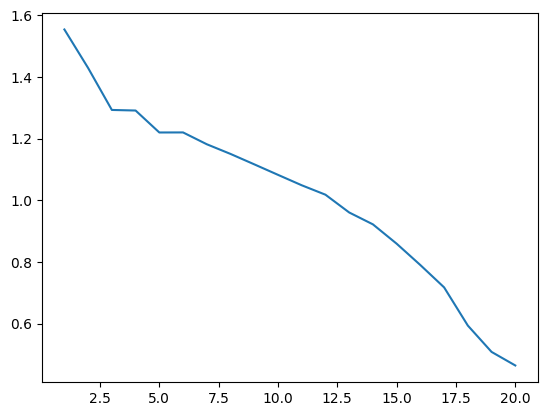

	Epoch [21/30], Step [1/41], Loss: 0.2557
	Epoch [21/30], Step [2/41], Loss: 0.5431
	Epoch [21/30], Step [3/41], Loss: 0.3378
	Epoch [21/30], Step [4/41], Loss: 0.2773
	Epoch [21/30], Step [5/41], Loss: 0.5358
	Epoch [21/30], Step [6/41], Loss: 0.5823
	Epoch [21/30], Step [7/41], Loss: 0.2644
	Epoch [21/30], Step [8/41], Loss: 0.3432
	Epoch [21/30], Step [9/41], Loss: 0.4752
	Epoch [21/30], Step [10/41], Loss: 0.4273
	Epoch [21/30], Step [11/41], Loss: 0.1487
	Epoch [21/30], Step [12/41], Loss: 0.2953
	Epoch [21/30], Step [13/41], Loss: 0.2203
	Epoch [21/30], Step [14/41], Loss: 0.4534
	Epoch [21/30], Step [15/41], Loss: 0.3053
	Epoch [21/30], Step [16/41], Loss: 0.2263
	Epoch [21/30], Step [17/41], Loss: 0.4456
	Epoch [21/30], Step [18/41], Loss: 0.4311
	Epoch [21/30], Step [19/41], Loss: 0.5291
	Epoch [21/30], Step [20/41], Loss: 0.5560
	Epoch [21/30], Step [21/41], Loss: 0.3695
	Epoch [21/30], Step [22/41], Loss: 0.2815
	Epoch [21/30], Step [23/41], Loss: 0.2995
	Epoch [21/30], Step

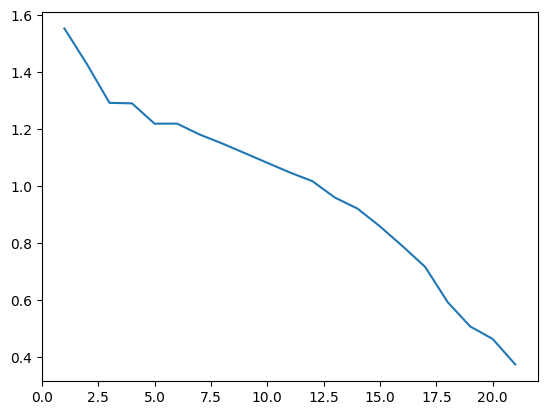

	Epoch [22/30], Step [1/41], Loss: 0.3357
	Epoch [22/30], Step [2/41], Loss: 0.1072
	Epoch [22/30], Step [3/41], Loss: 0.2151
	Epoch [22/30], Step [4/41], Loss: 0.4578
	Epoch [22/30], Step [5/41], Loss: 0.3680
	Epoch [22/30], Step [6/41], Loss: 0.3076
	Epoch [22/30], Step [7/41], Loss: 0.3071
	Epoch [22/30], Step [8/41], Loss: 0.4268
	Epoch [22/30], Step [9/41], Loss: 0.1498
	Epoch [22/30], Step [10/41], Loss: 0.2105
	Epoch [22/30], Step [11/41], Loss: 0.2730
	Epoch [22/30], Step [12/41], Loss: 0.3903
	Epoch [22/30], Step [13/41], Loss: 0.2367
	Epoch [22/30], Step [14/41], Loss: 0.1639
	Epoch [22/30], Step [15/41], Loss: 0.1634
	Epoch [22/30], Step [16/41], Loss: 0.3511
	Epoch [22/30], Step [17/41], Loss: 0.3594
	Epoch [22/30], Step [18/41], Loss: 0.1888
	Epoch [22/30], Step [19/41], Loss: 0.2094
	Epoch [22/30], Step [20/41], Loss: 0.4154
	Epoch [22/30], Step [21/41], Loss: 0.6815
	Epoch [22/30], Step [22/41], Loss: 0.5759
	Epoch [22/30], Step [23/41], Loss: 0.3278
	Epoch [22/30], Step

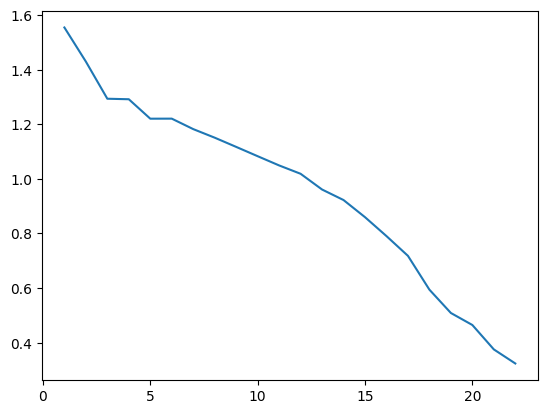

	Epoch [23/30], Step [1/41], Loss: 0.2841
	Epoch [23/30], Step [2/41], Loss: 0.2826
	Epoch [23/30], Step [3/41], Loss: 0.3935
	Epoch [23/30], Step [4/41], Loss: 0.2884
	Epoch [23/30], Step [5/41], Loss: 0.2825
	Epoch [23/30], Step [6/41], Loss: 0.2299
	Epoch [23/30], Step [7/41], Loss: 0.1298
	Epoch [23/30], Step [8/41], Loss: 0.1966
	Epoch [23/30], Step [9/41], Loss: 0.4401
	Epoch [23/30], Step [10/41], Loss: 0.2186
	Epoch [23/30], Step [11/41], Loss: 0.3132
	Epoch [23/30], Step [12/41], Loss: 0.3326
	Epoch [23/30], Step [13/41], Loss: 0.3230
	Epoch [23/30], Step [14/41], Loss: 0.3882
	Epoch [23/30], Step [15/41], Loss: 0.2486
	Epoch [23/30], Step [16/41], Loss: 0.4093
	Epoch [23/30], Step [17/41], Loss: 0.1947
	Epoch [23/30], Step [18/41], Loss: 0.4055
	Epoch [23/30], Step [19/41], Loss: 0.2729
	Epoch [23/30], Step [20/41], Loss: 0.2873
	Epoch [23/30], Step [21/41], Loss: 0.3574
	Epoch [23/30], Step [22/41], Loss: 0.2560
	Epoch [23/30], Step [23/41], Loss: 0.2488
	Epoch [23/30], Step

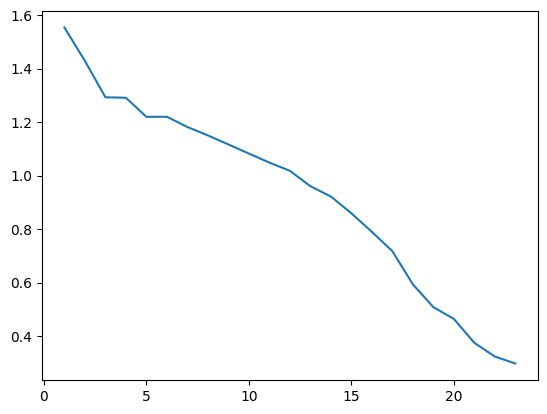

	Epoch [24/30], Step [1/41], Loss: 0.3586
	Epoch [24/30], Step [2/41], Loss: 0.2310
	Epoch [24/30], Step [3/41], Loss: 0.2907
	Epoch [24/30], Step [4/41], Loss: 0.2762
	Epoch [24/30], Step [5/41], Loss: 0.2811
	Epoch [24/30], Step [6/41], Loss: 0.3432
	Epoch [24/30], Step [7/41], Loss: 0.1438
	Epoch [24/30], Step [8/41], Loss: 0.2393
	Epoch [24/30], Step [9/41], Loss: 0.1011
	Epoch [24/30], Step [10/41], Loss: 0.1111
	Epoch [24/30], Step [11/41], Loss: 0.4308
	Epoch [24/30], Step [12/41], Loss: 0.1465
	Epoch [24/30], Step [13/41], Loss: 0.1677
	Epoch [24/30], Step [14/41], Loss: 0.1031
	Epoch [24/30], Step [15/41], Loss: 0.2297
	Epoch [24/30], Step [16/41], Loss: 0.2151
	Epoch [24/30], Step [17/41], Loss: 0.3133
	Epoch [24/30], Step [18/41], Loss: 0.2028
	Epoch [24/30], Step [19/41], Loss: 0.1491
	Epoch [24/30], Step [20/41], Loss: 0.1825
	Epoch [24/30], Step [21/41], Loss: 0.2014
	Epoch [24/30], Step [22/41], Loss: 0.2727
	Epoch [24/30], Step [23/41], Loss: 0.2135
	Epoch [24/30], Step

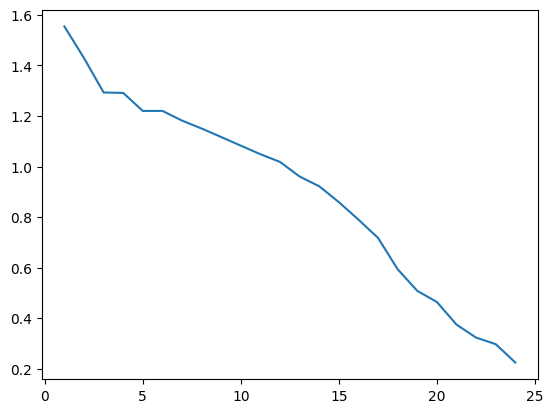

	Epoch [25/30], Step [1/41], Loss: 0.1026
	Epoch [25/30], Step [2/41], Loss: 0.2287
	Epoch [25/30], Step [3/41], Loss: 0.1447
	Epoch [25/30], Step [4/41], Loss: 0.2872
	Epoch [25/30], Step [5/41], Loss: 0.3812
	Epoch [25/30], Step [6/41], Loss: 0.1218
	Epoch [25/30], Step [7/41], Loss: 0.1720
	Epoch [25/30], Step [8/41], Loss: 0.1523
	Epoch [25/30], Step [9/41], Loss: 0.0789
	Epoch [25/30], Step [10/41], Loss: 0.2221
	Epoch [25/30], Step [11/41], Loss: 0.1420
	Epoch [25/30], Step [12/41], Loss: 0.0817
	Epoch [25/30], Step [13/41], Loss: 0.1012
	Epoch [25/30], Step [14/41], Loss: 0.0600
	Epoch [25/30], Step [15/41], Loss: 0.1761
	Epoch [25/30], Step [16/41], Loss: 0.0607
	Epoch [25/30], Step [17/41], Loss: 0.0935
	Epoch [25/30], Step [18/41], Loss: 0.1219
	Epoch [25/30], Step [19/41], Loss: 0.1781
	Epoch [25/30], Step [20/41], Loss: 0.3969
	Epoch [25/30], Step [21/41], Loss: 0.0524
	Epoch [25/30], Step [22/41], Loss: 0.1148
	Epoch [25/30], Step [23/41], Loss: 0.1539
	Epoch [25/30], Step

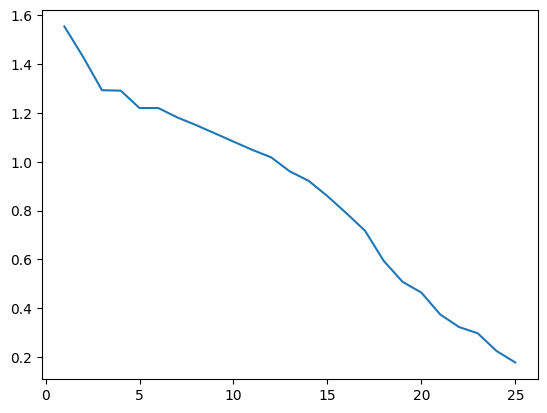

	Epoch [26/30], Step [1/41], Loss: 0.0770
	Epoch [26/30], Step [2/41], Loss: 0.1515
	Epoch [26/30], Step [3/41], Loss: 0.1844
	Epoch [26/30], Step [4/41], Loss: 0.1184
	Epoch [26/30], Step [5/41], Loss: 0.1390
	Epoch [26/30], Step [6/41], Loss: 0.1435
	Epoch [26/30], Step [7/41], Loss: 0.0664
	Epoch [26/30], Step [8/41], Loss: 0.0906
	Epoch [26/30], Step [9/41], Loss: 0.0255
	Epoch [26/30], Step [10/41], Loss: 0.1653
	Epoch [26/30], Step [11/41], Loss: 0.0938
	Epoch [26/30], Step [12/41], Loss: 0.1292
	Epoch [26/30], Step [13/41], Loss: 0.0629
	Epoch [26/30], Step [14/41], Loss: 0.2358
	Epoch [26/30], Step [15/41], Loss: 0.2358
	Epoch [26/30], Step [16/41], Loss: 0.3619
	Epoch [26/30], Step [17/41], Loss: 0.3545
	Epoch [26/30], Step [18/41], Loss: 0.3327
	Epoch [26/30], Step [19/41], Loss: 0.0829
	Epoch [26/30], Step [20/41], Loss: 0.0891
	Epoch [26/30], Step [21/41], Loss: 0.1551
	Epoch [26/30], Step [22/41], Loss: 0.3089
	Epoch [26/30], Step [23/41], Loss: 0.0416
	Epoch [26/30], Step

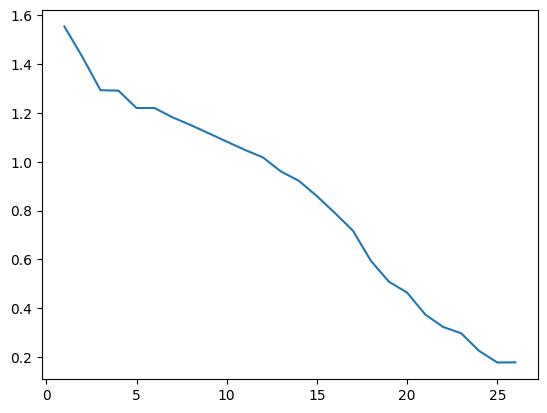

	Epoch [27/30], Step [1/41], Loss: 0.4103
	Epoch [27/30], Step [2/41], Loss: 0.1493
	Epoch [27/30], Step [3/41], Loss: 0.1181
	Epoch [27/30], Step [4/41], Loss: 0.3554
	Epoch [27/30], Step [5/41], Loss: 0.0763
	Epoch [27/30], Step [6/41], Loss: 0.0736
	Epoch [27/30], Step [7/41], Loss: 0.0943
	Epoch [27/30], Step [8/41], Loss: 0.0783
	Epoch [27/30], Step [9/41], Loss: 0.1821
	Epoch [27/30], Step [10/41], Loss: 0.0357
	Epoch [27/30], Step [11/41], Loss: 0.0675
	Epoch [27/30], Step [12/41], Loss: 0.1125
	Epoch [27/30], Step [13/41], Loss: 0.1032
	Epoch [27/30], Step [14/41], Loss: 0.4689
	Epoch [27/30], Step [15/41], Loss: 0.2470
	Epoch [27/30], Step [16/41], Loss: 0.1860
	Epoch [27/30], Step [17/41], Loss: 0.1285
	Epoch [27/30], Step [18/41], Loss: 0.0624
	Epoch [27/30], Step [19/41], Loss: 0.2442
	Epoch [27/30], Step [20/41], Loss: 0.1010
	Epoch [27/30], Step [21/41], Loss: 0.1381
	Epoch [27/30], Step [22/41], Loss: 0.2829
	Epoch [27/30], Step [23/41], Loss: 0.1812
	Epoch [27/30], Step

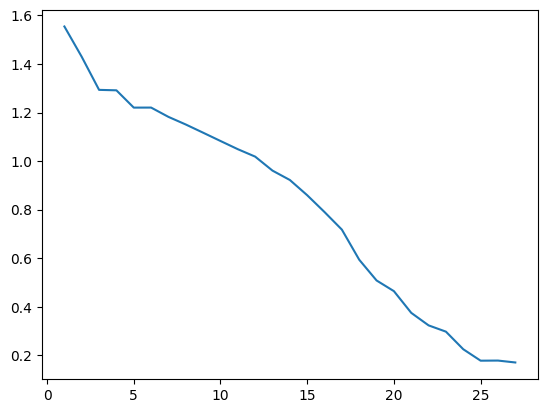

	Epoch [28/30], Step [1/41], Loss: 0.0764
	Epoch [28/30], Step [2/41], Loss: 0.0369
	Epoch [28/30], Step [3/41], Loss: 0.1069
	Epoch [28/30], Step [4/41], Loss: 0.1331
	Epoch [28/30], Step [5/41], Loss: 0.0481
	Epoch [28/30], Step [6/41], Loss: 0.3329
	Epoch [28/30], Step [7/41], Loss: 0.2583
	Epoch [28/30], Step [8/41], Loss: 0.1776
	Epoch [28/30], Step [9/41], Loss: 0.1751
	Epoch [28/30], Step [10/41], Loss: 0.1955
	Epoch [28/30], Step [11/41], Loss: 0.0302
	Epoch [28/30], Step [12/41], Loss: 0.0335
	Epoch [28/30], Step [13/41], Loss: 0.0515
	Epoch [28/30], Step [14/41], Loss: 0.2641
	Epoch [28/30], Step [15/41], Loss: 0.0438
	Epoch [28/30], Step [16/41], Loss: 0.0176
	Epoch [28/30], Step [17/41], Loss: 0.0546
	Epoch [28/30], Step [18/41], Loss: 0.0152
	Epoch [28/30], Step [19/41], Loss: 0.0202
	Epoch [28/30], Step [20/41], Loss: 0.1084
	Epoch [28/30], Step [21/41], Loss: 0.1154
	Epoch [28/30], Step [22/41], Loss: 0.3958
	Epoch [28/30], Step [23/41], Loss: 0.0661
	Epoch [28/30], Step

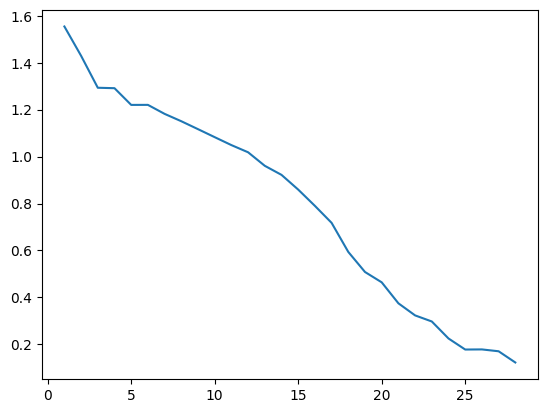

	Epoch [29/30], Step [1/41], Loss: 0.0610
	Epoch [29/30], Step [2/41], Loss: 0.0197
	Epoch [29/30], Step [3/41], Loss: 0.0508
	Epoch [29/30], Step [4/41], Loss: 0.0406
	Epoch [29/30], Step [5/41], Loss: 0.0390
	Epoch [29/30], Step [6/41], Loss: 0.0926
	Epoch [29/30], Step [7/41], Loss: 0.0329
	Epoch [29/30], Step [8/41], Loss: 0.1485
	Epoch [29/30], Step [9/41], Loss: 0.0366
	Epoch [29/30], Step [10/41], Loss: 0.0286
	Epoch [29/30], Step [11/41], Loss: 0.0135
	Epoch [29/30], Step [12/41], Loss: 0.1376
	Epoch [29/30], Step [13/41], Loss: 0.0419
	Epoch [29/30], Step [14/41], Loss: 0.0223
	Epoch [29/30], Step [15/41], Loss: 0.0771
	Epoch [29/30], Step [16/41], Loss: 0.3112
	Epoch [29/30], Step [17/41], Loss: 0.0921
	Epoch [29/30], Step [18/41], Loss: 0.1098
	Epoch [29/30], Step [19/41], Loss: 0.0961
	Epoch [29/30], Step [20/41], Loss: 0.0416
	Epoch [29/30], Step [21/41], Loss: 0.1374
	Epoch [29/30], Step [22/41], Loss: 0.2078
	Epoch [29/30], Step [23/41], Loss: 0.2104
	Epoch [29/30], Step

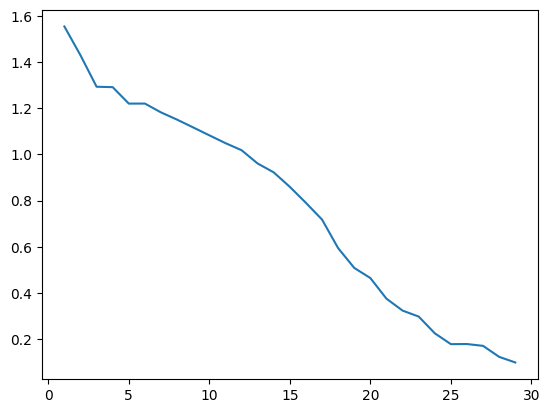

	Epoch [30/30], Step [1/41], Loss: 0.1999
	Epoch [30/30], Step [2/41], Loss: 0.0654
	Epoch [30/30], Step [3/41], Loss: 0.1670
	Epoch [30/30], Step [4/41], Loss: 0.0990
	Epoch [30/30], Step [5/41], Loss: 0.0698
	Epoch [30/30], Step [6/41], Loss: 0.0170
	Epoch [30/30], Step [7/41], Loss: 0.0317
	Epoch [30/30], Step [8/41], Loss: 0.0139
	Epoch [30/30], Step [9/41], Loss: 0.4076
	Epoch [30/30], Step [10/41], Loss: 0.0389
	Epoch [30/30], Step [11/41], Loss: 0.1496
	Epoch [30/30], Step [12/41], Loss: 0.1461
	Epoch [30/30], Step [13/41], Loss: 0.0279
	Epoch [30/30], Step [14/41], Loss: 0.1272
	Epoch [30/30], Step [15/41], Loss: 0.1384
	Epoch [30/30], Step [16/41], Loss: 0.0841
	Epoch [30/30], Step [17/41], Loss: 0.1382
	Epoch [30/30], Step [18/41], Loss: 0.0346
	Epoch [30/30], Step [19/41], Loss: 0.0633
	Epoch [30/30], Step [20/41], Loss: 0.0379
	Epoch [30/30], Step [21/41], Loss: 0.0413
	Epoch [30/30], Step [22/41], Loss: 0.0892
	Epoch [30/30], Step [23/41], Loss: 0.2472
	Epoch [30/30], Step

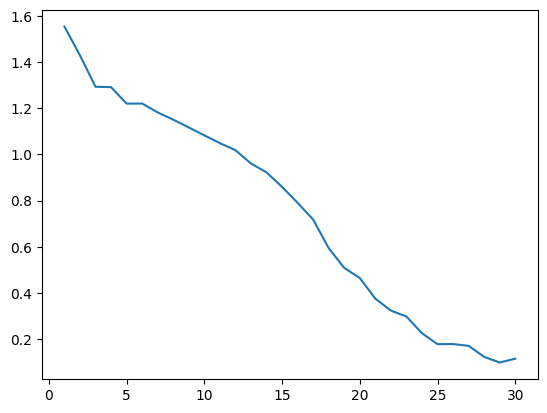

In [ ]:
model = SimpleCNN(num_classes=class_num).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 30
loss_trajectory = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    i = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print('\tEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
              epoch + 1, num_epochs, i + 1, int(len(train_data) / batch_size) + 1, loss.item()))
        i += 1

    epoch_loss = running_loss / len(train_dataloader)
    loss_trajectory.append(epoch_loss)

    epoch_acc = 100 * correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    plt.plot([i + 1 for i in range(len(loss_trajectory))], loss_trajectory)
    plt.show()

In [ ]:
correct = 0
total = 0

y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        print("image shape:", images.shape)
        outputs = model(images)
        outputs = outputs.squeeze()
        _, predicted = torch.max(outputs.data, 1)

        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print("predicted: ", predicted)
        print("label: ", labels)

print('Test Accuracy: {}%'.format((correct / total) * 100))

image shape: torch.Size([32, 3, 224, 224])
predicted:  tensor([4, 0, 1, 4, 0, 1, 3, 3, 4, 3, 0, 2, 2, 1, 0, 1, 0, 3, 1, 1, 4, 3, 1, 3,
        0, 4, 3, 1, 4, 0, 3, 3], device='cuda:0')
label:  tensor([1, 2, 4, 1, 4, 4, 3, 3, 4, 3, 0, 2, 2, 2, 0, 1, 1, 3, 2, 2, 4, 3, 3, 4,
        0, 4, 1, 4, 1, 0, 3, 4], device='cuda:0')
image shape: torch.Size([32, 3, 224, 224])
predicted:  tensor([2, 2, 2, 2, 0, 3, 1, 0, 1, 3, 3, 3, 0, 2, 0, 4, 2, 1, 2, 1, 3, 4, 1, 1,
        0, 2, 0, 3, 2, 1, 2, 3], device='cuda:0')
label:  tensor([3, 4, 2, 1, 3, 3, 1, 3, 3, 3, 3, 2, 0, 2, 2, 4, 2, 0, 0, 2, 4, 4, 1, 1,
        0, 0, 3, 2, 2, 0, 2, 0], device='cuda:0')
image shape: torch.Size([32, 3, 224, 224])
predicted:  tensor([0, 2, 3, 3, 0, 2, 3, 0, 3, 2, 3, 1, 2, 2, 3, 2, 4, 3, 2, 0, 2, 4, 2, 3,
        0, 1, 2, 0, 4, 2, 1, 1], device='cuda:0')
label:  tensor([4, 2, 2, 3, 4, 1, 0, 0, 3, 0, 3, 2, 2, 1, 3, 2, 4, 4, 2, 0, 1, 1, 2, 3,
        2, 0, 2, 3, 2, 0, 0, 1], device='cuda:0')
image shape: torch.Size([32, 3,

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))


Accuracy: 0.4492
Precision: 0.4615
Recall: 0.4492
F1 Score: 0.4458


# Get embedding from VGG


In [ ]:
model

MyVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): 

In [ ]:
train_data

In [ ]:
# to fix OutOfMemoryError: CUDA out of memory. Tried to allocate 11.96 GiB. GPU
total_length = len(train_data)
indices = random.sample(range(total_length), 10)

subset = Subset(train_data, indices)

In [ ]:
len(train_data)

1310

In [ ]:
x = []
for data in subset:
  image = data[0]
  x.append(image)
x = torch.stack(x).to(device)
print(x.shape)

torch.Size([10, 3, 224, 224])


In [ ]:
features = []
def hook(module, input, output):
    features.append(output.clone().detach())

# 注册 hook 到 features 中的某一层 (例如，第四个 MaxPool2d 层)
handle = model.vgg16.features[24].register_forward_hook(hook)

# 注册 hook 到 classifier 中的 Dropout 层 (索引 4)
# handle = model.vgg16.classifier[4].register_forward_hook(hook)

y = model(x)

print(features[0].shape)

torch.Size([31, 512, 14, 14])


# Siamese

## Prepare data

In [ ]:
df['style'].value_counts()

style
modern          2202
eclectic         696
Scandinavian     529
American         335
other            236
casual           157
industrial       149
Japanese         127
neoclassical     120
country           83
Japanese zen      62
light luxury      53
luxurious         40
minimalist        35
oriental          28
exotic            27
Muji              25
classical         23
avant-garde       15
Name: count, dtype: int64

In [ ]:
each_class_sample = 100

df_modern = df[df['style'] == 'modern']
df_modern = df_modern.sample(n=each_class_sample)

df_scand = df[df['style'] == 'Scandinavian']
df_scand = df_scand.sample(n=each_class_sample)

df_american = df[df['style'] == 'American']
df_american = df_american.sample(n=each_class_sample)

df_jap = df[df['style'] == 'Japanese']
df_jap = df_jap.sample(n=each_class_sample)

df_industrial = df[df['style'] == 'industrial']
df_industrial = df_industrial.sample(n=each_class_sample)

siamese_df = pd.concat([df_modern, df_scand, df_american, df_jap, df_industrial])
siamese_df.reset_index(drop=True, inplace=True)
siamese_df['style'].value_counts()

style
modern          100
Scandinavian    100
American        100
Japanese        100
industrial      100
Name: count, dtype: int64

In [ ]:
siamese_df

img_path       style  \
0    /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      modern   
1    /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      modern   
2    /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      modern   
3    /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      modern   
4    /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      modern   
..                                                 ...         ...   
495  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  industrial   
496  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  industrial   
497  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  industrial   
498  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  industrial   
499  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  industrial   

            builder  
0              方澤設計  
1            集藝室內設計  
2              彙禾設計  
3            墐桐空間美學  
4              優適設計  
..              ...  
495          坤宸室內裝修  
496  子境室內裝修設計工程有限公司  
497    富陞室內裝修設計有限公司  
498            九日設計  
499            之群設計  

[500 rows x 3 columns]

In [ ]:
df_img_pairs = pd.DataFrame(columns=["img_path0", "img_path1", "label"])
df_img_pairs = pd.DataFrame(combinations(siamese_df['img_path'].unique(), 2), columns=['img_path0', 'img_path1'])

df_img_pairs = df_img_pairs.merge(siamese_df[['img_path', 'style']], left_on='img_path0', right_on='img_path', how='left').rename(columns={'style': 'style0'})
df_img_pairs = df_img_pairs.merge(siamese_df[['img_path', 'style']], left_on='img_path1', right_on='img_path', how='left').rename(columns={'style': 'style1'})

df_img_pairs.drop(columns=['img_path_x', 'img_path_y'], inplace=True)
df_img_pairs['label'] = (df_img_pairs['style0'] == df_img_pairs['style1']).astype(int)

df_img_pairs.head()

img_path0  \
0  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   
1  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   
2  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   
3  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   
4  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   

                                           img_path1  style0  style1  label  
0  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  modern  modern      1  
1  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  modern  modern      1  
2  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  modern  modern      1  
3  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  modern  modern      1  
4  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...  modern  modern      1

In [ ]:
df_img_pairs.shape

(124750, 5)

In [ ]:
pos = df_img_pairs[df_img_pairs['label'] == 1].sample(n=500)
neg = df_img_pairs[df_img_pairs['label'] == 0].sample(n=500)
df_img_pairs = pd.concat([pos, neg])
df_img_pairs.reset_index(drop=True, inplace=True)
df_img_pairs.drop(columns=['style0', 'style1'], inplace=True)
df_img_pairs.head()

img_path0  \
0  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   
1  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   
2  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   
3  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   
4  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...   

                                           img_path1  label  
0  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      1  
1  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      1  
2  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      1  
3  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      1  
4  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      1

In [ ]:
df_img_pairs.shape

(1000, 3)

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.iloc[idx, :]['label']
        img_path0 = self.df.iloc[idx, :]['img_path0']
        img_path1 = self.df.iloc[idx, :]['img_path1']
        img0 = torchvision.io.read_image(img_path0)
        img1 = torchvision.io.read_image(img_path0)

        transforms = v2.Compose([
            v2.Resize((224, 224)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        img0 = transforms(img0)
        img1 = transforms(img1)

        # label = 1 if style == self.df.iloc[idx, :]['style'] else 0

        return img0, img1, torch.tensor(label)

dataset = SiameseDataset(df_img_pairs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Model

In [ ]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.vgg16 = selfVGG16()

    self.fc1 = nn.Linear(256, 1024)
    self.bn1 = nn.BatchNorm1d(1024)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)

    self.fc2 = nn.Linear(1024, 256)
    self.bn2 = nn.BatchNorm1d(256)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)





  def forward(self, x1, x2):
    x1 = self.vgg16(x1)

    x1 = self.fc1(x1)
    x1 = self.bn1(x1)
    x1 = self.relu(x1)
    x1 = self.dropout(x1)

    x1 = self.fc2(x1)
    x1 = self.bn2(x1)
    x1 = self.relu(x1)
    x1 = self.dropout(x1)


    x2 = self.vgg16(x2)

    x2 = self.fc1(x2)
    x2 = self.bn1(x2)
    x2 = self.relu(x2)
    x2 = self.dropout(x2)

    x2 = self.fc2(x2)
    x2 = self.bn2(x2)
    x2 = self.relu(x2)
    x2 = self.dropout(x2)

    # out2 = out2.view(out2.size(0), -1)
    return x1, x2


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

	Epoch [1/10], Step [1/25], Loss: 202.3592
Epoch [1/10], Loss: 202.3592


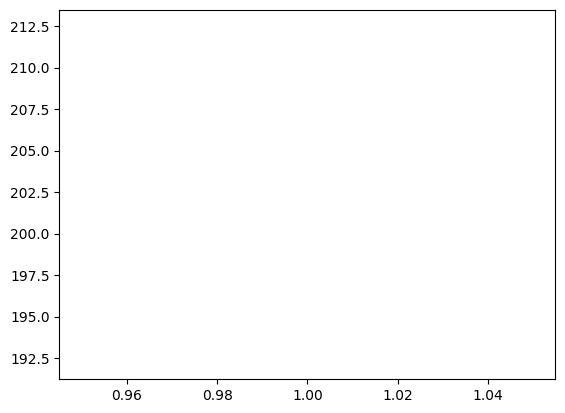

	Epoch [1/10], Step [2/25], Loss: 199.6703
	Epoch [1/10], Step [3/25], Loss: 153.9858
	Epoch [1/10], Step [4/25], Loss: 151.6671
	Epoch [1/10], Step [5/25], Loss: 152.2415
	Epoch [1/10], Step [6/25], Loss: 216.5418
	Epoch [1/10], Step [7/25], Loss: 146.0616
	Epoch [1/10], Step [8/25], Loss: 170.1176
	Epoch [1/10], Step [9/25], Loss: 231.5103
	Epoch [1/10], Step [10/25], Loss: 209.3741
	Epoch [1/10], Step [11/25], Loss: 212.5314
	Epoch [1/10], Step [12/25], Loss: 254.6030
	Epoch [1/10], Step [13/25], Loss: 183.2520
	Epoch [1/10], Step [14/25], Loss: 226.3158
	Epoch [1/10], Step [15/25], Loss: 283.0311
	Epoch [1/10], Step [16/25], Loss: 198.8527
	Epoch [1/10], Step [17/25], Loss: 161.2405
	Epoch [1/10], Step [18/25], Loss: 229.7348
	Epoch [1/10], Step [19/25], Loss: 223.8155
	Epoch [1/10], Step [20/25], Loss: 154.3422
	Epoch [1/10], Step [21/25], Loss: 196.2294
	Epoch [1/10], Step [22/25], Loss: 183.2061
	Epoch [1/10], Step [23/25], Loss: 105.3737
	Epoch [1/10], Step [24/25], Loss: 207.2

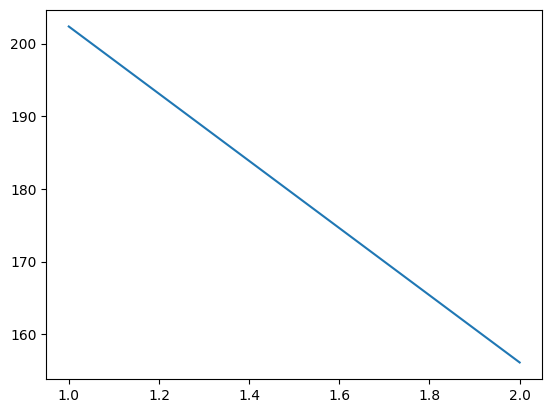

	Epoch [2/10], Step [2/25], Loss: 162.1749
	Epoch [2/10], Step [3/25], Loss: 194.0693
	Epoch [2/10], Step [4/25], Loss: 129.2237
	Epoch [2/10], Step [5/25], Loss: 190.1368
	Epoch [2/10], Step [6/25], Loss: 161.8496
	Epoch [2/10], Step [7/25], Loss: 149.1134
	Epoch [2/10], Step [8/25], Loss: 161.7375
	Epoch [2/10], Step [9/25], Loss: 145.5382
	Epoch [2/10], Step [10/25], Loss: 133.3879
	Epoch [2/10], Step [11/25], Loss: 184.7465
	Epoch [2/10], Step [12/25], Loss: 170.6712
	Epoch [2/10], Step [13/25], Loss: 141.7644
	Epoch [2/10], Step [14/25], Loss: 131.7465
	Epoch [2/10], Step [15/25], Loss: 101.5306
	Epoch [2/10], Step [16/25], Loss: 121.7667
	Epoch [2/10], Step [17/25], Loss: 102.5571
	Epoch [2/10], Step [18/25], Loss: 119.7030
	Epoch [2/10], Step [19/25], Loss: 122.2558
	Epoch [2/10], Step [20/25], Loss: 111.8404
	Epoch [2/10], Step [21/25], Loss: 93.2397
	Epoch [2/10], Step [22/25], Loss: 111.2191
	Epoch [2/10], Step [23/25], Loss: 89.3139
	Epoch [2/10], Step [24/25], Loss: 129.172

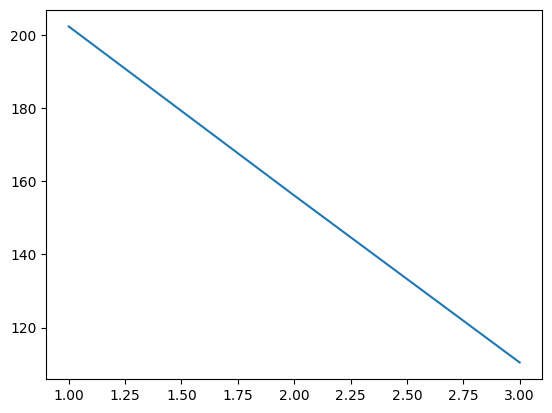

	Epoch [3/10], Step [2/25], Loss: 77.8413
	Epoch [3/10], Step [3/25], Loss: 95.3250
	Epoch [3/10], Step [4/25], Loss: 91.6191
	Epoch [3/10], Step [5/25], Loss: 103.3951
	Epoch [3/10], Step [6/25], Loss: 115.9548
	Epoch [3/10], Step [7/25], Loss: 90.2749
	Epoch [3/10], Step [8/25], Loss: 83.2274
	Epoch [3/10], Step [9/25], Loss: 67.6100
	Epoch [3/10], Step [10/25], Loss: 73.0469
	Epoch [3/10], Step [11/25], Loss: 71.7408
	Epoch [3/10], Step [12/25], Loss: 67.2037
	Epoch [3/10], Step [13/25], Loss: 77.9247
	Epoch [3/10], Step [14/25], Loss: 89.2190
	Epoch [3/10], Step [15/25], Loss: 66.4360
	Epoch [3/10], Step [16/25], Loss: 38.9040
	Epoch [3/10], Step [17/25], Loss: 73.7331
	Epoch [3/10], Step [18/25], Loss: 74.1418
	Epoch [3/10], Step [19/25], Loss: 91.6940
	Epoch [3/10], Step [20/25], Loss: 65.4856
	Epoch [3/10], Step [21/25], Loss: 50.9283
	Epoch [3/10], Step [22/25], Loss: 85.0575
	Epoch [3/10], Step [23/25], Loss: 79.1530
	Epoch [3/10], Step [24/25], Loss: 55.1895
	Epoch [3/10], St

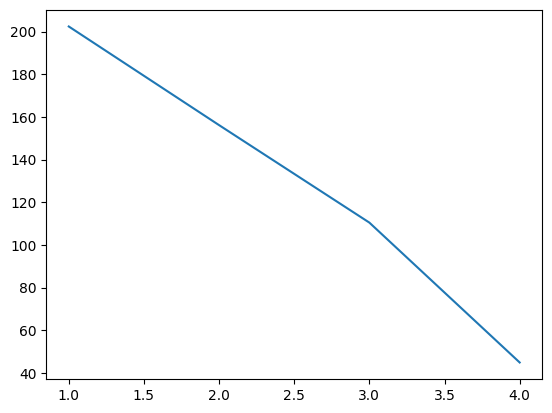

	Epoch [4/10], Step [2/25], Loss: 50.1601
	Epoch [4/10], Step [3/25], Loss: 68.4370
	Epoch [4/10], Step [4/25], Loss: 36.2298
	Epoch [4/10], Step [5/25], Loss: 70.1428
	Epoch [4/10], Step [6/25], Loss: 47.4874
	Epoch [4/10], Step [7/25], Loss: 34.5264
	Epoch [4/10], Step [8/25], Loss: 60.3382
	Epoch [4/10], Step [9/25], Loss: 58.4364
	Epoch [4/10], Step [10/25], Loss: 53.2109
	Epoch [4/10], Step [11/25], Loss: 36.0927
	Epoch [4/10], Step [12/25], Loss: 43.9499
	Epoch [4/10], Step [13/25], Loss: 46.9089
	Epoch [4/10], Step [14/25], Loss: 61.4059
	Epoch [4/10], Step [15/25], Loss: 49.3117
	Epoch [4/10], Step [16/25], Loss: 37.4321
	Epoch [4/10], Step [17/25], Loss: 42.8495
	Epoch [4/10], Step [18/25], Loss: 47.4191
	Epoch [4/10], Step [19/25], Loss: 37.3921
	Epoch [4/10], Step [20/25], Loss: 47.3334
	Epoch [4/10], Step [21/25], Loss: 47.9556
	Epoch [4/10], Step [22/25], Loss: 40.9031
	Epoch [4/10], Step [23/25], Loss: 44.7110
	Epoch [4/10], Step [24/25], Loss: 42.7641
	Epoch [4/10], Step

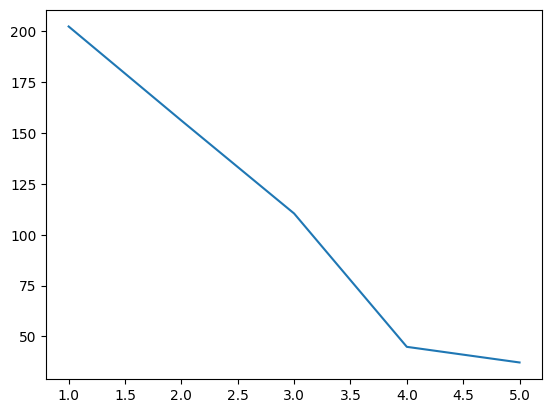

	Epoch [5/10], Step [2/25], Loss: 63.3173
	Epoch [5/10], Step [3/25], Loss: 46.4731
	Epoch [5/10], Step [4/25], Loss: 58.9203
	Epoch [5/10], Step [5/25], Loss: 44.3601
	Epoch [5/10], Step [6/25], Loss: 44.1130
	Epoch [5/10], Step [7/25], Loss: 29.8030
	Epoch [5/10], Step [8/25], Loss: 50.0503
	Epoch [5/10], Step [9/25], Loss: 47.2576
	Epoch [5/10], Step [10/25], Loss: 33.2318
	Epoch [5/10], Step [11/25], Loss: 29.5179
	Epoch [5/10], Step [12/25], Loss: 33.0668
	Epoch [5/10], Step [13/25], Loss: 28.8504
	Epoch [5/10], Step [14/25], Loss: 34.3983
	Epoch [5/10], Step [15/25], Loss: 44.9356
	Epoch [5/10], Step [16/25], Loss: 26.9830
	Epoch [5/10], Step [17/25], Loss: 27.8879
	Epoch [5/10], Step [18/25], Loss: 22.8974
	Epoch [5/10], Step [19/25], Loss: 34.6523
	Epoch [5/10], Step [20/25], Loss: 36.7255
	Epoch [5/10], Step [21/25], Loss: 34.8627
	Epoch [5/10], Step [22/25], Loss: 35.9406
	Epoch [5/10], Step [23/25], Loss: 44.3958
	Epoch [5/10], Step [24/25], Loss: 39.1085
	Epoch [5/10], Step

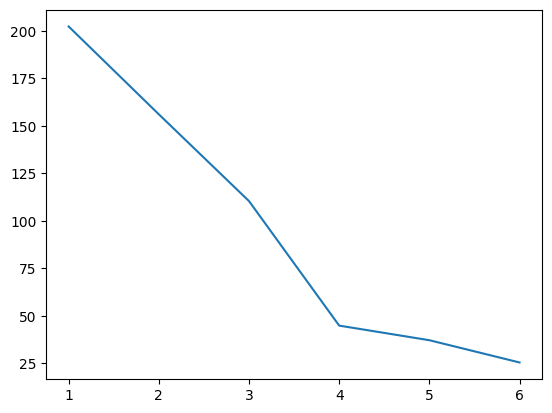

	Epoch [6/10], Step [2/25], Loss: 24.5568
	Epoch [6/10], Step [3/25], Loss: 30.4345
	Epoch [6/10], Step [4/25], Loss: 21.3544
	Epoch [6/10], Step [5/25], Loss: 41.9179
	Epoch [6/10], Step [6/25], Loss: 39.3840
	Epoch [6/10], Step [7/25], Loss: 30.7239
	Epoch [6/10], Step [8/25], Loss: 29.6931
	Epoch [6/10], Step [9/25], Loss: 21.3433
	Epoch [6/10], Step [10/25], Loss: 23.9654
	Epoch [6/10], Step [11/25], Loss: 32.8637
	Epoch [6/10], Step [12/25], Loss: 41.5078
	Epoch [6/10], Step [13/25], Loss: 43.8397
	Epoch [6/10], Step [14/25], Loss: 61.3579
	Epoch [6/10], Step [15/25], Loss: 18.5862
	Epoch [6/10], Step [16/25], Loss: 40.3122
	Epoch [6/10], Step [17/25], Loss: 20.5887
	Epoch [6/10], Step [18/25], Loss: 25.1822
	Epoch [6/10], Step [19/25], Loss: 25.9320
	Epoch [6/10], Step [20/25], Loss: 31.6182
	Epoch [6/10], Step [21/25], Loss: 20.9647
	Epoch [6/10], Step [22/25], Loss: 25.8647
	Epoch [6/10], Step [23/25], Loss: 35.8481
	Epoch [6/10], Step [24/25], Loss: 22.0927
	Epoch [6/10], Step

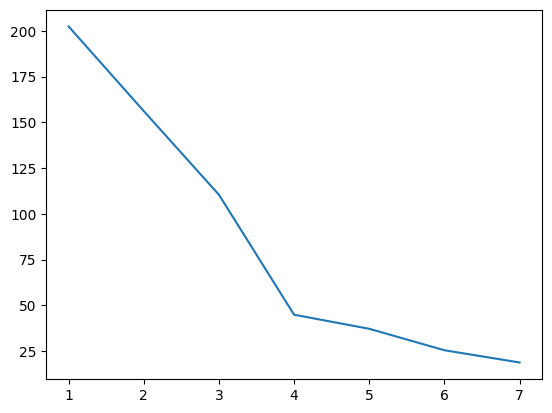

	Epoch [7/10], Step [2/25], Loss: 21.4730
	Epoch [7/10], Step [3/25], Loss: 26.3214
	Epoch [7/10], Step [4/25], Loss: 26.7306
	Epoch [7/10], Step [5/25], Loss: 38.3767
	Epoch [7/10], Step [6/25], Loss: 42.4824
	Epoch [7/10], Step [7/25], Loss: 44.8076
	Epoch [7/10], Step [8/25], Loss: 35.6687
	Epoch [7/10], Step [9/25], Loss: 35.5951
	Epoch [7/10], Step [10/25], Loss: 47.6188
	Epoch [7/10], Step [11/25], Loss: 32.8452
	Epoch [7/10], Step [12/25], Loss: 43.4415
	Epoch [7/10], Step [13/25], Loss: 24.2223
	Epoch [7/10], Step [14/25], Loss: 19.3152
	Epoch [7/10], Step [15/25], Loss: 14.1734
	Epoch [7/10], Step [16/25], Loss: 39.3893
	Epoch [7/10], Step [17/25], Loss: 18.6780
	Epoch [7/10], Step [18/25], Loss: 24.7751
	Epoch [7/10], Step [19/25], Loss: 31.2226
	Epoch [7/10], Step [20/25], Loss: 25.6283
	Epoch [7/10], Step [21/25], Loss: 28.1491
	Epoch [7/10], Step [22/25], Loss: 15.1137
	Epoch [7/10], Step [23/25], Loss: 25.6371
	Epoch [7/10], Step [24/25], Loss: 20.6554
	Epoch [7/10], Step

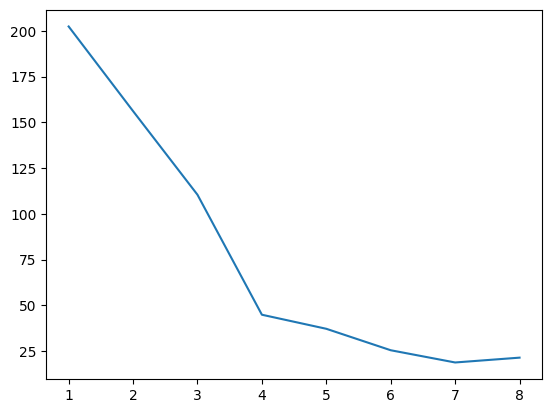

	Epoch [8/10], Step [2/25], Loss: 20.1639
	Epoch [8/10], Step [3/25], Loss: 25.2772
	Epoch [8/10], Step [4/25], Loss: 39.2287
	Epoch [8/10], Step [5/25], Loss: 29.1073
	Epoch [8/10], Step [6/25], Loss: 20.2702
	Epoch [8/10], Step [7/25], Loss: 34.7327
	Epoch [8/10], Step [8/25], Loss: 32.2925
	Epoch [8/10], Step [9/25], Loss: 28.8086
	Epoch [8/10], Step [10/25], Loss: 30.1978
	Epoch [8/10], Step [11/25], Loss: 43.3964
	Epoch [8/10], Step [12/25], Loss: 22.6314
	Epoch [8/10], Step [13/25], Loss: 18.1330
	Epoch [8/10], Step [14/25], Loss: 19.9083
	Epoch [8/10], Step [15/25], Loss: 23.1364
	Epoch [8/10], Step [16/25], Loss: 32.5105
	Epoch [8/10], Step [17/25], Loss: 30.5781
	Epoch [8/10], Step [18/25], Loss: 25.6628
	Epoch [8/10], Step [19/25], Loss: 31.2091
	Epoch [8/10], Step [20/25], Loss: 21.0344
	Epoch [8/10], Step [21/25], Loss: 36.6571
	Epoch [8/10], Step [22/25], Loss: 20.5593
	Epoch [8/10], Step [23/25], Loss: 17.4060
	Epoch [8/10], Step [24/25], Loss: 16.3431
	Epoch [8/10], Step

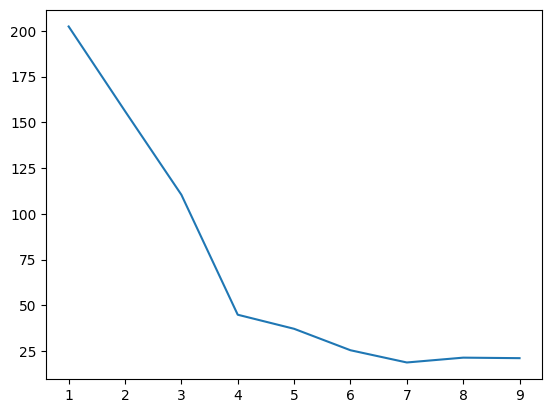

	Epoch [9/10], Step [2/25], Loss: 17.3822
	Epoch [9/10], Step [3/25], Loss: 16.9440
	Epoch [9/10], Step [4/25], Loss: 40.3801
	Epoch [9/10], Step [5/25], Loss: 17.2837
	Epoch [9/10], Step [6/25], Loss: 25.4570
	Epoch [9/10], Step [7/25], Loss: 25.2574
	Epoch [9/10], Step [8/25], Loss: 14.3750
	Epoch [9/10], Step [9/25], Loss: 15.7396
	Epoch [9/10], Step [10/25], Loss: 18.9464
	Epoch [9/10], Step [11/25], Loss: 24.3615
	Epoch [9/10], Step [12/25], Loss: 11.6905
	Epoch [9/10], Step [13/25], Loss: 21.2869
	Epoch [9/10], Step [14/25], Loss: 18.9315
	Epoch [9/10], Step [15/25], Loss: 13.4112
	Epoch [9/10], Step [16/25], Loss: 16.6283
	Epoch [9/10], Step [17/25], Loss: 16.6826
	Epoch [9/10], Step [18/25], Loss: 25.3369
	Epoch [9/10], Step [19/25], Loss: 70.3549
	Epoch [9/10], Step [20/25], Loss: 29.9261
	Epoch [9/10], Step [21/25], Loss: 46.0851
	Epoch [9/10], Step [22/25], Loss: 20.9485
	Epoch [9/10], Step [23/25], Loss: 20.3715
	Epoch [9/10], Step [24/25], Loss: 17.4076
	Epoch [9/10], Step

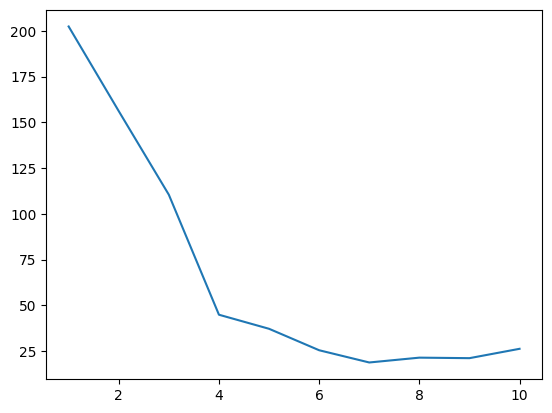

	Epoch [10/10], Step [2/25], Loss: 19.1216
	Epoch [10/10], Step [3/25], Loss: 20.8460
	Epoch [10/10], Step [4/25], Loss: 21.6998
	Epoch [10/10], Step [5/25], Loss: 14.6843
	Epoch [10/10], Step [6/25], Loss: 16.9993
	Epoch [10/10], Step [7/25], Loss: 17.8505
	Epoch [10/10], Step [8/25], Loss: 37.5071
	Epoch [10/10], Step [9/25], Loss: 36.0517
	Epoch [10/10], Step [10/25], Loss: 22.5832
	Epoch [10/10], Step [11/25], Loss: 13.4160
	Epoch [10/10], Step [12/25], Loss: 17.5925
	Epoch [10/10], Step [13/25], Loss: 22.9552
	Epoch [10/10], Step [14/25], Loss: 24.2448
	Epoch [10/10], Step [15/25], Loss: 13.6069
	Epoch [10/10], Step [16/25], Loss: 21.5983
	Epoch [10/10], Step [17/25], Loss: 16.9522
	Epoch [10/10], Step [18/25], Loss: 15.8731
	Epoch [10/10], Step [19/25], Loss: 16.6591
	Epoch [10/10], Step [20/25], Loss: 19.9531
	Epoch [10/10], Step [21/25], Loss: 18.2747
	Epoch [10/10], Step [22/25], Loss: 11.5645
	Epoch [10/10], Step [23/25], Loss: 24.1343
	Epoch [10/10], Step [24/25], Loss: 17.3

In [ ]:
sm_model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(sm_model.parameters(), lr=0.0001)

epoch_size = 10
loss_trajectory = []

for epoch in range(epoch_size):
    for i, (img1, img2, label) in enumerate(train_dataloader):
        img1 = img1.to(device)
        img2 = img2.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        output1, output2 = sm_model(img1, img2)

        loss = criterion(output1, output2, label)

        loss.backward()
        optimizer.step()

        print('\tEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
              epoch + 1, epoch_size, i + 1, int(len(train_data) / batch_size), loss.item()))
        if i == 0:
            print(f'Epoch [{epoch + 1}/{epoch_size}], Loss: {loss.item():.4f}')

            loss_trajectory.append(loss.item())
            plt.plot([j + 1 for j in range(len(loss_trajectory))], loss_trajectory)
            plt.show()

In [ ]:
# prompt: calculate the sm_model's accuracy

# sm_model.eval()

# correct = 0
# total = 0

# with torch.no_grad():
#     for img1, img2, label in test_dataloader:
#         img1 = img1.to(device)
#         img2 = img2.to(device)
#         label = label.to(device)

#         output1, output2 = sm_model(img1, img2)

#         euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim=True)
#         predictions = (euclidean_distance < 1.0).float()

#         total += label.size(0)
#         correct += (predictions == label).sum().item()

# accuracy = correct / total
# print(f'Accuracy: {accuracy:.4f}')


Accuracy: 14.1200


## Inference

In [ ]:
new_df.head()

img_path  style builder
4436  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  寬野室內設計
4001  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0    優適設計
457   /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  緯邁空間規劃
2569  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0    恆合設計
2489  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  墐桐空間美學

In [ ]:
new_df.iloc[2, :]

img_path    /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...
style                                                       0
builder                                                緯邁空間規劃
Name: 457, dtype: object

In [ ]:
new_df['style'].value_counts()

style
0    300
1    300
2    300
3    149
4    127
Name: count, dtype: int64

In [ ]:
new_df.shape

(1176, 3)

In [ ]:
def get_img(img_path):
    image = torchvision.io.read_image(img_path)

    transforms = v2.Compose([
        # v2.CenterCrop((224, 224)),
        v2.Resize((224, 224)),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = transforms(image)
    return image

In [ ]:
model.eval() # avoid batch norm at myVGG16's inference stage

user_img_path = '/content/drive/MyDrive/碩班/碩一下/Project/Dataset/img/370/03_3.jpg'
user_img = get_img(user_img_path)
user_img = user_img.unsqueeze(0)
user_img = user_img.to(device)

y = model(user_img)
print(y)
_, predicted = torch.max(y, 1)
print(predicted.item())

user_style = predicted.item()

tensor([[0.9313, 0.0201, 0.0098, 0.0052, 0.0336]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
0


In [ ]:
x = []
x.append(user_img.squeeze(0))

new_df_instyle = new_df[new_df['style'] == user_style].sample(n=30).copy()

for index, row in new_df_instyle.iterrows():
      x.append(get_img(row['img_path']).to(device))

In [ ]:
new_df_instyle.shape

(30, 3)

In [ ]:
len(x)

31

In [ ]:
x = torch.stack(x)
x = x.to(device)
x.shape

torch.Size([31, 3, 224, 224])

In [ ]:
features = []
def hook(module, input, output):
    features.append(output.clone().detach())

# model = SiameseNetwork()
# x = torch.randn(20, 3, 224, 224).to(device)
handle = sm_model.vgg16.register_forward_hook(hook)
y = sm_model(x, x)
print(features[0].shape)
handle.remove()

torch.Size([31, 256])


## Similarity

In [ ]:
# user_img_path = '/content/drive/MyDrive/碩班/碩一下/Project/Dataset/img/372/03_2.jpg'

In [ ]:
new_df_instyle.shape

(30, 3)

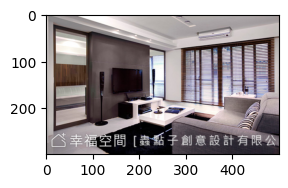

In [ ]:
image = Image.open(user_img_path)

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.show()

In [ ]:
new_df_instyle = new_df_instyle.reset_index(drop=True)

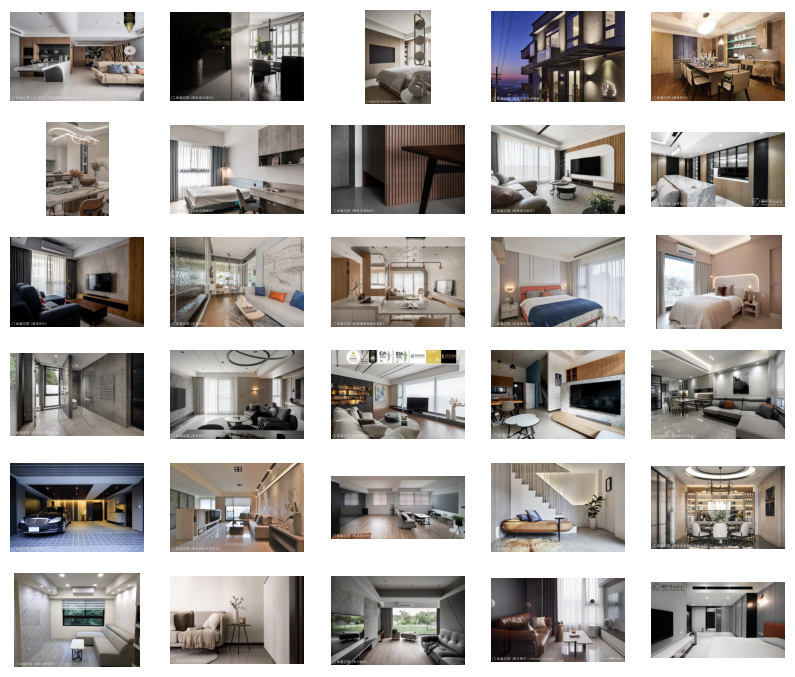

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i, row in new_df_instyle.iterrows():
    ax = fig.add_subplot(int(new_df_instyle.shape[0] / 5) + 1, 5, i + 1)
    ax.axis('off')
    ax.imshow(plt.imread(row['img_path']))

plt.show()

In [ ]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
user = features[0][:1, :]
other_imgs = features[0][1:, :]

sims = []
for img in other_imgs:
    sims.append(cos(user, img)[0].item())
max(sims)
print(sims)
print("sim length:", len(sims))
max_index = sims.index(max(sims))
print("max index:", max_index)

[0.9999995231628418, 0.9999982714653015, 0.9999997615814209, 0.9999978542327881, 0.9999993443489075, 0.9999990463256836, 0.9999985694885254, 0.9999949336051941, 0.9999991655349731, 0.999999463558197, 0.9999991059303284, 0.9999984502792358, 0.9999986886978149, 0.9999969005584717, 0.9999979734420776, 0.9999992847442627, 0.9999994039535522, 0.9999992847442627, 0.9999974370002747, 0.9999995231628418, 0.9999968409538269, 0.9999989867210388, 0.9999991655349731, 0.9999983310699463, 0.9999995231628418, 0.9999979138374329, 0.9999979138374329, 0.9999996423721313, 0.9999985694885254, 0.9999995231628418]
sim length: 30
max index: 2


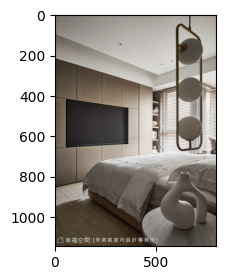

In [ ]:
image = Image.open(new_df_instyle.iloc[max_index, :]['img_path'])

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.show()

In [ ]:
# prompt: get max value's index in sim
new_df_instyle.iloc[max_index, :]['builder']

'朱英凱室內設計事務所'

In [ ]:
new_df_instyle.iloc[max_index, :]['style']

1

# Baselines

## CNN 分類給設計師
* 因為設計公司有太多（共 385 間），不適合作分類

In [ ]:
df['builder'].value_counts()

builder
海納空間設計              133
寬野室內設計              130
御見設計                109
知域設計×一己空間制作         104
芬格設計工程               91
                   ... 
YYCC Design           1
波普設計 Pop Up Deco      1
尚藝室內裝修設計有限公司          1
上築空間設計                1
格綸設計                  1
Name: count, Length: 385, dtype: int64

In [ ]:
df['builder'].value_counts().shape

(385,)

# Ablation

## `Classifier` + Random recommendation
- 同個 class 隨機推薦 -> 格局、色調皆不同 (同風格還是可能差很多)

In [ ]:
res = new_df[new_df['style'] == user_style].sample(n=1).copy()
res

img_path  style       builder
60  /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...      0  程翊室內裝修工程有限公司

In [ ]:
res.iloc[0, :]['img_path']

'/content/drive/MyDrive/碩班/碩一下/Project/Dataset/img2/14056/174292.jpg'

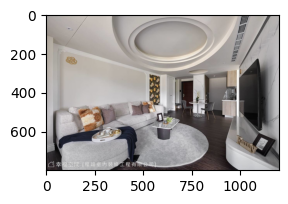

In [ ]:
image = Image.open(res.iloc[0, :]['img_path'])

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.show()

In [ ]:
print(res.iloc[0, :]['builder'])
print(res.iloc[0, :]['style'])

程翊室內裝修工程有限公司
0


## `Siamese network` w/o classifier
- 不分類風格，只在所有照片中找尋最相似的圖片 -> 照片分割相似(樑柱位置相同)、但格局不同(e.g., 沒有沙發)

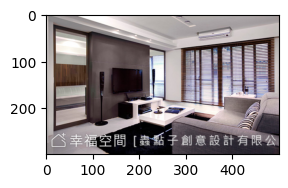

In [ ]:
image = Image.open(user_img_path)

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.show()

In [ ]:
new_df.shape

(1176, 3)

In [ ]:
x = []
x.append(user_img.squeeze(0))

new_df_rand = new_df.sample(n=30).copy()

for index, row in new_df_rand.iterrows():
      x.append(get_img(row['img_path']).to(device))


# x = []
# x.append(user_img.squeeze(0))

# for index, row in new_df.iterrows():
#       x.append(get_img(row['img_path']).to(device))

In [ ]:
x = torch.stack(x)
x = x.to(device)
x.shape

torch.Size([31, 3, 224, 224])

In [ ]:
x.shape

torch.Size([31, 3, 224, 224])

In [ ]:
features = []
def hook(module, input, output):
    features.append(output.clone().detach())

# model = SiameseNetwork()
# x = torch.randn(20, 3, 224, 224).to(device)
handle = sm_model.vgg16.register_forward_hook(hook)
y = sm_model(x, x)
print(features[0].shape)
handle.remove()

torch.Size([31, 256])


In [ ]:
new_df_rand = new_df_rand.reset_index(drop=True)

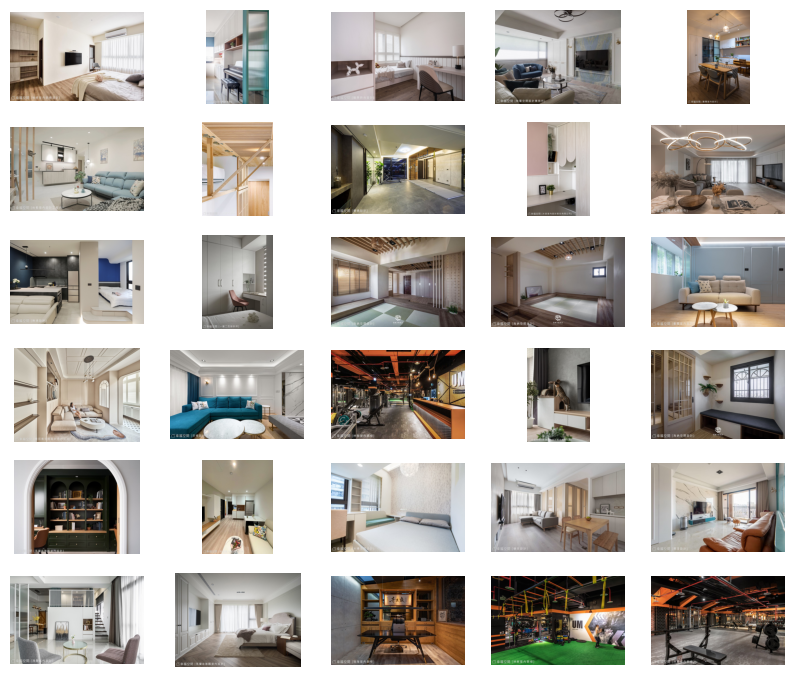

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i, row in new_df_rand.iterrows():
    ax = fig.add_subplot(int(new_df_rand.shape[0] / 5 + 1), 5, i + 1)
    ax.axis('off')
    ax.imshow(plt.imread(row['img_path']))

plt.show()

In [ ]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
user = features[0][:1, :]
other_imgs = features[0][1:, :]

sims = []
for img in other_imgs:
    sims.append(cos(user, img).mean().item())
max(sims)
print(sims)
print("sim length:", len(sims))
max_index = sims.index(max(sims))
print("max index:", max_index)

[0.999997615814209, 0.999997079372406, 0.9999958276748657, 0.9999986886978149, 0.9999995231628418, 0.9999964237213135, 0.9999974966049194, 0.9999997019767761, 0.9999980330467224, 0.9999986290931702, 0.9999995231628418, 0.9999977350234985, 0.9999995231628418, 0.9999996423721313, 0.9999966621398926, 0.9999966025352478, 0.999998152256012, 0.9903973340988159, 0.9999983310699463, 0.9999997615814209, 0.9999966621398926, 0.9999990463256836, 0.9999953508377075, 0.9999971389770508, 0.9999977946281433, 0.9999988675117493, 0.9999964237213135, 0.9999952912330627, 0.9999505281448364, 0.9928566217422485]
sim length: 30
max index: 19


In [ ]:
new_df_rand.iloc[max_index, :]

img_path    /content/drive/MyDrive/碩班/碩一下/Project/Dataset/...
style                                                       4
builder                                                海納空間設計
Name: 19, dtype: object

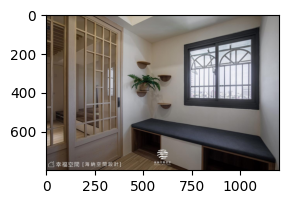

In [ ]:
image = Image.open(new_df_rand.iloc[max_index, :]['img_path'])
# image = Image.open(new_df_instyle.iloc[max_index, :]['img_path'])

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.show()

In [ ]:
new_df_rand.iloc[max_index, :]['builder']

'海納空間設計'

## VGG embedding

In [ ]:
x.shape

torch.Size([4, 3, 224, 224])

In [ ]:
features = []
def hook(module, input, output):
    features.append(output.clone().detach())

# 注册 hook 到 features 中的某一层 (例如，第四个 MaxPool2d 层)
handle = model.vgg16.features[24].register_forward_hook(hook)

# 注册 hook 到 classifier 中的 Dropout 层 (索引 4)
# handle = model.vgg16.classifier[4].register_forward_hook(hook)

y = model(x)

print(features[0].shape)

torch.Size([4, 512, 14, 14])


In [ ]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
user = features[0][:1, :]
user = torch.squeeze(user, dim=0)

other_imgs = features[0][1:, :]

sims = []
for img in other_imgs:
    # print(cos(user, img).mean().item())
    sims.append(cos(user, img).mean().item())
max(sims)
print(sims)
print("sim length:", len(sims))
max_index = sims.index(max(sims))
print("max index:", max_index)

[0.5046876668930054, 0.45220649242401123, 0.5012015104293823]
sim length: 3
max index: 0


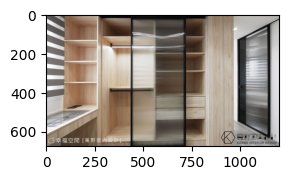

In [ ]:
image = Image.open(new_df_rand.iloc[max_index, :]['img_path'])
# image = Image.open(new_df_instyle.iloc[max_index, :]['img_path'])

plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.show()

In [ ]:
new_df_rand.iloc[max_index, :]['builder']

'寬野室內設計'

## VGG16 的其他分類器 baseline (TODO)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x